# <center><font color='magenta'>**Assignment 1 for DA3**</font></center>
### <center>Central European University, 2024-2025</center>
### <left>Analyzing AirBnBs in Rome, Italy</left>
### <left>2300715 - Saad Joiya</left>

<span style="font-size: 18px;"> General Overview: We choose airbnb data for Rome, Italy for Q2 2024. We predict the prices based on different properties of the airbnb. We check the validity on Rome Q3 2024 (temporal) and Florence Q2 2024 (spatial).</span> 

## Importing Necessary libraries and Creating Helper functions

In [10]:
import warnings
!pip install patchworklib
!pip install skimpy
!pip install xgboost
!pip install shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patchworklib as pw
from plotnine import *
import seaborn as sns
from skimpy import skim
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
import patsy
import time
import shap
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import mean_squared_error
%matplotlib inline
warnings.filterwarnings("ignore")

<Figure size 100x100 with 0 Axes>

In [11]:
def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator


    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }


In [12]:
def da_variable_importance_plot(
    data: pd.DataFrame,
    x: str = "Importance",
    y: str = "Feature",
    title: str | None = None,
):
    data = data.sort_values(by=x, ascending=False)

    sns.scatterplot(data=data, x=x, y=y, s=60)

    # Add horizontal lines from 0 to imp_percentage
    for _, row in data.iterrows():
        plt.hlines(y=row[y], xmin=0, xmax=row[x], linewidth=2.5)

    plt.xticks(np.arange(0, data[x].max(), 0.05))
    plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    plt.title(title)
    plt.xlabel("Importance (Percent)")
    plt.ylabel("Variable Name")
    plt.show()

## Data Cleaning

In [14]:
hotels = pd.read_csv("RomeListingsQ22024.csv")

<span style="font-size: 18px;">**We filter for variables that make sense in the context of predicting price. We do not consider the rest. Some identifier variables like id are also kept if we need to spot individual listings for some reason like anomalies etc.**

In [16]:
hotels_cleansed2 = hotels[['id', 'listing_url', 'name','host_id','host_is_superhost',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
        'bedrooms', 'beds', 'amenities', 'price','minimum_nights','calendar_last_scraped', 'number_of_reviews',
       'first_review','review_scores_rating','reviews_per_month','license']]

In [17]:
hotels_cleansed2 = hotels_cleansed2.loc[hotels_cleansed2['price'].notnull()]

<span style="font-size: 18px;">**Values seem to be missing at random. We will impute them using room_type**

In [19]:
room_type = pd.DataFrame(hotels_cleansed2.groupby('room_type').agg(bathrooms = ('bathrooms','mean'),bedrooms = ('bedrooms','mean'),beds = ('beds','mean')))
room_type.reset_index(inplace = True)
room_type.head()

room_type  bathrooms  bedrooms      beds
0  Entire home/apt   1.366310  1.593881  2.170334
1       Hotel room   1.130435  1.331104  1.638796
2     Private room   1.104760  1.110050  1.269459
3      Shared room   1.012605  1.026087  2.610169

In [20]:
#filling na for bathrooms
hotels_cleansed2['bathrooms'].fillna(1,inplace = True)

#filling na for bedrooms
hotels_cleansed2.loc[hotels_cleansed2['room_type'] == 'Entire home/apt']['bedrooms'].fillna(2, inplace = True)
hotels_cleansed2['bedrooms'].fillna(1, inplace = True)


#filling na for beds
hotels_cleansed2.loc[hotels_cleansed2['room_type'] == 'Private room']['beds'].fillna(1, inplace = True)
hotels_cleansed2['beds'].fillna(2, inplace = True)


In [21]:
hotels_cleansed2['host_is_superhost'].value_counts()

host_is_superhost
f    18143
t    10404
Name: count, dtype: int64

In [22]:
hotels_cleansed2.groupby('host_is_superhost')['review_scores_rating'].mean()

host_is_superhost
f    4.683634
t    4.861386
Name: review_scores_rating, dtype: float64

In [23]:
hotels_cleansed2.groupby('host_is_superhost')['number_of_reviews'].mean()

host_is_superhost
f    37.838726
t    94.905133
Name: number_of_reviews, dtype: float64

<span style="font-size: 18px;">**Hosts with > 4.77 rating and > 65 reviews would be classified as super host to fill na** 

In [25]:
hotels_cleansed2.loc[(hotels_cleansed2['review_scores_rating'] >= 4.77) & hotels_cleansed2['number_of_reviews'] >= 65]['host_is_superhost'].fillna('t', inplace = True)
hotels_cleansed2['host_is_superhost'].fillna('f', inplace = True)

<span style="font-size: 18px;">**Filling nulls in review_scores_rating and reviews_per_month using average values for host_id**

In [27]:
host_reviews = pd.DataFrame(hotels_cleansed2.groupby('host_id').agg(host_reviews_rating = ('review_scores_rating', 'mean'), host_reviews_count = ('reviews_per_month','mean')))
host_reviews.reset_index(inplace = True)
host_reviews.head()

host_id  host_reviews_rating  host_reviews_count
0     1944             4.643333            0.140000
1     2353             4.600000            1.190000
2     3047             4.736000            0.134000
3     3504             4.785000            0.148333
4    11756             4.920000            0.420000

In [28]:
hotels_cleansed2 = hotels_cleansed2.merge(host_reviews, left_on = 'host_id',right_on = 'host_id', how = 'left')

In [29]:
hotels_cleansed2['review_scores_rating'].fillna(hotels_cleansed2['host_reviews_rating'], inplace = True)
hotels_cleansed2['reviews_per_month'].fillna(hotels_cleansed2['host_reviews_count'], inplace = True)

<span style="font-size: 18px;">**We still see some nulls in these columns, we can fill them using average values depending on whether host is superhost or not**

In [31]:
hotels_cleansed2.groupby('host_is_superhost')['review_scores_rating'].mean()

host_is_superhost
f    4.679457
t    4.860379
Name: review_scores_rating, dtype: float64

In [32]:
hotels_cleansed2.groupby('host_is_superhost')['reviews_per_month'].mean()

host_is_superhost
f    1.576200
t    2.409887
Name: reviews_per_month, dtype: float64

In [33]:
hotels_cleansed2.loc[hotels_cleansed2['host_is_superhost'] == 't']['review_scores_rating'].fillna(4.86, inplace = True)
hotels_cleansed2['review_scores_rating'].fillna(4.68, inplace = True)

hotels_cleansed2.loc[hotels_cleansed2['host_is_superhost'] == 't']['reviews_per_month'].fillna(2.41, inplace = True)
hotels_cleansed2['reviews_per_month'].fillna(1.58, inplace = True)

<span style="font-size: 18px;">**We will fill first_review date using reviews per month and number of reviews the listing got. Calendar_last_scraped would be used as baseline for filling the dates backward**

In [35]:
hotels_cleansed2['months_since_first_review'] = np.floor(hotels_cleansed2['number_of_reviews']/hotels_cleansed2['reviews_per_month'])

In [36]:
hotels_cleansed2['first_review'] = pd.to_datetime(hotels_cleansed2['first_review'], errors='coerce')
hotels_cleansed2['calendar_last_scraped'] = pd.to_datetime(hotels_cleansed2['calendar_last_scraped'], errors='coerce')

In [37]:
hotels_cleansed2['first_review'].fillna(hotels_cleansed2['calendar_last_scraped'] - hotels_cleansed2['months_since_first_review'].apply(lambda x: pd.DateOffset(months=x)), inplace = True)

In [38]:
hotels_cleansed = hotels_cleansed2[['id','host_is_superhost',
       'neighbourhood_cleansed', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'amenities', 'price','minimum_nights','calendar_last_scraped', 'number_of_reviews',
       'first_review','review_scores_rating', 'reviews_per_month']]

<span style="font-size: 18px;">**All null values have been taken care off. We will keep one listing identifier for now and remove the unnecessary columns. Columns removal criteria for now:** 
1. Categorical features with too many unique values
2. Features that will not be used in feature engineering
3. Features that do not intuitively make sense to be used in predictive modelling

## Feature Engineering

### Analyzing Numeric Variables - Feature Engineering, Selections and Transformations

<span style="font-size: 16px;">**Converting price to numeric format and checking distribution**

In [43]:
hotels_cleansed['price'] = hotels_cleansed['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
hotels_cleansed['price'] = pd.to_numeric(hotels_cleansed['price'])

<span style="font-size: 16px;">**99% of price values would be with in 3 Std deviations of the mean**

In [45]:
n99th_percentile = np.percentile(hotels_cleansed['price'], 99.5)
print(n99th_percentile)

1559.0599999999977


In [46]:
hotels_cleansed = hotels_cleansed.loc[hotels_cleansed['price'] < n99th_percentile]

<span style="font-size: 18px;">**Creating a Distance to City Center Feature using Latitude and Longitude values**

Cooridnates for City Center Rome:

📍 Piazza Venezia

Coordinates: 41.8966° N, 12.4825° E

These would be used in calculating distance from city center in Miles below

In [49]:
# Coordinates of Rome city center
rome_center_lat = 41.8966
rome_center_lon = 12.4825

# Define function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius_of_earth_miles = 3958.8  # Radius of Earth in miles
    return radius_of_earth_miles * c

# Apply the function to each row in the DataFrame
hotels_cleansed['distance_to_rome_center_miles'] = hotels_cleansed.apply(
    lambda row: haversine(row['latitude'], row['longitude'], rome_center_lat, rome_center_lon),
    axis=1
)



In [50]:
hotels_cleansed['distance_to_rome_center_miles'] = round(hotels_cleansed['distance_to_rome_center_miles'],2)

<span style="font-size: 18px;">**Dropping Latitude and Longitude as we have the distance from center now**

In [52]:
hotels_cleansed.drop(['latitude','longitude'], axis = 1, inplace = True)

<span style="font-size: 18px;">**Creating months since first review column and dropping first_review and last_calendar_scarped date columns**

In [54]:
hotels_cleansed['months_since_first_review'] = (hotels_cleansed['calendar_last_scraped'].dt.year - hotels_cleansed['first_review'].dt.year) * 12 + \
                          (hotels_cleansed['calendar_last_scraped'].dt.month - hotels_cleansed['first_review'].dt.month)

In [55]:
hotels_cleansed.drop(['calendar_last_scraped','first_review'], axis = 1, inplace = True)

In [56]:
hotels_cleansed['id'] = hotels_cleansed['id'].astype(str)

In [57]:
skim(hotels_cleansed.filter(["price","distance_to_rome_center_miles","accomodates","bedrooms","bathrooms","beds","number_of_reviews", "review_scores_rating","reviews_per_month","months_since_first_review","minimum_nights"]))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 28554  │ │ float64     │ 7     │                                                          │
│ │ Number of columns │ 10     │ │ int32       │ 3     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %  ┃ mean   ┃ sd      ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ price                    │   0 │     0 │  186.7 │   155.3 │    10 │   100 │   144 │   212 │  1557 │   ▇▁   │  │
│ │ distance_to_rome_center_ │   0 │     0 │  2.349 │   2.708 │  0.02 │  0.89 │  1.59 │  2.56 │ 18.17 │   ▇▁   │  │
│ │ miles                    │     │       │        │         │       │       │       │       │       │        │  │
│ │ bedrooms                 │   0 │     0 │  1.469 │  0.8271 │     0 │     1 │     1 │     2 │    13 │   ▇▁   │  │
│ │ bathrooms                │   0 │     0 │  1.294 │  0.6345 │     0 │     1 │     1 │     1 │    12 │   ▇▂   │  │
│ │ beds                     │   0 │     0 │  1.948 │   1.538 │     0 │     1 │     2 │     3 │    24 │   ▇▁   │  │
│ │ number_of_reviews        │   0 │     0 │  59.05 │   94.34 │     0 │     4 │    20 │    73 │  2153 │   ▇    │  │
│ │ review_scores_rating     │   0 │     0 │  4.745 │  0.3135 │     1 │  4.67 │  4.81 │  4.95 │     5 │     ▁▇ │  │
│ │ reviews_per_month        │   0 │     0 │  1.882 │   1.682 │  0.01 │  0.59 │  1.58 │  2.73 │ 39.29 │   ▇    │  │
│ │ months_since_first_revie │   0 │     0 │  36.21 │   39.02 │     0 │     4 │    20 │    64 │   169 │ ▇▁▂▂▁  │  │
│ │ w                        │     │       │        │         │       │       │       │       │       │        │  │
│ │ minimum_nights           │   0 │     0 │  2.828 │   14.18 │     1 │     1 │     2 │     3 │   999 │   ▇    │  │
│ └──────────────────────────┴─────┴───────┴────────┴─────────┴───────┴───────┴───────┴───────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<span style="font-size: 18px;">**Reviews per month cannot be greater than 30 even if the place is rented out for 30 days to different tenants, we remove these outliers**

In [59]:
hotels_cleansed = hotels_cleansed.loc[hotels_cleansed['reviews_per_month'] <= 30] 

In [60]:
len(hotels_cleansed.loc[hotels_cleansed['review_scores_rating'] > 3.5])

28273

<span style="font-size: 18px;">**Most of review ratings are above 3.5 (99%) so we take these for removing outliers**

In [62]:
hotels_cleansed = hotels_cleansed.loc[hotels_cleansed['review_scores_rating'] >= 3.5] 

<span style="font-size: 18px;">**Most of the minimum nights allowed would be below 15 days. Mean and std dev also show > 95% values would lie below this range**

In [64]:
hotels_cleansed = hotels_cleansed.loc[hotels_cleansed['minimum_nights'] <= 15] 

In [65]:
len(hotels_cleansed)

27989

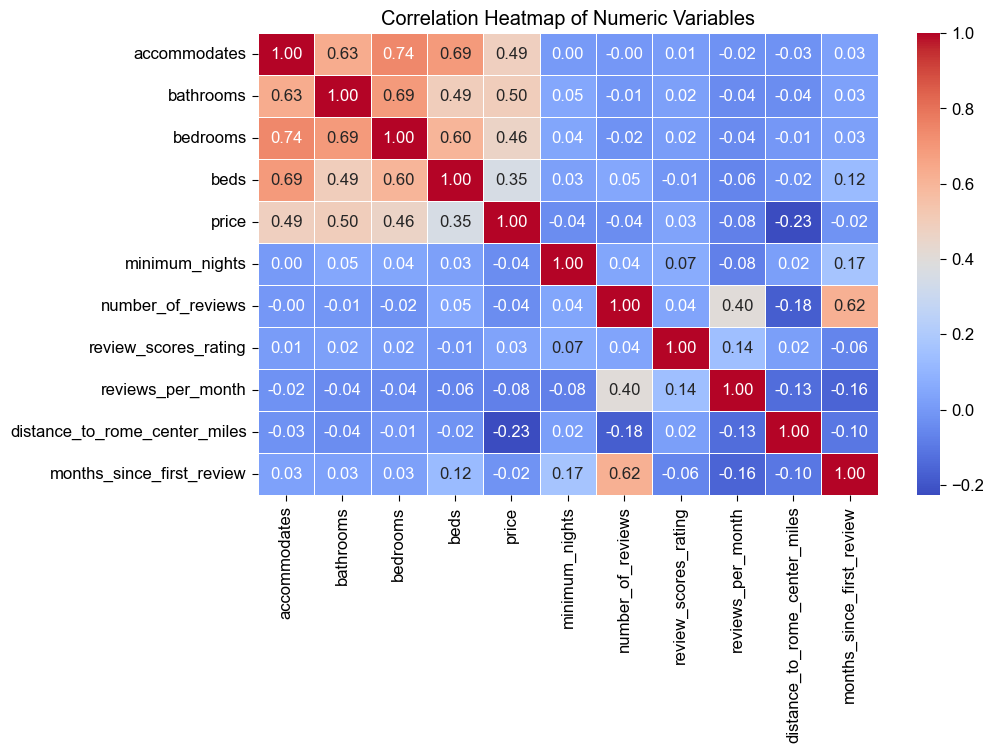

In [66]:
numeric_df = hotels_cleansed.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Visualize with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

<span style="font-size: 18px;">**We see high correlation between accomodation space and bedrooms, bathrooms and beds, lets explore futher**

In [68]:
accomodates = pd.DataFrame(hotels_cleansed.groupby('accommodates').agg(bedrooms = ('bedrooms', 'mean'),bathrooms = ('bathrooms', 'mean'),beds = ('beds', 'mean')))
accomodates.reset_index(inplace = True)
accomodates.head()

accommodates  bedrooms  bathrooms      beds
0             1  1.035152   1.108485  1.089697
1             2  1.011011   1.045086  0.999652
2             3  1.108792   1.074390  1.675684
3             4  1.365871   1.194681  1.899099
4             5  1.875453   1.399004  2.816123

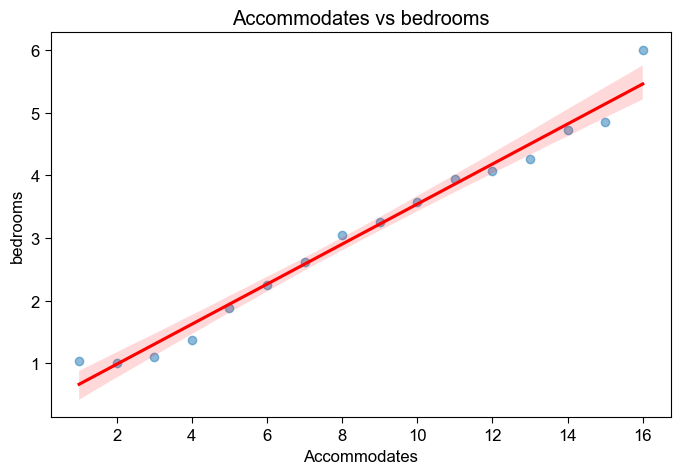

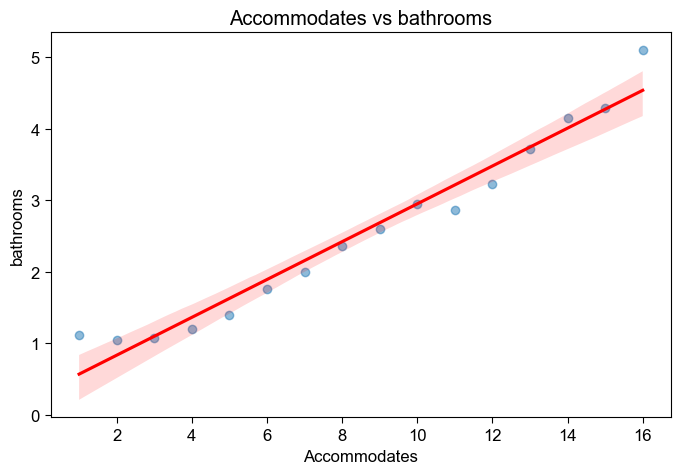

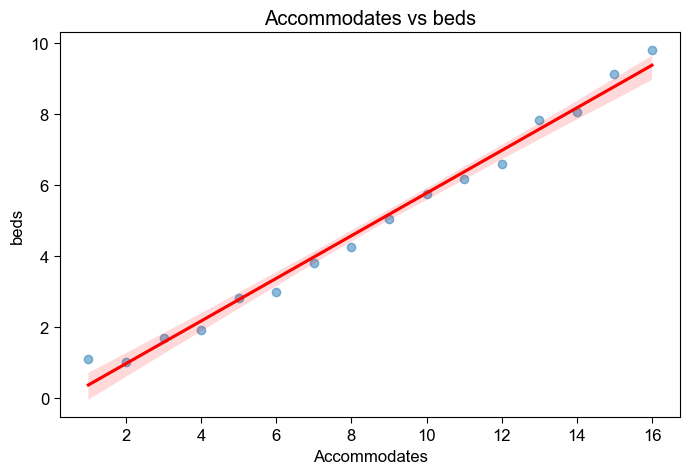

In [69]:
# Define pairs to plot
columns_to_plot = ["bedrooms", "bathrooms", "beds"]

# Create scatter plots with regression lines
for col in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.regplot(x=accomodates["accommodates"], y=accomodates[col], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    plt.xlabel("Accommodates")
    plt.ylabel(col)
    plt.title(f"Accommodates vs {col}")
    plt.show()

<span style="font-size: 18px;">**Accomodates seems to be a good proxy for all variables describing number of bedrooms, bathrooms and beds. We will use it and drop the rest**

In [71]:
hotels_cleansed.drop(['bathrooms','bedrooms','beds'], axis = 1, inplace = True)

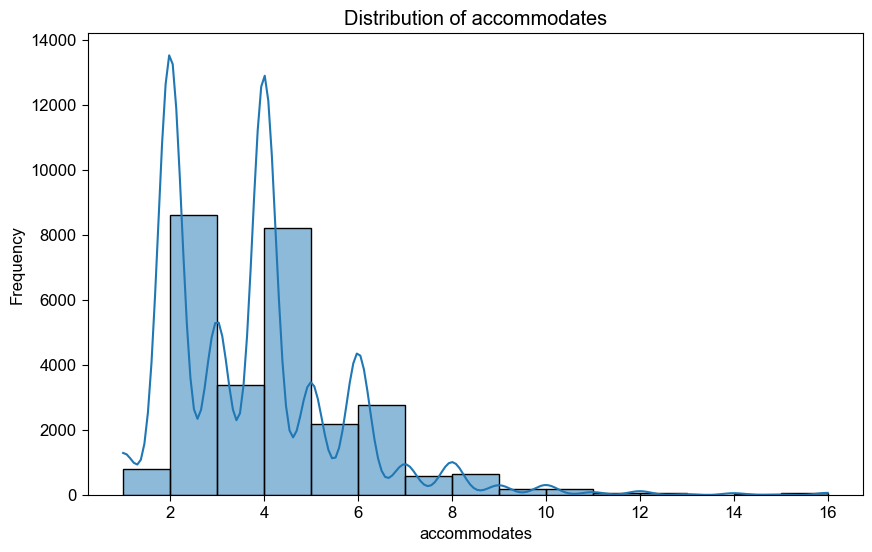

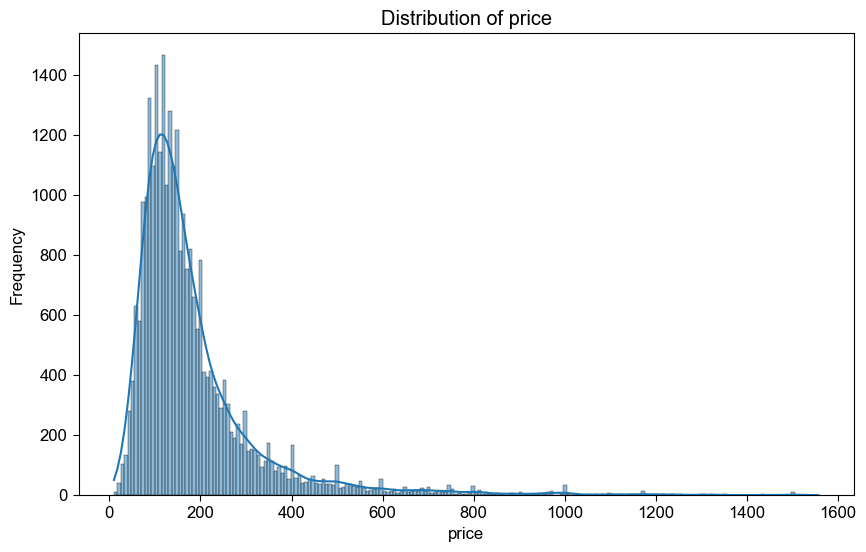

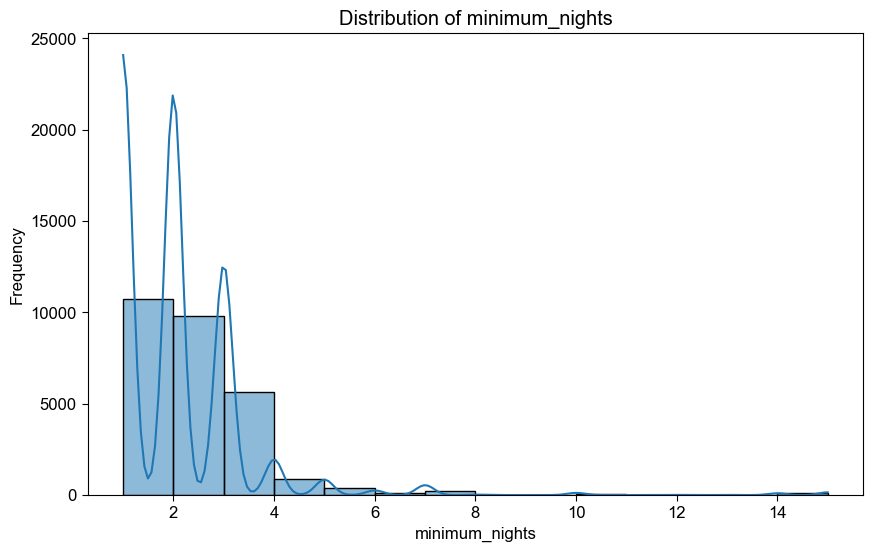

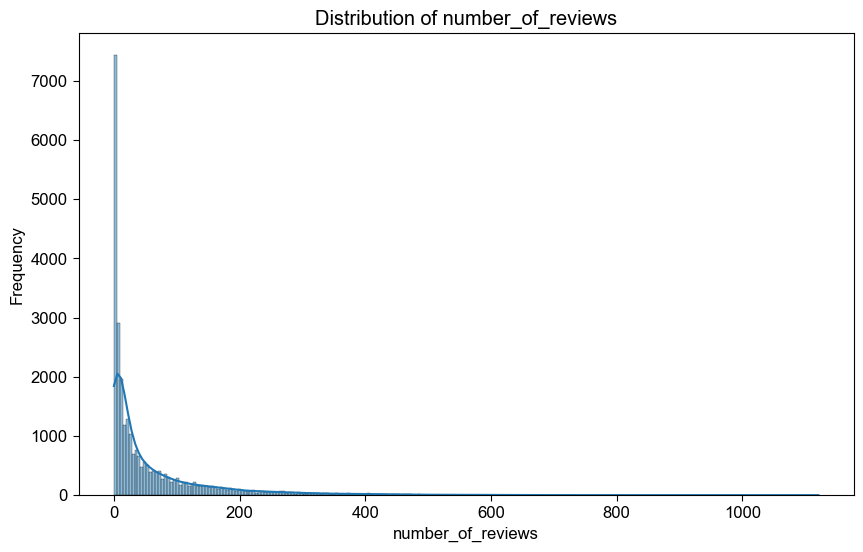

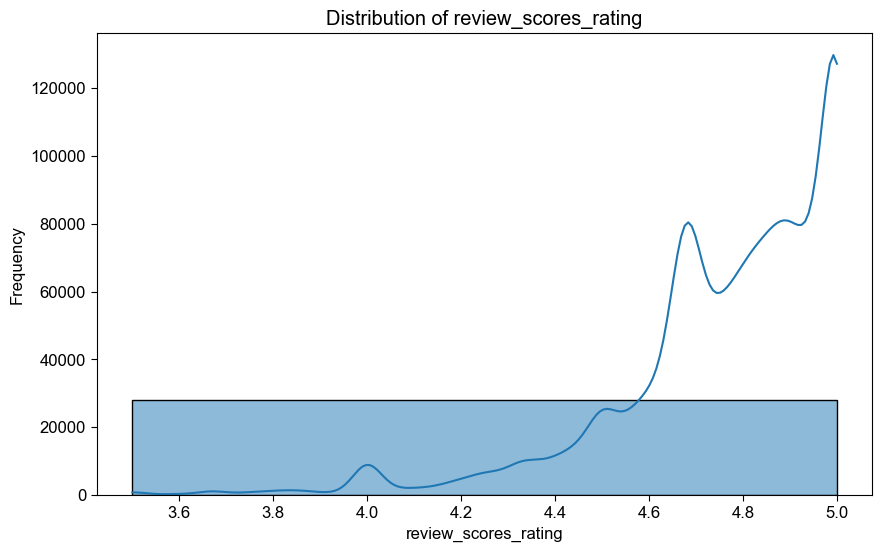

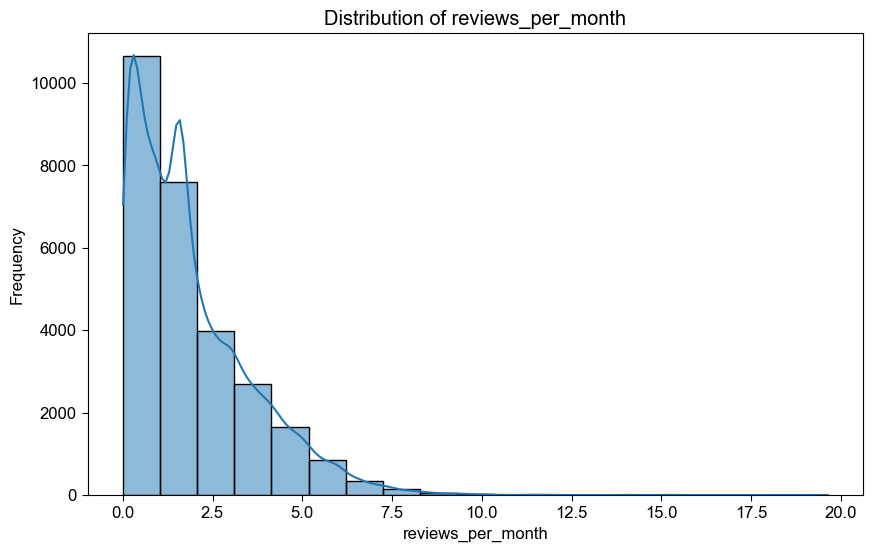

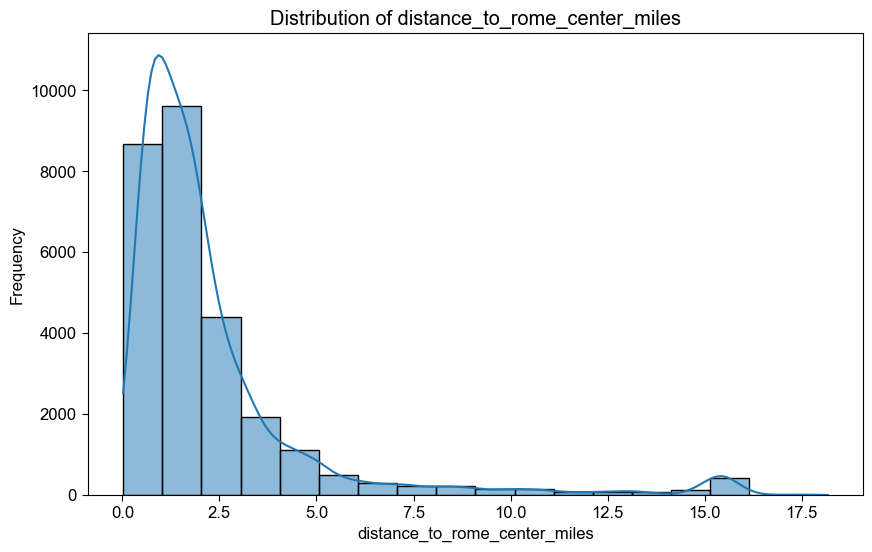

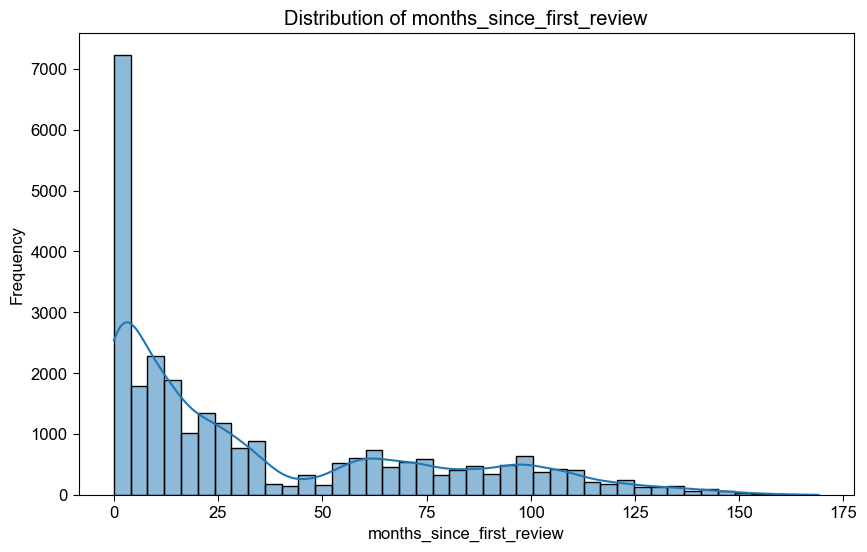

In [72]:
# Selecting only numeric columns
numeric_cols = hotels_cleansed.select_dtypes(include=['number']).columns

# Creating histograms for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    
    # Automatically determine bin width based on IQR (Interquartile Range)
    q25, q75 = np.percentile(hotels_cleansed[col].dropna(), [25, 75])
    bin_width = 2 * (q75 - q25) * len(hotels_cleansed[col]) ** (-1/3)  # Freedman-Diaconis rule
    bin_width = max(bin_width, 1)  # Ensure bin width is reasonable
    
    sns.histplot(hotels_cleansed[col], bins=int((hotels_cleansed[col].max() - hotels_cleansed[col].min()) / bin_width), kde=True)
    
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
    plt.show()


<span style="font-size: 18px;">**All numeric variables except review_scores_rating seem left skewed with long right tail. We need log transformation for these. However, some of these are not multiplicative in nature and it does not make sense to take log of those, such as accommodates or number of reviews. The multiplicative effect of number of reviews would be captured in reviews per month more accurately**

In [74]:

hotels_cleansed["ln_price"] = np.log(hotels_cleansed["price"])
hotels_cleansed["ln_minimum_nights"] = np.log(hotels_cleansed["minimum_nights"] + 1) # to adjust for log(0) 
hotels_cleansed["ln_reviews_per_month"] = np.log(hotels_cleansed["reviews_per_month"])
hotels_cleansed["ln_distance_to_rome_center_miles"] = np.log(hotels_cleansed["distance_to_rome_center_miles"])
hotels_cleansed["ln_months_since_first_review"] = np.log(hotels_cleansed["months_since_first_review"] + 0.1)  # to adjust for log(0) 


<span style="font-size: 18px;">**Distribution of log distributed variables**

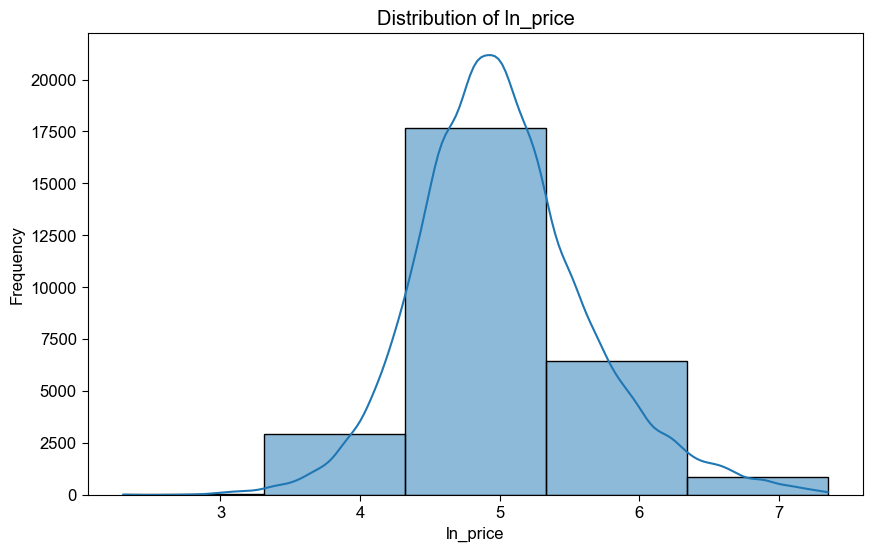

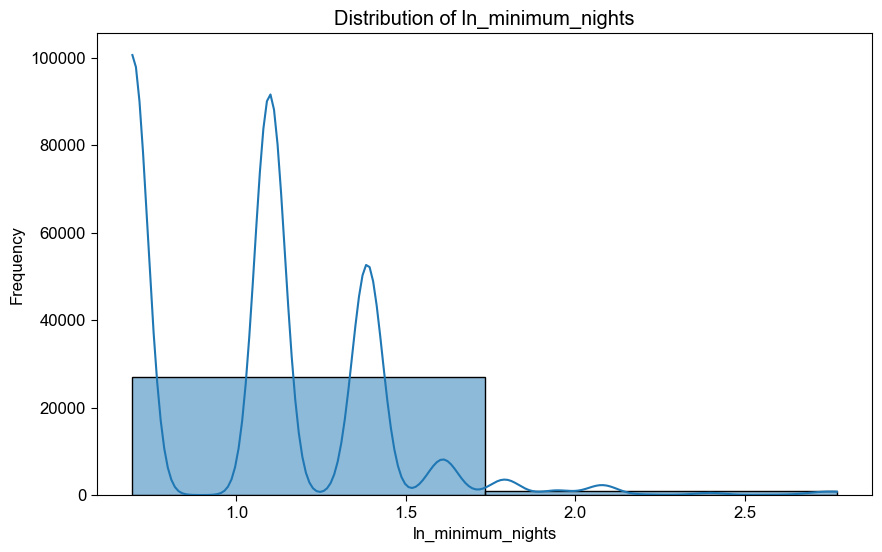

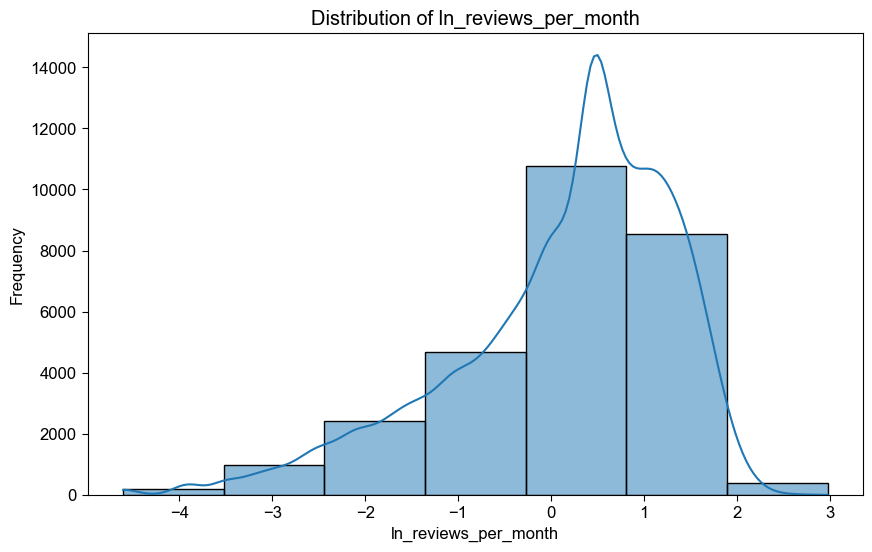

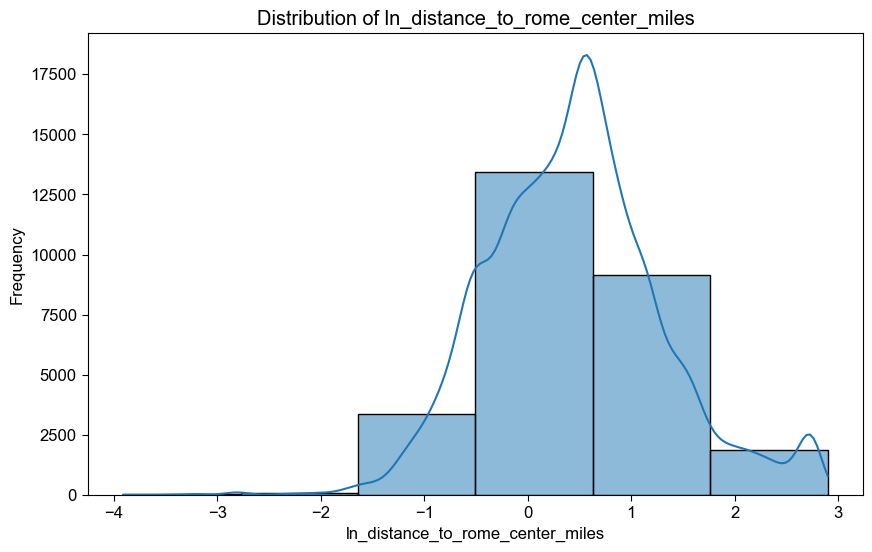

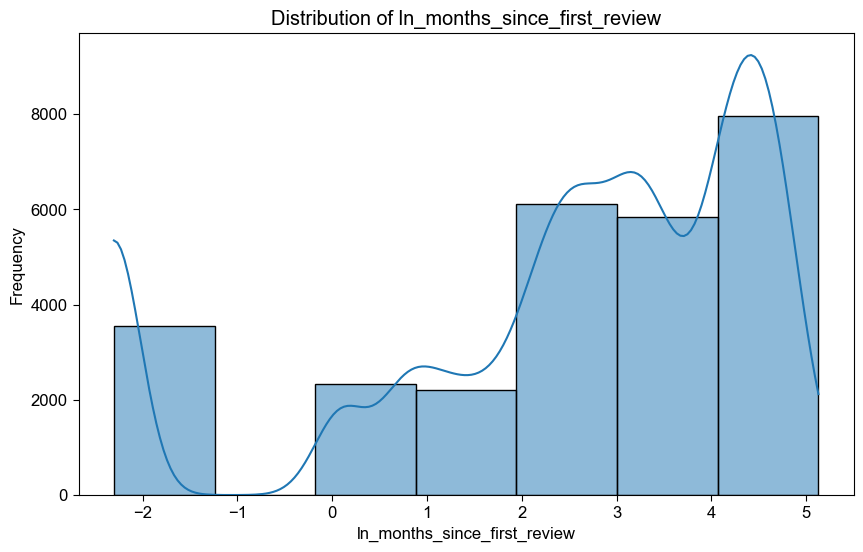

In [76]:
numeric_cols = hotels_cleansed[['ln_price','ln_minimum_nights','ln_reviews_per_month','ln_distance_to_rome_center_miles','ln_months_since_first_review']].columns

# Creating histograms for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    
    # Automatically determine bin width based on IQR (Interquartile Range)
    q25, q75 = np.percentile(hotels_cleansed[col].dropna(), [25, 75])
    bin_width = 2 * (q75 - q25) * len(hotels_cleansed[col]) ** (-1/3)  # Freedman-Diaconis rule
    bin_width = max(bin_width, 1)  # Ensure bin width is reasonable
    
    sns.histplot(hotels_cleansed[col], bins=int((hotels_cleansed[col].max() - hotels_cleansed[col].min()) / bin_width), kde=True)
    
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
    plt.show()

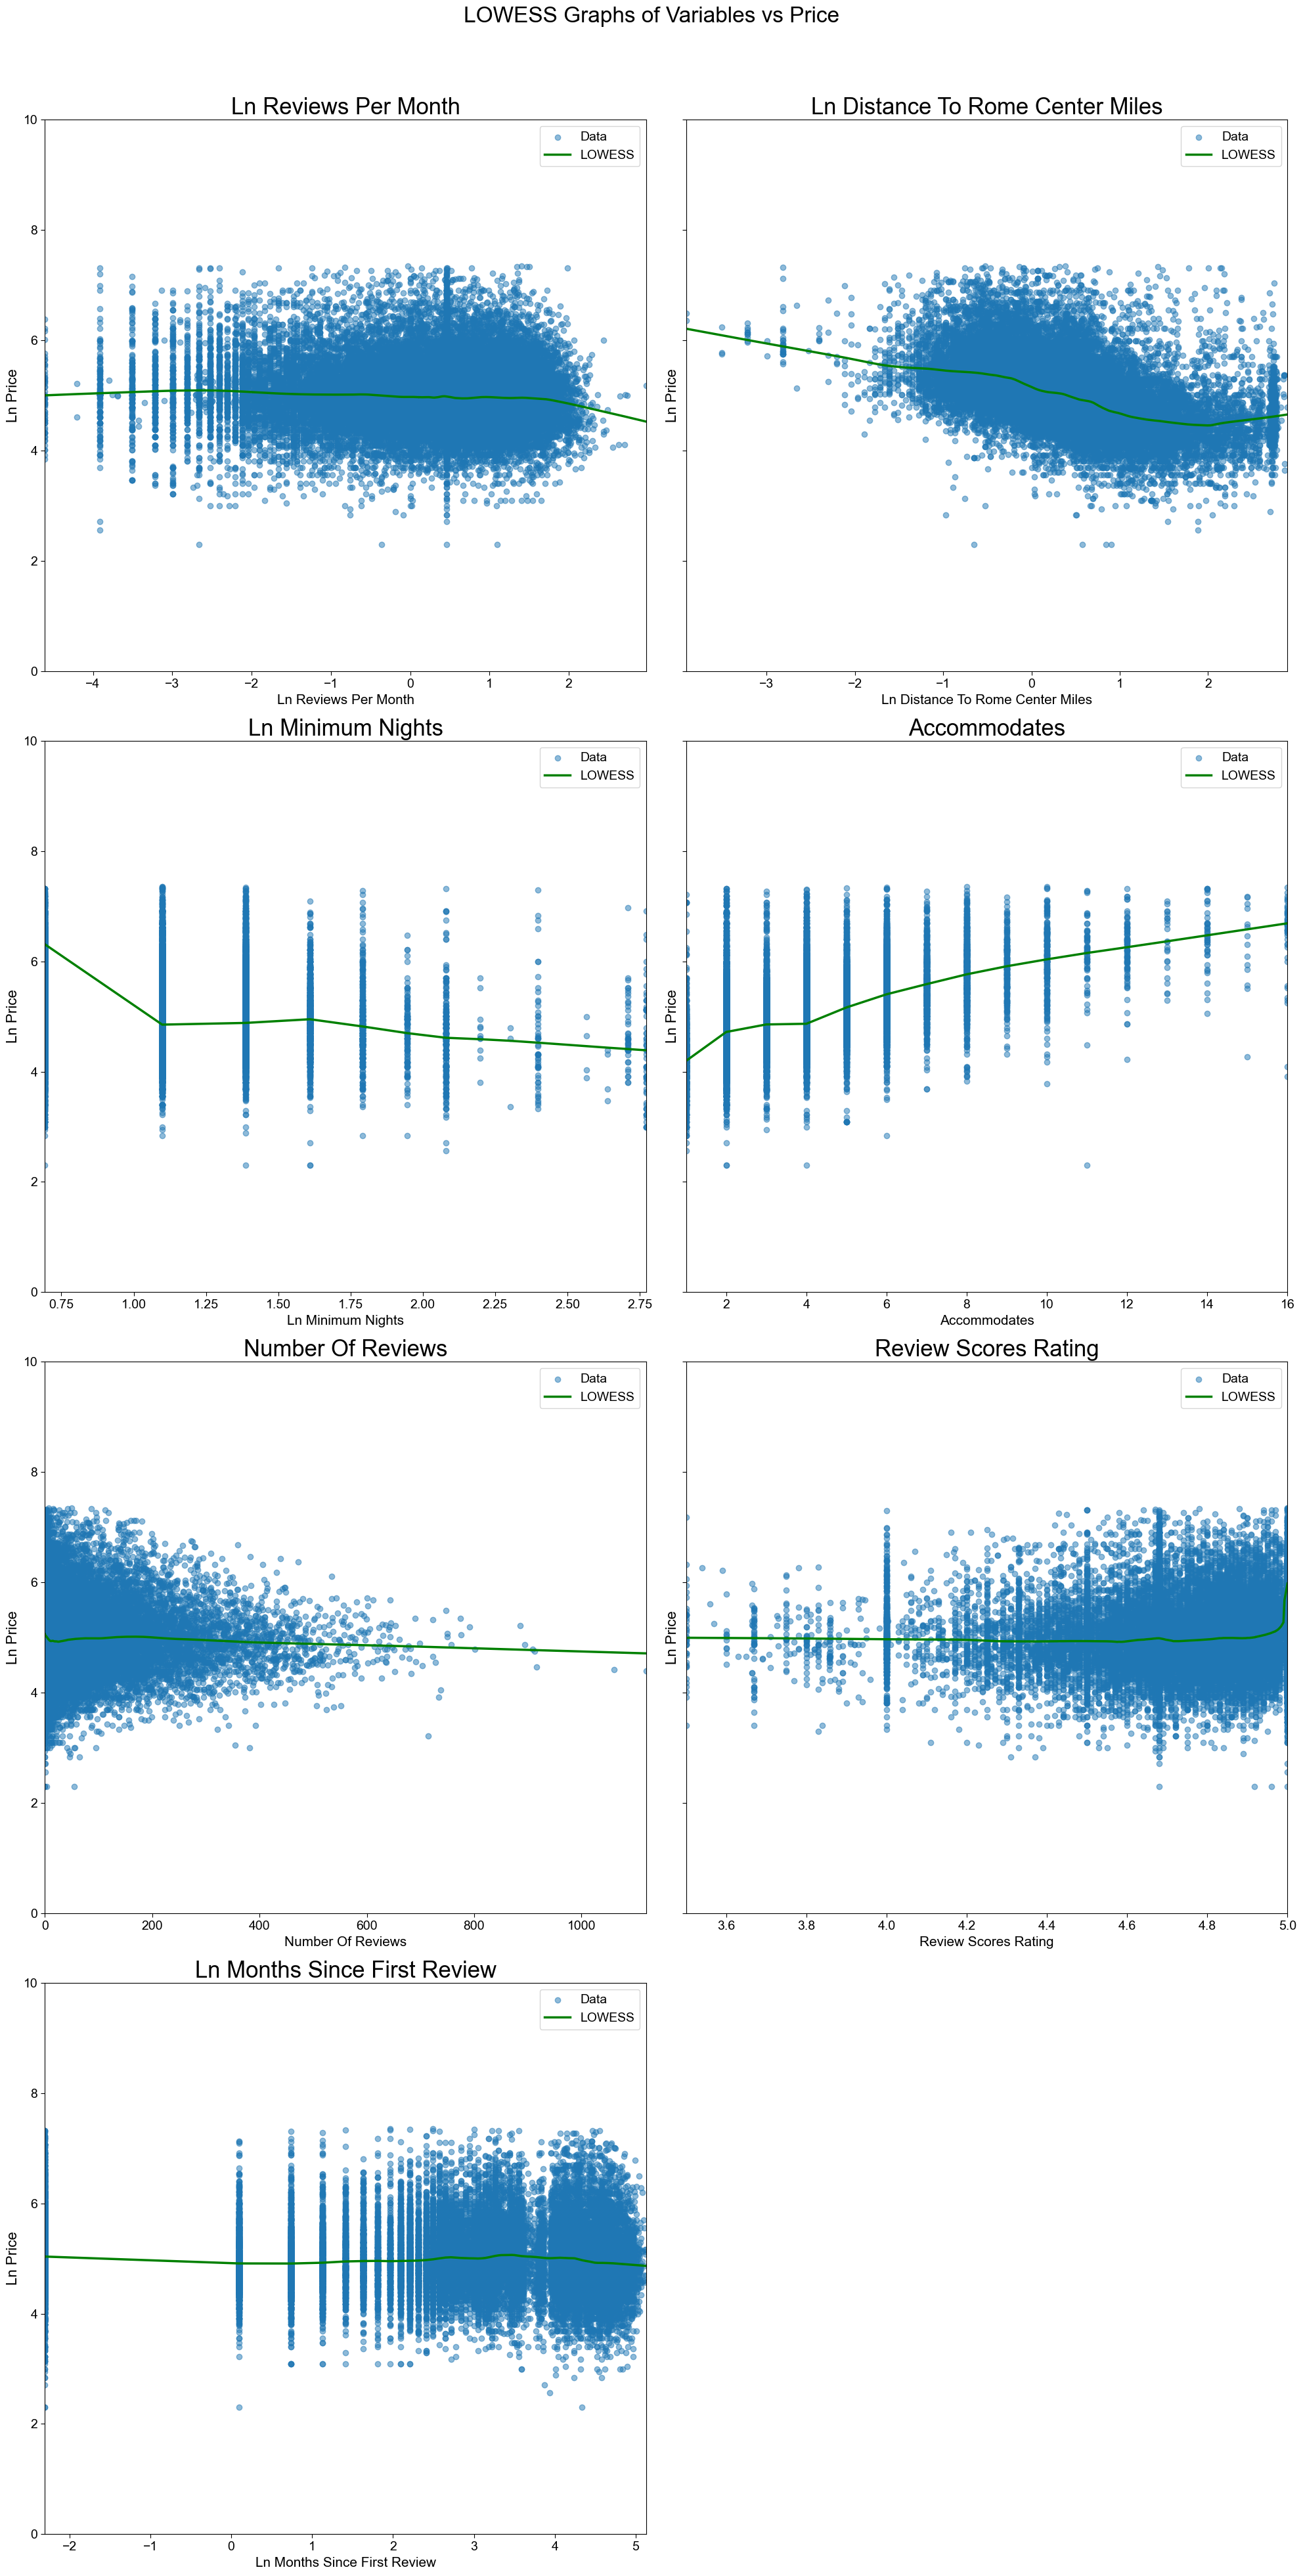

In [77]:
# Assuming df_analysis contains the table
variables = [
    'ln_reviews_per_month',
    'ln_distance_to_rome_center_miles',
    'ln_minimum_nights',
    'accommodates',	
    'number_of_reviews',
    'review_scores_rating',
    'ln_months_since_first_review'
]

# Set up subplots: 2 columns and as many rows as needed
n_cols = 2
n_rows = -(-len(variables) // n_cols)  # Ceiling division to determine rows
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 10), sharey=True)
axes = axes.flatten()

# Loop through each variable and create LOWESS plots
for i, var in enumerate(variables):
    ax = axes[i]
    
    # Apply LOWESS smoothing
    lowess = sm.nonparametric.lowess(
        hotels_cleansed['ln_price'],
        hotels_cleansed[var],
        frac=0.15  # Adjust the smoothing parameter as needed
    )
    
    # Scatterplot of original data
    ax.scatter(hotels_cleansed[var], hotels_cleansed['ln_price'], alpha=0.5, label='Data')
    
    # Plot LOWESS smoothed line
    ax.plot(lowess[:, 0], lowess[:, 1], color='green', label='LOWESS', linewidth=2.5)
    
    # Dynamically set x-axis range
    x_min, x_max = hotels_cleansed[var].min(), hotels_cleansed[var].max()
    ax.set_xlim(x_min, x_max)
    
    ax.set_title(var.replace('_', ' ').title(), fontsize=25)
    ax.set_xlabel(var.replace('_', ' ').title(), fontsize=15)
    ax.set_ylabel('Ln Price', fontsize=16)
    ax.set_ylim(0, 10)  # Adjusted to match the actual range of happiness_score
    ax.legend(fontsize=14)
    ax.tick_params(axis='x', labelsize=14)  # Increase font size for x-axis values
    ax.tick_params(axis='y', labelsize=14)  # Increase font size for y-axis value

# Hide any unused axes
for i in range(len(variables), len(axes)):
    axes[i].axis('off')

# Adjust layout and add title
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('LOWESS Graphs of Variables vs Price', fontsize=24, y=0.98)
plt.show()


<span style="font-size: 18px;">**Distance to City Center, Accommodation space, minimum nights and somewhat review scores rating tend to have an impact on price. Number of reviews or reviews per month, months since last review do not show a significant relationship. We would continue with out them in the model. It seems linear fits or in case of minimum nights spline transformations would be enough for using these features**

<span style="font-size: 18px;">**Creating spline variables for ln_minimum_nights with knot at 1.1 as seen from graph**

In [80]:
knot = 1.1  # The knot position

hotels_cleansed['log_minimum_nights_spline1'] = np.minimum(1.1, hotels_cleansed["ln_minimum_nights"])  # First part
hotels_cleansed['log_minimum_nights_spline2'] = np.maximum(0, hotels_cleansed["ln_minimum_nights"] - knot)  # Second part

<span style="font-size: 18px;">**NUMERIC FEATURES SELECTED FOR FURTHER MODELLING PRICE:\
\
ACCOMMODATES
\
LN_MINIMUM_NIGHTS (also as spline)
\
LN_DISTANCE_TO_ROME_CENTER_MILES
\
REVIEW SCORE RATINGS**

In [82]:
hotels_cleansed.drop(['number_of_reviews','months_since_first_review','reviews_per_month','ln_reviews_per_month','ln_months_since_first_review'], axis = 1, inplace = True)

### Analyzing Categorical Variables - Feature Engineering, Interactions and Selection

<span style="font-size: 18px;">**Identifying different amenities and using domain knowledge to pick price difference creating amenities. Creating boolean columns for their presence/absence in the listing**

In [85]:
hotels_cleansed.dtypes

id                                   object
host_is_superhost                    object
neighbourhood_cleansed               object
room_type                            object
accommodates                          int64
amenities                            object
price                               float64
minimum_nights                        int64
review_scores_rating                float64
distance_to_rome_center_miles       float64
ln_price                            float64
ln_minimum_nights                   float64
ln_distance_to_rome_center_miles    float64
log_minimum_nights_spline1          float64
log_minimum_nights_spline2          float64
dtype: object

In [86]:
import ast  # To convert string to list

# Convert string to actual list
hotels_cleansed['amenities'] = hotels_cleansed['amenities'].apply(ast.literal_eval)

# Exploding to count
amenities_with_counts = hotels_cleansed.explode('amenities')['amenities'].value_counts()

print(amenities_with_counts)


amenities
Hair dryer                                                          25060
Wifi                                                                24941
Kitchen                                                             23489
Hot water                                                           23454
Essentials                                                          23436
                                                                    ...  
MCC shampoo                                                             1
MCC body soap                                                           1
Jbl Extreme sound system with Bluetooth and aux                         1
40 inch HDTV with Amazon Prime Video, Fire TV, standard cable           1
Housekeeping available Tuesday, Friday - available at extra cost        1
Name: count, Length: 5304, dtype: int64


In [87]:
len(amenities_with_counts)

5304

In [88]:
#Creating a map of matching amenities with categories we are defining
amenities_map = {
    'Wi_Fi': ['Wifi'],
    'Heating_Cooling': ['Air conditioning', 'Heating', 'AC unit'],
    'Kitchen_Access': ['Kitchen',  'Kitchen', 'Refrigerator', 'Microwave', 'Cooking basics', 'Oven', 'Stove', 'Dishwasher', 'Freezer', 'Coffee maker', 'Hot water kettle', 'Toaster', 'Blender', 'Rice maker', 'Fridge','stove'],
    'Washer_Dryer': ['Washer','washing machine'],
    'Parking': ['Parking'],
    'Pool_HotTub': ['Pool', 'Hot tub'],
    'Balcony_Outdoor_Space': ['Balcony', 'Outdoor','Patio','Backyard','Terrace'],
    'Pet_Friendly_Policy': ['Pet-Friendly', 'Pets allowed'],
    'Smart_TV_Streaming': ['TV', 'Smart lock']
}

# Function to map the amenities based on the list of keywords for each category

def add_amenity_columns(df, amenities_map):
    for new_column, keywords in amenities_map.items():
        # Converting both strings to lower case to do case-insensitive matching
        df[new_column] = df['amenities'].apply(
            lambda x: any(keyword.lower() in [item.lower() for item in x] for keyword in keywords)
        )
    return df

# Adding columns for the amenities
hotels_cleansed = add_amenity_columns(hotels_cleansed, amenities_map)

In [89]:
pd.set_option('display.max_colwidth', None)

print(hotels_cleansed.loc[hotels_cleansed['id'] == 90902]['amenities'])

Series([], Name: amenities, dtype: object)


<span style="font-size: 18px;">**Dropping Amenities column as we have extracted the top ones already**

In [91]:
hotels_cleansed.drop('amenities', axis = 1, inplace = True)

In [92]:
# Selecting categorical columns (excluding price)
categorical_cols = hotels_cleansed.select_dtypes(include=["object", "category","bool"]).columns
categorical_cols

# Printing number of unique values per categorical column
for col in categorical_cols:
    print(f"{col}: {hotels_cleansed[col].nunique()} unique values")


id: 27989 unique values
host_is_superhost: 2 unique values
neighbourhood_cleansed: 15 unique values
room_type: 4 unique values
Wi_Fi: 2 unique values
Heating_Cooling: 2 unique values
Kitchen_Access: 2 unique values
Washer_Dryer: 2 unique values
Parking: 1 unique values
Pool_HotTub: 2 unique values
Balcony_Outdoor_Space: 2 unique values
Pet_Friendly_Policy: 2 unique values
Smart_TV_Streaming: 2 unique values


<span style="font-size: 18px;">**Dropping Parking as it has all same values**

In [94]:
hotels_cleansed.drop('Parking', axis = 1, inplace = True)

<span style="font-size: 18px;">**Checking average prices and counts for different categories for categorical variables**

In [96]:
categorical_cols = categorical_cols.drop(['id','Parking'])
categorical_cols

Index(['host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'Wi_Fi',
       'Heating_Cooling', 'Kitchen_Access', 'Washer_Dryer', 'Pool_HotTub',
       'Balcony_Outdoor_Space', 'Pet_Friendly_Policy', 'Smart_TV_Streaming'],
      dtype='object')

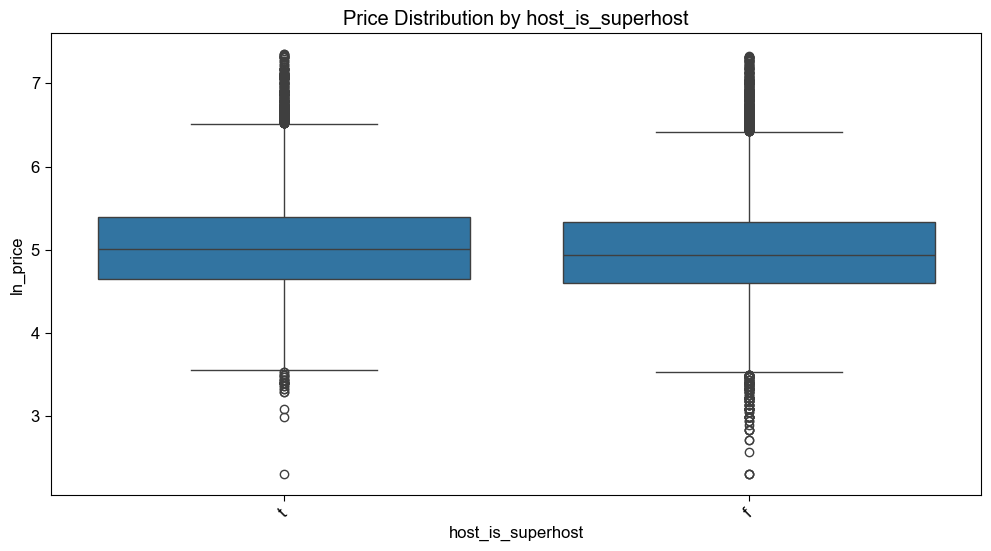

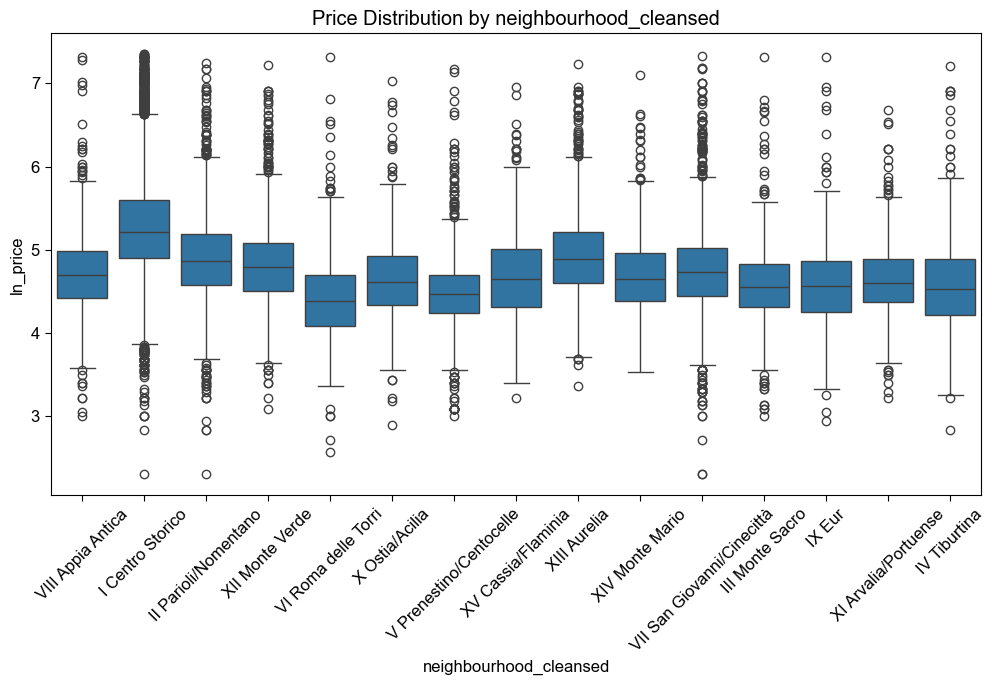

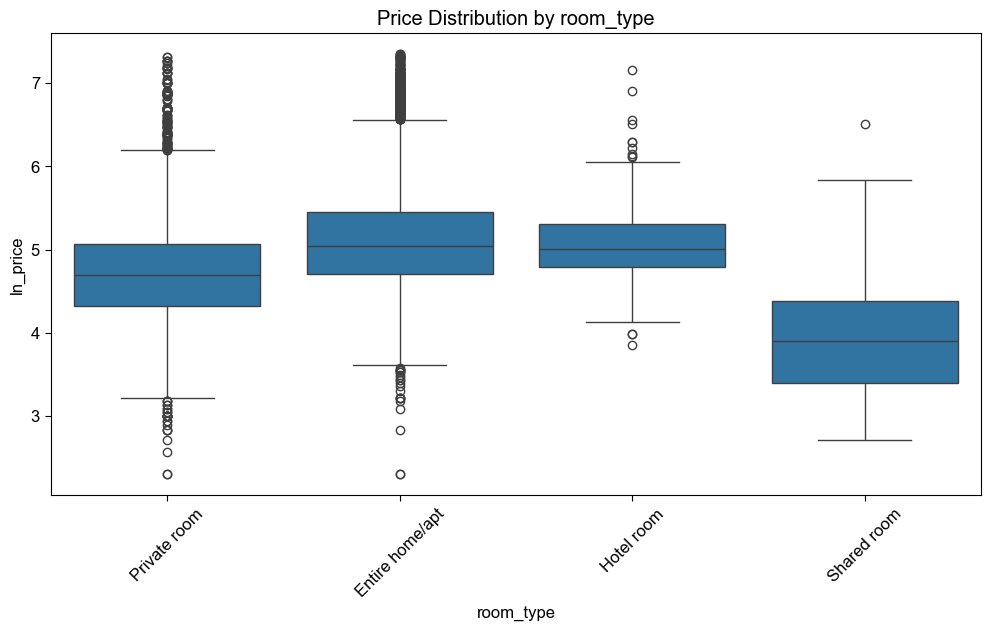

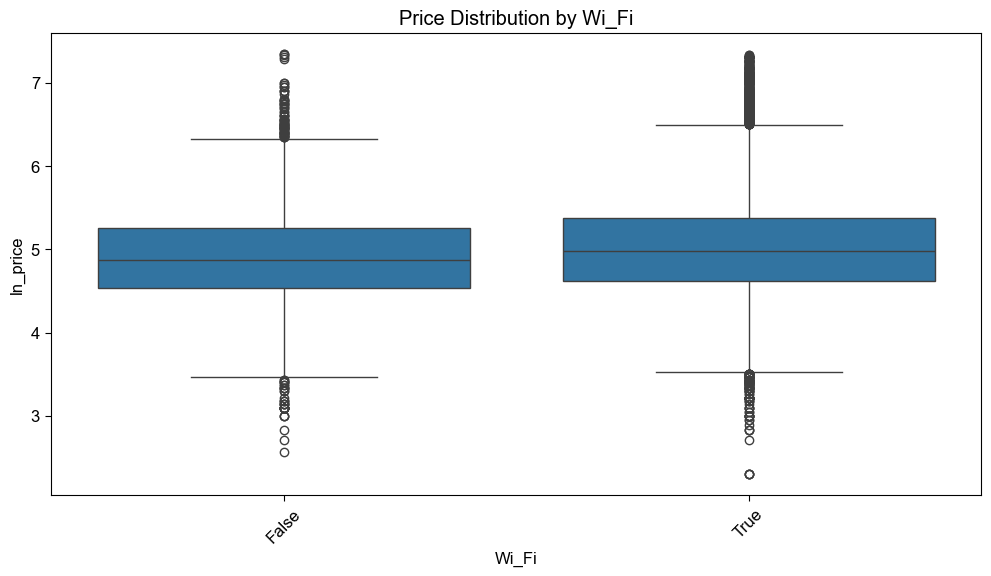

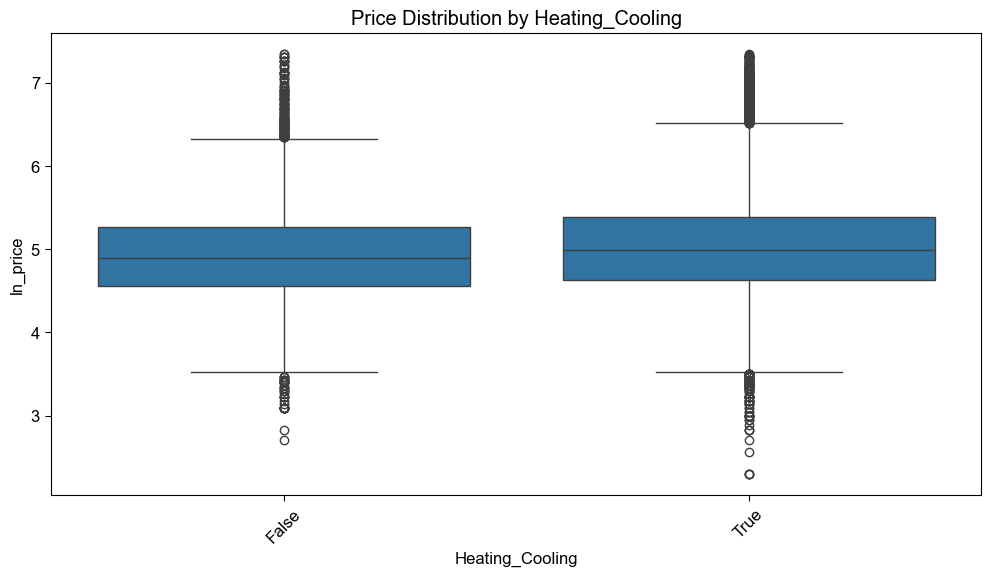

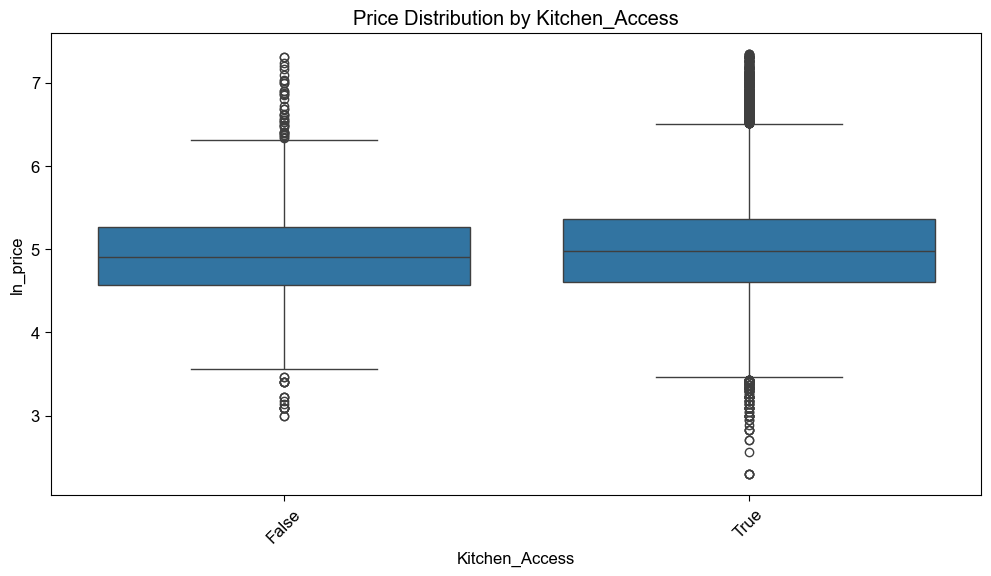

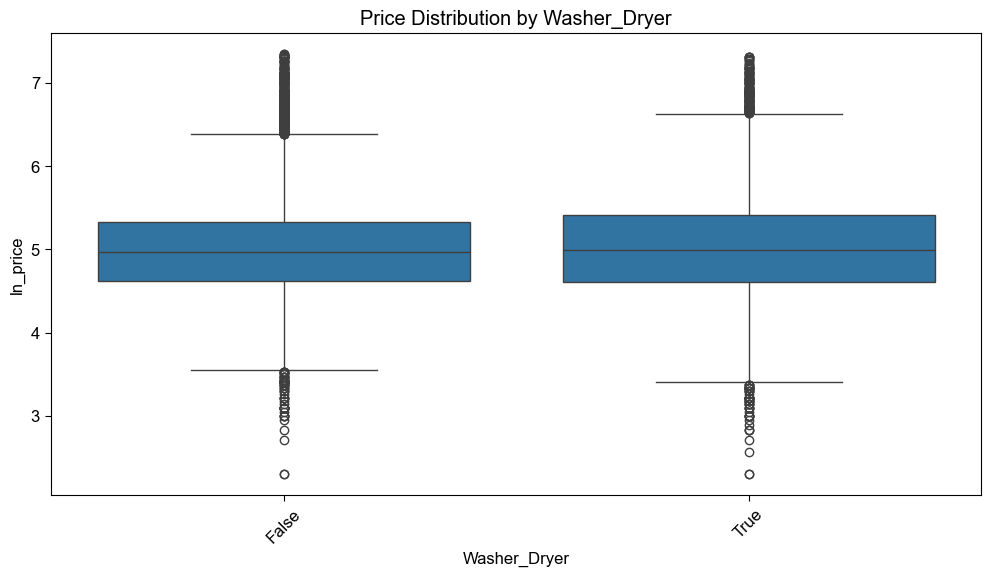

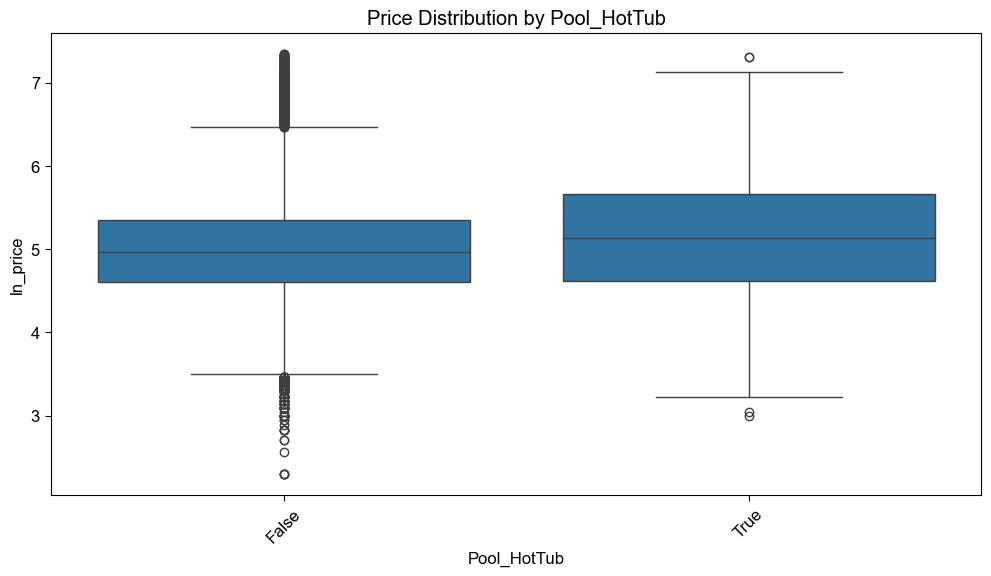

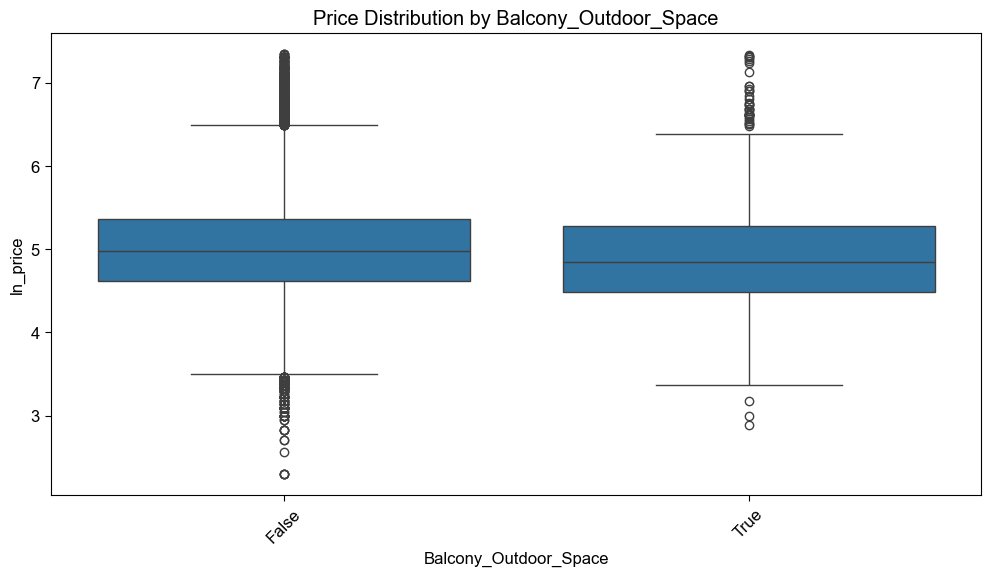

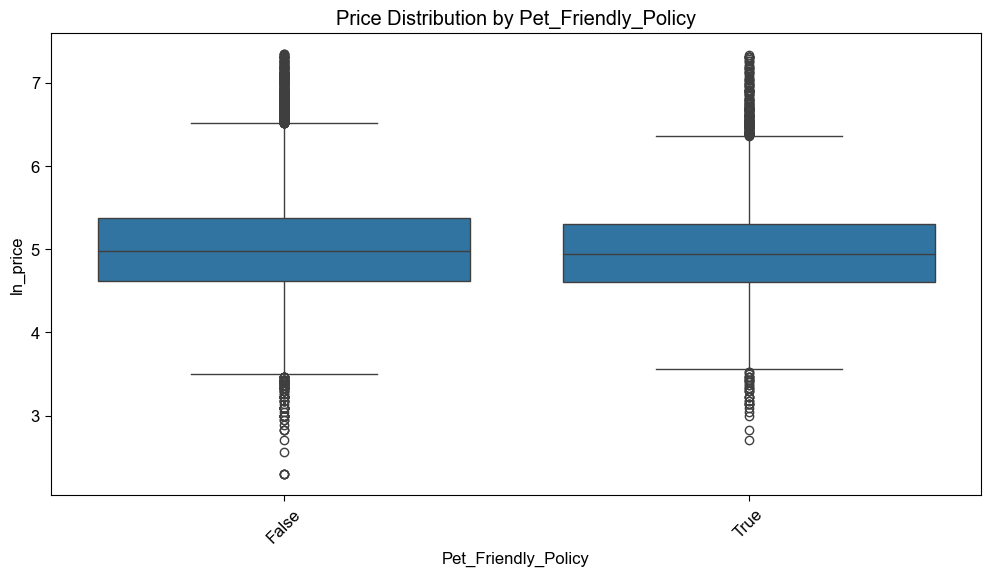

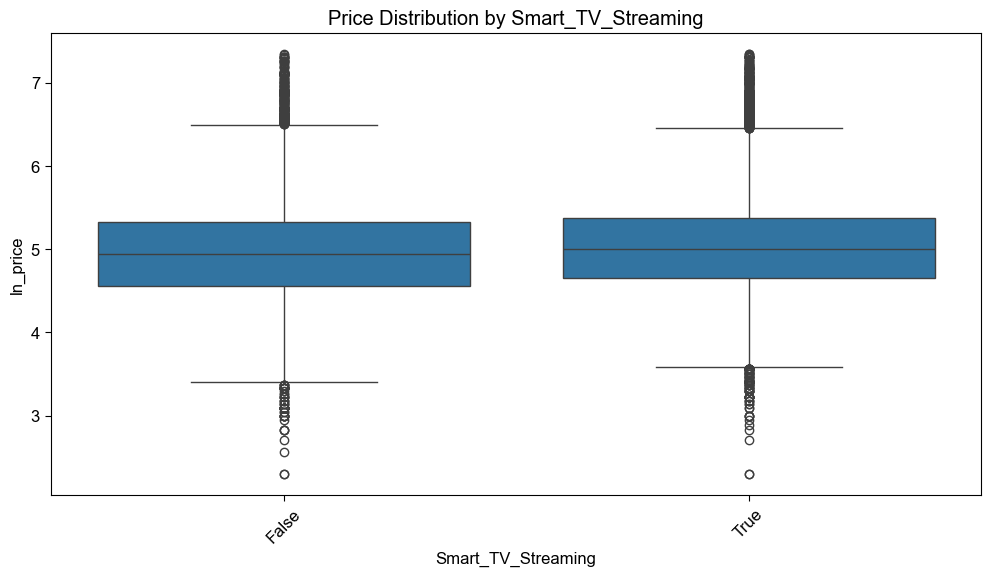

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=hotels_cleansed[col], y=hotels_cleansed["ln_price"])
    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.title(f"Price Distribution by {col}")
    plt.show()


In [98]:
for col in hotels_cleansed.select_dtypes(include=['object', 'bool']):
    if col != 'id':
        print(col)
        print(pd.DataFrame(hotels_cleansed.groupby(col).agg(count = ('id','count'), price = ('price','mean'))))

host_is_superhost
                   count       price
host_is_superhost                   
f                  17689  182.841823
t                  10300  195.199903
neighbourhood_cleansed
                            count       price
neighbourhood_cleansed                       
I Centro Storico            14582  234.432725
II Parioli/Nomentano         1871  158.378942
III Monte Sacro               499  117.472946
IV Tiburtina                  470  122.780851
IX Eur                        337  123.807122
V Prenestino/Centocelle      1263   99.808393
VI Roma delle Torri           261  110.498084
VII San Giovanni/Cinecittà   2203  137.685883
VIII Appia Antica             806  130.667494
X Ostia/Acilia                798  118.614035
XI Arvalia/Portuense          548  117.072993
XII Monte Verde              1485  144.783838
XIII Aurelia                 1805  163.531856
XIV Monte Mario               595  128.193277
XV Cassia/Flaminia            466  135.562232
room_type
                 co

<span style="font-size: 18px;">**All smaller neighbourhoods with less than 1000 rows are grouped into others as they have similar average prices**

In [100]:
grouped_neighborhood = pd.DataFrame(hotels_cleansed.groupby('neighbourhood_cleansed').agg(count = ('id','count'), price = ('price','mean'))).sort_values(by = 'count',ascending = False)
grouped_neighborhood.reset_index(inplace = True)
grouped_neighborhood.head(15)

neighbourhood_cleansed  count       price
0             I Centro Storico  14582  234.432725
1   VII San Giovanni/Cinecittà   2203  137.685883
2         II Parioli/Nomentano   1871  158.378942
3                 XIII Aurelia   1805  163.531856
4              XII Monte Verde   1485  144.783838
5      V Prenestino/Centocelle   1263   99.808393
6            VIII Appia Antica    806  130.667494
7               X Ostia/Acilia    798  118.614035
8              XIV Monte Mario    595  128.193277
9         XI Arvalia/Portuense    548  117.072993
10             III Monte Sacro    499  117.472946
11                IV Tiburtina    470  122.780851
12          XV Cassia/Flaminia    466  135.562232
13                      IX Eur    337  123.807122
14         VI Roma delle Torri    261  110.498084

In [101]:
grouped_neighborhood.loc[grouped_neighborhood['count'] < 1000, 'neighbourhood_group'] = 'Others'
grouped_neighborhood['neighbourhood_group'].fillna(grouped_neighborhood['neighbourhood_cleansed'], inplace = True)
grouped_neighborhood.head(10)

neighbourhood_cleansed  count       price         neighbourhood_group
0            I Centro Storico  14582  234.432725            I Centro Storico
1  VII San Giovanni/Cinecittà   2203  137.685883  VII San Giovanni/Cinecittà
2        II Parioli/Nomentano   1871  158.378942        II Parioli/Nomentano
3                XIII Aurelia   1805  163.531856                XIII Aurelia
4             XII Monte Verde   1485  144.783838             XII Monte Verde
5     V Prenestino/Centocelle   1263   99.808393     V Prenestino/Centocelle
6           VIII Appia Antica    806  130.667494                      Others
7              X Ostia/Acilia    798  118.614035                      Others
8             XIV Monte Mario    595  128.193277                      Others
9        XI Arvalia/Portuense    548  117.072993                      Others

In [102]:
hotels_cleansed = hotels_cleansed.merge(grouped_neighborhood[['neighbourhood_cleansed','neighbourhood_group']], how = 'left', left_on = 'neighbourhood_cleansed', right_on = 'neighbourhood_cleansed')

In [103]:
hotels_cleansed.groupby('neighbourhood_group').agg(count = ('id','count'), price = ('price','mean')).sort_values(by = 'count',ascending = False)

count       price
neighbourhood_group                          
I Centro Storico            14582  234.432725
Others                       4780  123.528033
VII San Giovanni/Cinecittà   2203  137.685883
II Parioli/Nomentano         1871  158.378942
XIII Aurelia                 1805  163.531856
XII Monte Verde              1485  144.783838
V Prenestino/Centocelle      1263   99.808393

In [104]:
hotels_cleansed.drop('neighbourhood_cleansed', axis = 1, inplace = True)

In [105]:
hotels_cleansed.head()

id host_is_superhost        room_type  accommodates  price  \
0   2737                 t     Private room             1   56.0   
1  88428                 t  Entire home/apt             3  213.0   
2   3079                 f  Entire home/apt             4  140.0   
3  90666                 t  Entire home/apt             4  110.0   
4  90902                 f  Entire home/apt             4  284.0   

   minimum_nights  review_scores_rating  distance_to_rome_center_miles  \
0               7                  4.80                           1.74   
1               2                  4.74                           0.64   
2               7                  4.53                           0.46   
3               4                  4.91                           1.62   
4               5                  4.06                           0.79   

   ln_price  ln_minimum_nights  ...  log_minimum_nights_spline2  Wi_Fi  \
0  4.025352           2.079442  ...                    0.979442   True   
1  5.361292           1.098612  ...                    0.000000   True   
2  4.941642           2.079442  ...                    0.979442   True   
3  4.700480           1.609438  ...                    0.509438   True   
4  5.648974           1.791759  ...                    0.691759   True   

   Heating_Cooling  Kitchen_Access  Washer_Dryer  Pool_HotTub  \
0             True            True          True         True   
1             True            True         False        False   
2             True            True         False        False   
3             True            True         False        False   
4             True            True          True        False   

   Balcony_Outdoor_Space  Pet_Friendly_Policy  Smart_TV_Streaming  \
0                  False                False               False   
1                  False                False               False   
2                  False                False               False   
3                  False                False               False   
4                  False                False               False   

   neighbourhood_group  
0               Others  
1     I Centro Storico  
2     I Centro Storico  
3     I Centro Storico  
4     I Centro Storico  

[5 rows x 22 columns]

### Looking for Interactions - As a Data Scientist we will think about the interactions that make sense Intiutively and Statistically

In [107]:
hotels_cleansed.dtypes

id                                   object
host_is_superhost                    object
room_type                            object
accommodates                          int64
price                               float64
minimum_nights                        int64
review_scores_rating                float64
distance_to_rome_center_miles       float64
ln_price                            float64
ln_minimum_nights                   float64
ln_distance_to_rome_center_miles    float64
log_minimum_nights_spline1          float64
log_minimum_nights_spline2          float64
Wi_Fi                                  bool
Heating_Cooling                        bool
Kitchen_Access                         bool
Washer_Dryer                           bool
Pool_HotTub                            bool
Balcony_Outdoor_Space                  bool
Pet_Friendly_Policy                    bool
Smart_TV_Streaming                     bool
neighbourhood_group                  object
dtype: object

<span style="font-size: 18px;">**Creating a helper function to graph combination of categories by Price**

In [109]:
def plot_categorical_mean_price(df, category1, category2, price_col='ln_price'):
    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=df, 
        x=category1, 
        y=price_col, 
        hue=category2, 
        ci="sd",  # Standard deviation error bars
        palette="dark"
    )
    
    plt.xlabel(category1.replace('_', ' ').title())
    plt.ylabel(f"Mean {price_col.title()}")
    plt.title(f"Mean {price_col.title()} by {category1.title()} and {category2.title()}")
    plt.legend(title=category2.replace('_', ' ').title(), loc='upper right')
    
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



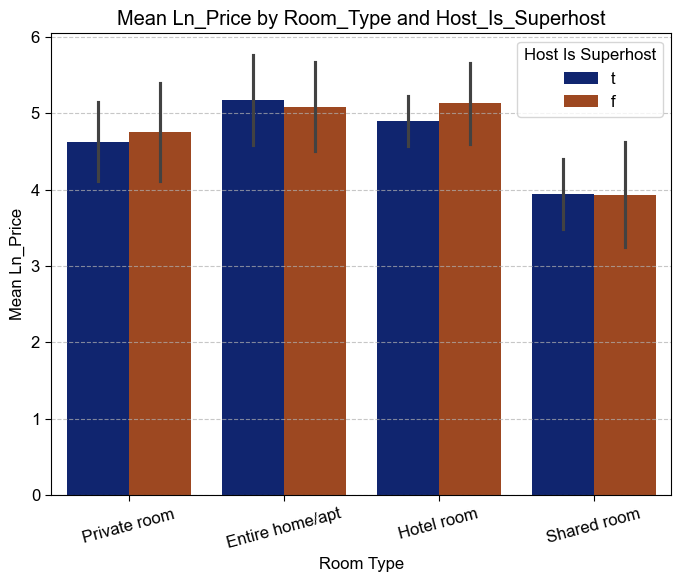

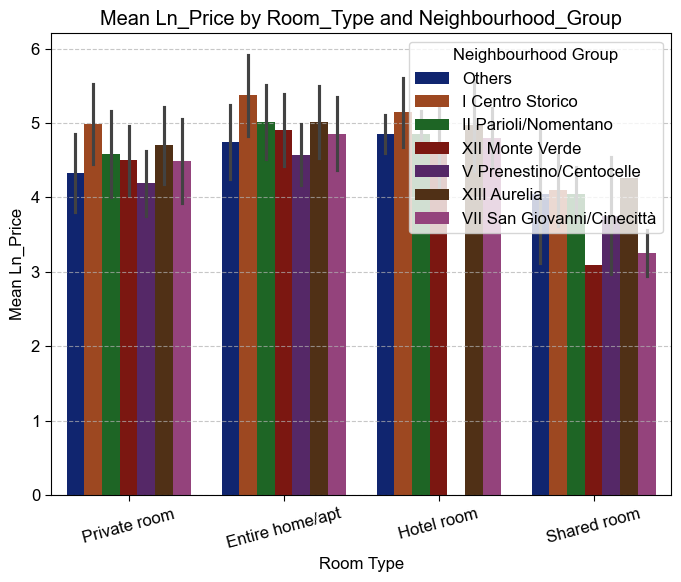

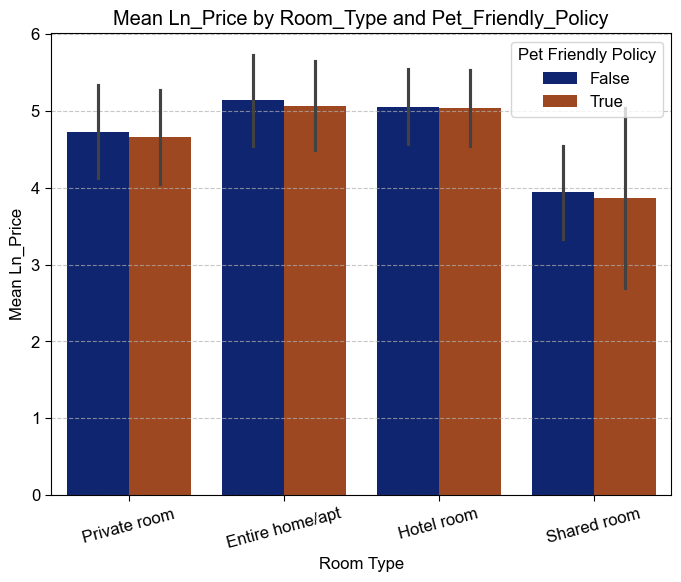

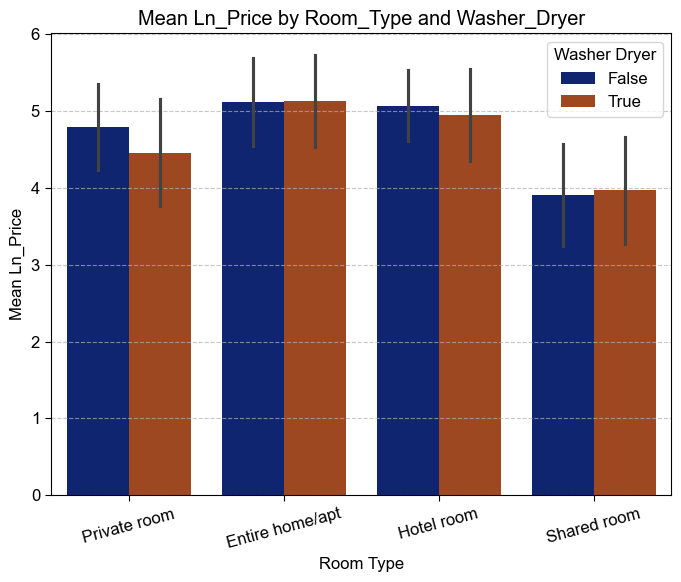

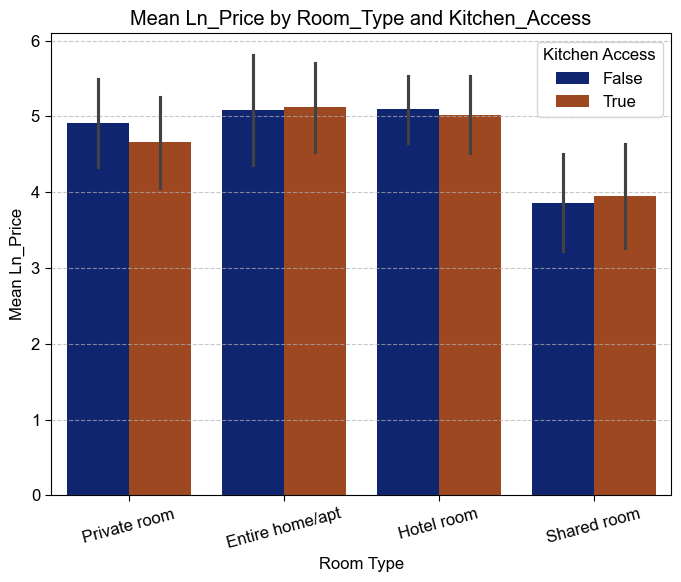

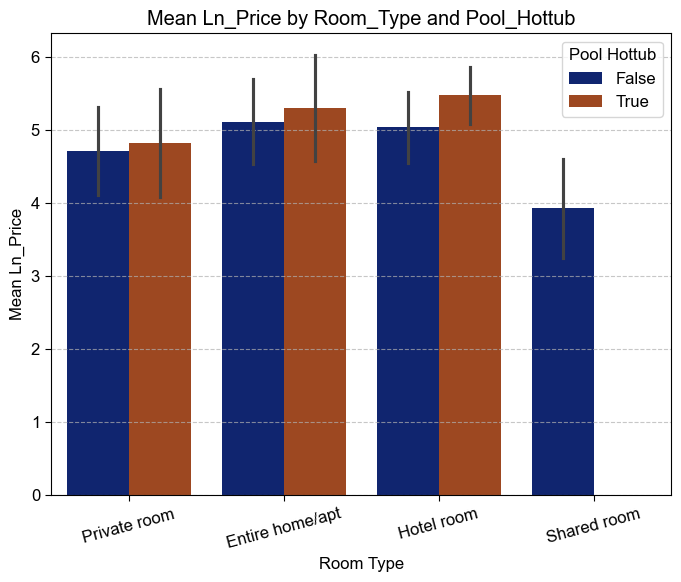

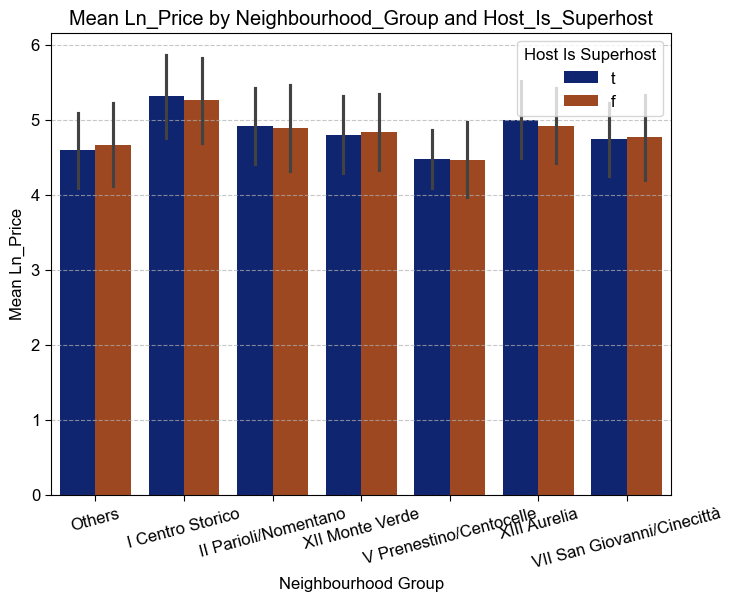

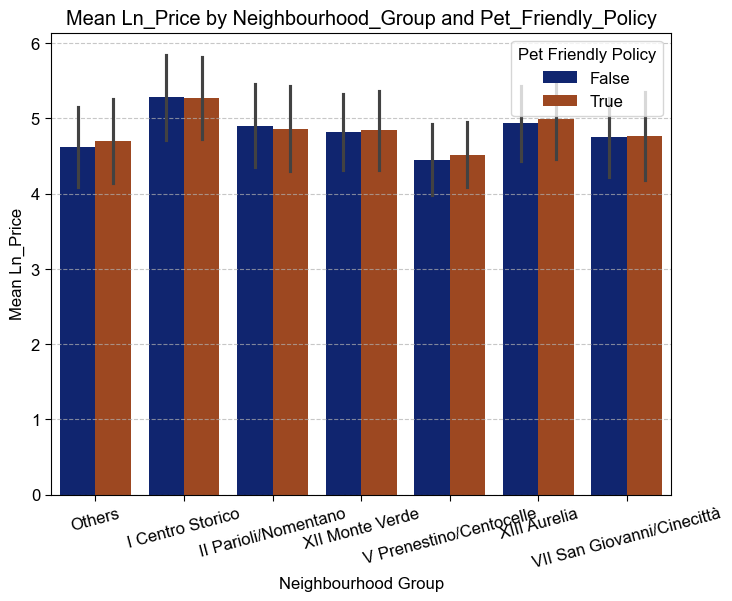

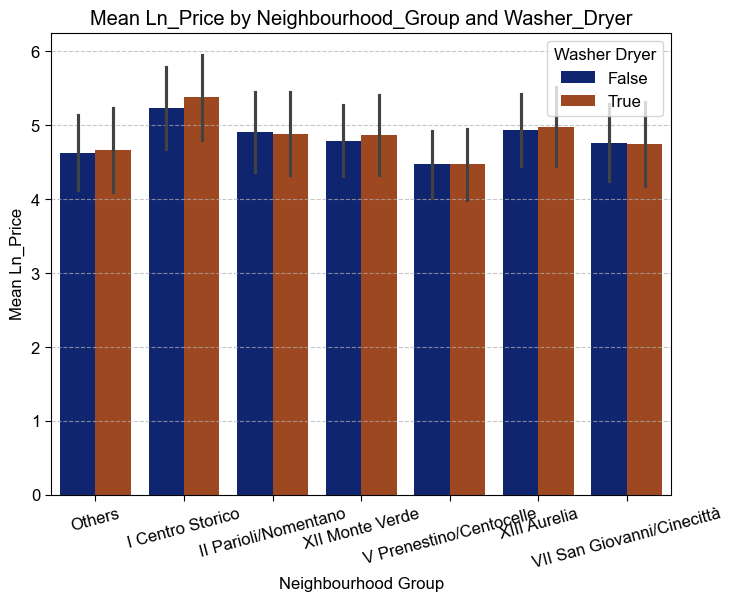

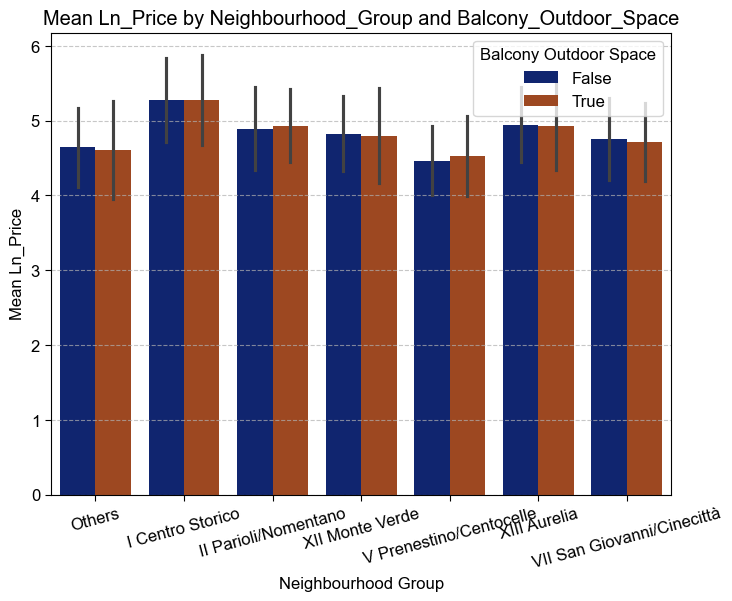

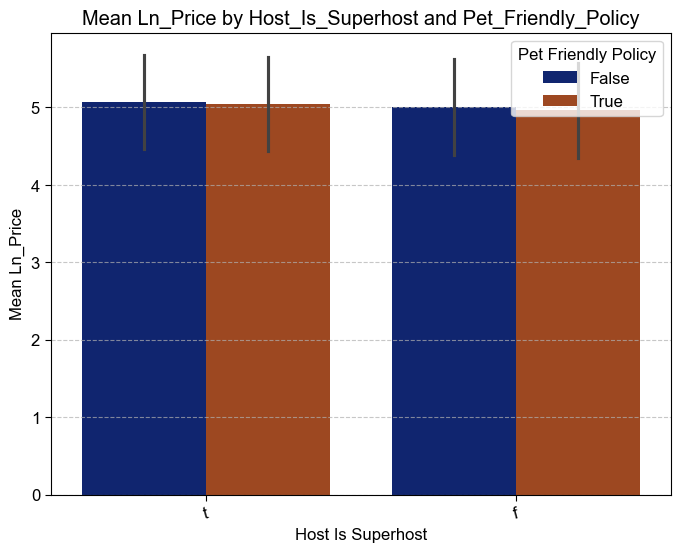

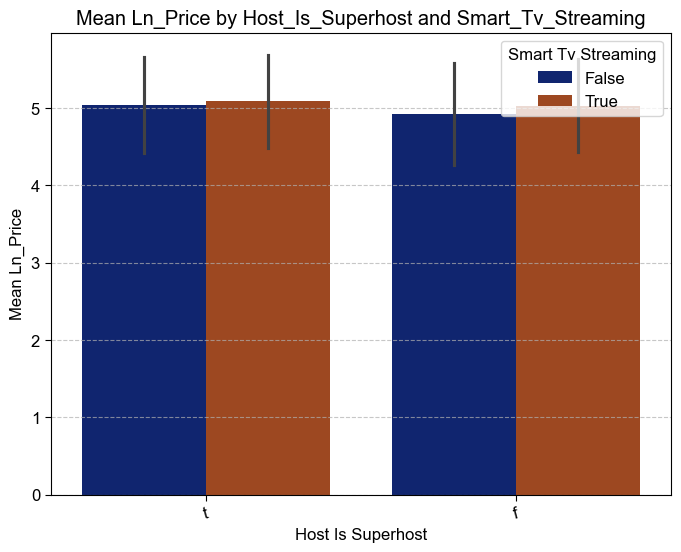

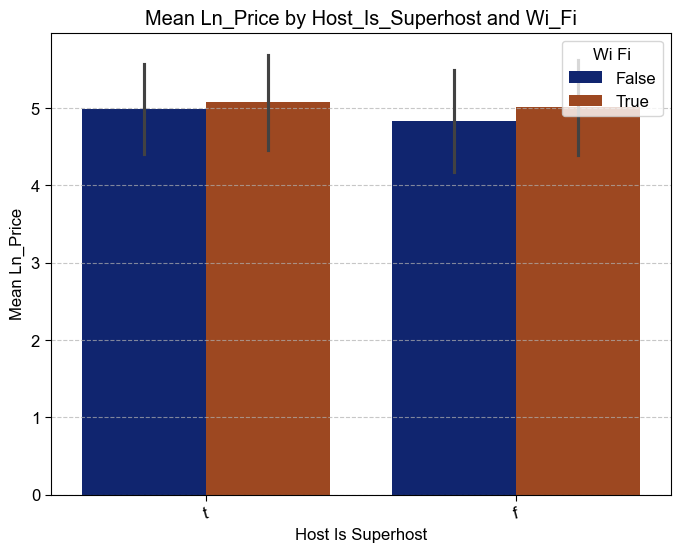

In [110]:
plot_categorical_mean_price(hotels_cleansed, 'room_type','host_is_superhost','ln_price')
plot_categorical_mean_price(hotels_cleansed, 'room_type','neighbourhood_group','ln_price')
plot_categorical_mean_price(hotels_cleansed, 'room_type','Pet_Friendly_Policy','ln_price')
plot_categorical_mean_price(hotels_cleansed, 'room_type','Washer_Dryer','ln_price') 
plot_categorical_mean_price(hotels_cleansed, 'room_type','Kitchen_Access','ln_price') 
plot_categorical_mean_price(hotels_cleansed, 'room_type','Pool_HotTub','ln_price') 
plot_categorical_mean_price(hotels_cleansed, 'neighbourhood_group','host_is_superhost','ln_price')
plot_categorical_mean_price(hotels_cleansed, 'neighbourhood_group','Pet_Friendly_Policy','ln_price')
plot_categorical_mean_price(hotels_cleansed, 'neighbourhood_group','Washer_Dryer','ln_price')
plot_categorical_mean_price(hotels_cleansed, 'neighbourhood_group','Balcony_Outdoor_Space','ln_price')
plot_categorical_mean_price(hotels_cleansed, 'host_is_superhost','Pet_Friendly_Policy','ln_price')
plot_categorical_mean_price(hotels_cleansed, 'host_is_superhost','Smart_TV_Streaming','ln_price')
plot_categorical_mean_price(hotels_cleansed, 'host_is_superhost','Wi_Fi','ln_price')



<span style="font-size: 18px;">**Room type feature with host is superhost, Room type with washer dryer and Room type with Neighborhood group shows some sembelance of interaction effect. We will take this forward**

## Models Creation and Fitting

<span style="font-size: 18px;">**We now create categories of variables to input into the OLS model**

In [114]:
numeric_features = ("accommodates","ln_distance_to_rome_center_miles","review_scores_rating")
categorical_features = ("host_is_superhost", "room_type","neighbourhood_group")
spline_lev = ("log_minimum_nights_spline1", "log_minimum_nights_spline2")
amenities = ("Wi_Fi","Heating_Cooling","Washer_Dryer","Pet_Friendly_Policy","Smart_TV_Streaming", "Kitchen_Access","Balcony_Outdoor_Space","Pool_HotTub")
interactions = ("room_type*host_is_superhost", "room_type*Washer_Dryer", "room_type*neighbourhood_group", "room_type*Kitchen_Access")

### Creating train, test and hold out set

Setting seed for reproducibility

In [117]:
np.random.seed(42)

In [119]:
from sklearn.model_selection import train_test_split

work_set, holdout_set = train_test_split(hotels_cleansed, test_size=0.2, random_state=42)  # 20% holdout


print(f"Train: {work_set.shape},  Holdout: {holdout_set.shape}")

Train: (22391, 22),  Holdout: (5598, 22)


### Fitting OLS Models

In [122]:
model1 = "~ ln_distance_to_rome_center_miles"
model2 = "~" + " + ".join(numeric_features)
model3 = "~" + " + ".join(numeric_features + categorical_features)
model4 = "~" + " + ".join(numeric_features + categorical_features + spline_lev)
model5 = "~" + " + ".join(numeric_features + categorical_features + spline_lev + amenities)
model6 = "~" + " + ".join(numeric_features + categorical_features + spline_lev + amenities + interactions)


model_equations = [
    model1,
    model2,
    model3,
    model4,
    model5,
    model6
]

In [124]:
n_folds = 5

<span style="font-size: 18px;">**OLS Crossvalidator is a very useful function. It has statsmodels.formula.api.ols() running in the background via patsy. This automatically handles the one hot encoding of categorical variables! It also drops one of the categories automatically inside a feature to act as reference**

In [127]:

training_times = []  # Storing training times

cv_list = []
for model in model_equations:
    start_time = time.time()  # Starting timing
    
    cv_result = ols_crossvalidator("ln_price" + model, work_set, n_folds)
    
    end_time = time.time()  # Ending timing
    training_times.append(end_time - start_time)  # Calculating training time
    
    cv_list.append(cv_result)

In [128]:
compare_model_fits = (
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(cv_list))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
        Training_Time=training_times  # Add training time column
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE", "Training_Time"])
)

compare_model_fits

Model  Coefficients  R-squared    BIC  Training RMSE  Test RMSE  \
0    M1             2       0.23  35786           0.54       0.54   
1    M2             4       0.48  27225           0.44       0.44   
2    M3            14       0.50  26248           0.43       0.43   
3    M4            16       0.51  25866           0.43       0.43   
4    M5            24       0.52  25653           0.43       0.43   
5    M6            50       0.52  25676           0.42       0.43   

   Training_Time  
0       0.134641  
1       0.146647  
2       2.505262  
3       2.440387  
4       2.432498  
5       2.823411

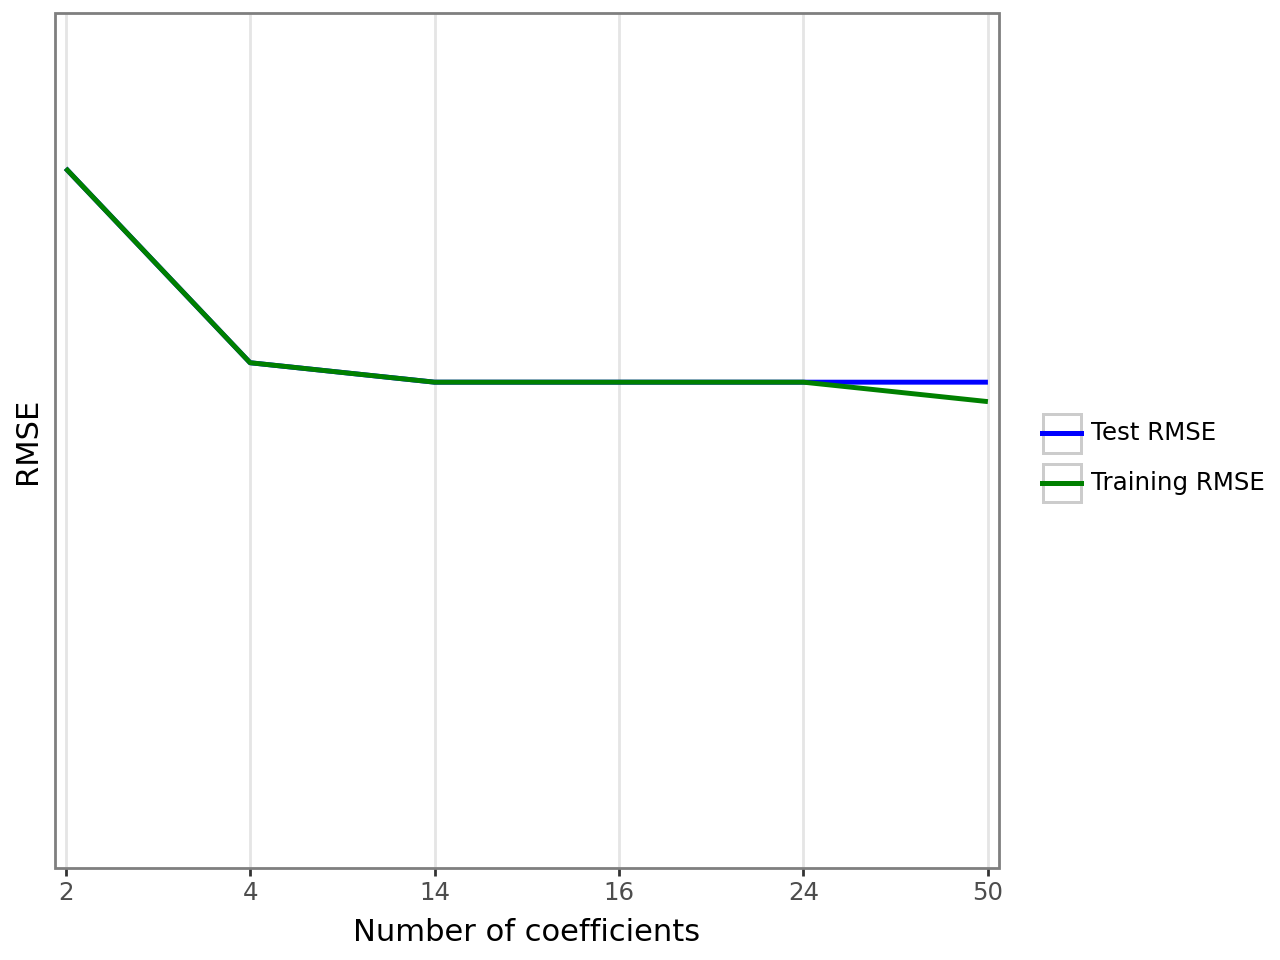

In [129]:
color = ["blue", "green"]

(ggplot(
        compare_model_fits.melt(
            id_vars="Coefficients", value_vars=["Training RMSE", "Test RMSE"]
        ),
        aes(x="factor(Coefficients)", y="value", color="variable", group="variable"),
    )
    + geom_line(size=1, show_legend=True, na_rm=True)
    + scale_color_manual(name=" ", values=(color[0], color[1]))
    + scale_y_continuous(name="RMSE", limits=(0.2, 0.6), breaks=np.arange(30, 44, 2))
    + scale_x_discrete(name="Number of coefficients", expand=(0.01, 0.01))
    + theme_bw()
)

### Lasso model

<span style="font-size: 18px;">**Picking the most complicated model**

In [132]:
broad_model = model6

In [133]:
lambdas = np.logspace(-4, 2, 100)  
#print(lambdas)

In [134]:
y, X = patsy.dmatrices("ln_price" + broad_model, work_set)
X_featnames = X.design_info.column_names
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [135]:
start_time = time.time()

lasso_fit = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X, y)

# End time after fitting
lasso_training_time = time.time() - start_time

In [136]:
lasso_fit.alpha_

0.0012328467394420659

In [137]:
rmse_lambda_folds = (
    pd.DataFrame(lasso_fit.mse_path_, index=lambdas[::-1])
    .apply(np.sqrt)
    .mean(axis=1)
    .to_frame(name="Test RMSE")
    .round(2)
)
rmse_lambda_folds

Test RMSE
100.000000       0.61
86.974900        0.61
75.646333        0.61
65.793322        0.61
57.223677        0.61
...               ...
0.000175         0.43
0.000152         0.43
0.000132         0.43
0.000115         0.43
0.000100         0.43

[100 rows x 1 columns]

In [138]:
notnull_lasso_coefs = (
    pd.DataFrame(lasso_fit.coef_, index=X_featnames, columns=["coefficient"])
    .loc[lambda x: x["coefficient"].round(3) != 0]
    .round(3)
)
notnull_lasso_coefs

coefficient
host_is_superhost[T.t]                                                            0.002
room_type[T.Hotel room]                                                           0.009
room_type[T.Private room]                                                        -0.011
room_type[T.Shared room]                                                         -0.043
neighbourhood_group[T.II Parioli/Nomentano]                                      -0.025
neighbourhood_group[T.Others]                                                    -0.046
neighbourhood_group[T.V Prenestino/Centocelle]                                   -0.065
neighbourhood_group[T.VII San Giovanni/Cinecittà]                                -0.055
neighbourhood_group[T.XII Monte Verde]                                           -0.040
neighbourhood_group[T.XIII Aurelia]                                              -0.032
Wi_Fi[T.True]                                                                     0.003
Heating_Cooling[T.True]                                                           0.005
Washer_Dryer[T.True]                                                              0.002
Pet_Friendly_Policy[T.True]                                                      -0.017
Smart_TV_Streaming[T.True]                                                        0.017
Kitchen_Access[T.True]                                                           -0.016
Balcony_Outdoor_Space[T.True]                                                     0.003
Pool_HotTub[T.True]                                                               0.026
room_type[T.Hotel room]:host_is_superhost[T.t]                                   -0.016
room_type[T.Private room]:host_is_superhost[T.t]                                 -0.032
room_type[T.Shared room]:host_is_superhost[T.t]                                  -0.003
room_type[T.Hotel room]:Washer_Dryer[T.True]                                     -0.001
room_type[T.Private room]:Washer_Dryer[T.True]                                   -0.022
room_type[T.Hotel room]:neighbourhood_group[T.II Parioli/Nomentano]               0.001
room_type[T.Private room]:neighbourhood_group[T.II Parioli/Nomentano]            -0.010
room_type[T.Private room]:neighbourhood_group[T.Others]                          -0.019
room_type[T.Shared room]:neighbourhood_group[T.Others]                            0.008
room_type[T.Private room]:neighbourhood_group[T.V Prenestino/Centocelle]         -0.010
room_type[T.Shared room]:neighbourhood_group[T.V Prenestino/Centocelle]           0.004
room_type[T.Shared room]:neighbourhood_group[T.VII San Giovanni/Cinecittà]       -0.010
room_type[T.Hotel room]:neighbourhood_group[T.XII Monte Verde]                   -0.003
room_type[T.Shared room]:neighbourhood_group[T.XII Monte Verde]                  -0.001
room_type[T.Private room]:neighbourhood_group[T.XIII Aurelia]                     0.001
room_type[T.Hotel room]:Kitchen_Access[T.True]                                    0.005
room_type[T.Private room]:Kitchen_Access[T.True]                                 -0.006
accommodates                                                                      0.278
ln_distance_to_rome_center_miles                                                 -0.213
review_scores_rating                                                              0.051
log_minimum_nights_spline1                                                       -0.048
log_minimum_nights_spline2                                                       -0.013

<span style="font-size: 18px;">**Summarizing Model Fits, RMSE and Training Times**

In [140]:
compare_model_fits.loc[8, :] = {
    "Model": "Lasso",
    "Coefficients": notnull_lasso_coefs.shape[0],
    "Test RMSE": rmse_lambda_folds.loc[lasso_fit.alpha_].round(2).values[0],
    "Training_Time": lasso_training_time  # Add the Lasso training time
}

compare_model_fits

Model  Coefficients  R-squared      BIC  Training RMSE  Test RMSE  \
0     M1           2.0       0.23  35786.0           0.54       0.54   
1     M2           4.0       0.48  27225.0           0.44       0.44   
2     M3          14.0       0.50  26248.0           0.43       0.43   
3     M4          16.0       0.51  25866.0           0.43       0.43   
4     M5          24.0       0.52  25653.0           0.43       0.43   
5     M6          50.0       0.52  25676.0           0.42       0.43   
8  Lasso          40.0        NaN      NaN            NaN       0.43   

   Training_Time  
0       0.134641  
1       0.146647  
2       2.505262  
3       2.440387  
4       2.432498  
5       2.823411  
8       0.504650

### Random Forest

<span style="font-size: 18px;">**Some changes in the data for Tree based algorithms:**
1. We took logs and splines for some numeric features but as functional transformations are not needed in Tree based algorithms, we will create the list of numeric features for RF again.
2. We will also not use interactions. 
3. The dependent variable Y would be changed from Log Price to Price.
4. Rest remains the same. We can experiment with functional forms later as well

In [143]:
hotels_cleansed.dtypes

id                                   object
host_is_superhost                    object
room_type                            object
accommodates                          int64
price                               float64
minimum_nights                        int64
review_scores_rating                float64
distance_to_rome_center_miles       float64
ln_price                            float64
ln_minimum_nights                   float64
ln_distance_to_rome_center_miles    float64
log_minimum_nights_spline1          float64
log_minimum_nights_spline2          float64
Wi_Fi                                  bool
Heating_Cooling                        bool
Kitchen_Access                         bool
Washer_Dryer                           bool
Pool_HotTub                            bool
Balcony_Outdoor_Space                  bool
Pet_Friendly_Policy                    bool
Smart_TV_Streaming                     bool
neighbourhood_group                  object
dtype: object

In [144]:
numeric_features = ["accommodates","distance_to_rome_center_miles","review_scores_rating","minimum_nights"]
categorical_features = ["host_is_superhost", "room_type","neighbourhood_group"]
amenities= ["Wi_Fi","Heating_Cooling",
                        "Washer_Dryer","Pet_Friendly_Policy","Smart_TV_Streaming", "Kitchen_Access","Balcony_Outdoor_Space","Pool_HotTub"]

<span style="font-size: 18px;">**We need to encode amenities which are boolean into 0 1 before passing to the model**

In [146]:
hotels_cleansed[amenities] = hotels_cleansed[amenities].astype(int)

In [147]:
predictors = numeric_features + categorical_features + amenities

In [148]:
preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features + amenities),
    ]
)

In [149]:
predictors

['accommodates',
 'distance_to_rome_center_miles',
 'review_scores_rating',
 'minimum_nights',
 'host_is_superhost',
 'room_type',
 'neighbourhood_group',
 'Wi_Fi',
 'Heating_Cooling',
 'Washer_Dryer',
 'Pet_Friendly_Policy',
 'Smart_TV_Streaming',
 'Kitchen_Access',
 'Balcony_Outdoor_Space',
 'Pool_HotTub']

In [201]:
X = preprocessor.fit_transform(work_set[predictors])
X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out()).astype(float)
y = work_set["price"].astype(float)


In [205]:
X.dtypes

cat__host_is_superhost_f                               float64
cat__host_is_superhost_t                               float64
cat__room_type_Entire home/apt                         float64
cat__room_type_Hotel room                              float64
cat__room_type_Private room                            float64
cat__room_type_Shared room                             float64
cat__neighbourhood_group_I Centro Storico              float64
cat__neighbourhood_group_II Parioli/Nomentano          float64
cat__neighbourhood_group_Others                        float64
cat__neighbourhood_group_V Prenestino/Centocelle       float64
cat__neighbourhood_group_VII San Giovanni/Cinecittà    float64
cat__neighbourhood_group_XII Monte Verde               float64
cat__neighbourhood_group_XIII Aurelia                  float64
num__accommodates                                      float64
num__distance_to_rome_center_miles                     float64
num__review_scores_rating                              

In [207]:
# setting 7 cores
ncores = 7

In [209]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {"max_features": [5, 7, 9], "min_samples_split": [5, 8, 11]}

rf_random = GridSearchCV(
    rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0
)

start_time = time.time()

rf_model_1 = rf_random.fit(X, y.ravel())

rf1_training_time = time.time() - start_time

In [210]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=50,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {"max_features": [8, 10, 12], "min_samples_split": [6, 11, 16],}

rf_random = GridSearchCV(rfr,tune_grid,cv=5,scoring="neg_root_mean_squared_error",
    verbose=0,)

start_time = time.time()

rf_model_2 = rf_random.fit(X, y.ravel())

rf2_training_time = time.time() - start_time

In [211]:
rf_model_1_rmse = rf_model_1.cv_results_["mean_test_score"].max() * -1
rf_model_2_rmse = rf_model_2.cv_results_["mean_test_score"].max() * -1

pd.DataFrame(
    {"RMSE": [rf_model_1_rmse, rf_model_2_rmse], "Training Time": [rf1_training_time, rf2_training_time]}, ["Model 1", "Model 2"]
).round(2)

RMSE  Training Time
Model 1  113.97          13.77
Model 2  113.89          24.99

Model 2 looks better, so we analyze its parameters

In [213]:
(
    pd.DataFrame(rf_model_2.cv_results_)[
        ["param_max_features", "param_min_samples_split", "mean_test_score"]
    ]
    .assign(
        mean_test_score=lambda x: x["mean_test_score"] * -1,
        Features=lambda x: x["param_max_features"],
        Min_nodes=lambda x: x["param_min_samples_split"] - 1,
    )
    .pivot(index="Min_nodes", columns="Features", values="mean_test_score")
    .round(2)
)

Features       8       10      12
Min_nodes                        
5          113.89  114.05  114.53
10         114.00  114.22  114.41
15         114.36  114.52  114.73

<span style="font-size: 18px;">**Lowest RMSE occurs 5 nodes and 8 features. So using 8 random features at each split reduces overfitting (variance) and going deeper till we have just more than or equal to 5 samples in each node reduces bias and gives best RMSE**

### Gradient Boosting Regressor

In [216]:

gbr = GradientBoostingRegressor(
    random_state=42,
    n_estimators=50,
    #learning_rate=0.05,
    subsample=0.8
)

tune_grid = {
    "max_depth": [5, 10, 12],  
    "min_samples_split": [5, 10, 15],  
    #"n_estimators": [i for i in range(50, 100, 500)],
    "learning_rate": [0.1, 0.15, 0.2, 0.25],
}

gb_random = GridSearchCV(
    gbr, 
    tune_grid, 
    cv=5, 
    scoring="neg_root_mean_squared_error",
    verbose=0
)


# Start time before fitting
start_time = time.time()

gb_model = gb_random.fit(X, y)

# End time after fitting
gb_training_time = time.time() - start_time

gb_model_rmse = gb_model.cv_results_["mean_test_score"].max() * -1


In [217]:
pd.DataFrame(
    {"RMSE": [gb_model_rmse], "Training_Time" : [gb_training_time]}, ["Gradient Boosting"]
).round(2)


RMSE  Training_Time
Gradient Boosting  115.6         340.17

In [218]:
(
    pd.DataFrame(gb_model.cv_results_)[
        ["param_max_depth", "param_min_samples_split", "param_learning_rate", "mean_test_score"]
    ]
    .assign(
        mean_test_score=lambda x: x["mean_test_score"] * -1,
        Depth=lambda x: x["param_max_depth"],
        Min_nodes=lambda x: x["param_min_samples_split"] - 1,
        Learning_Rate=lambda x: x["param_learning_rate"]
    )
    .pivot(index=["Min_nodes", "Learning_Rate"], columns="Depth", values="mean_test_score")
    .round(2)
)

Depth                        5       10      12
Min_nodes Learning_Rate                        
4         0.10           116.14  118.27  120.30
          0.15           115.84  119.80  123.17
          0.20           116.04  122.42  126.01
          0.25           117.31  124.23  128.36
9         0.10           115.99  117.36  119.45
          0.15           115.79  119.27  121.30
          0.20           116.18  121.17  123.85
          0.25           116.55  122.32  125.19
14        0.10           115.96  117.03  118.58
          0.15           115.73  118.77  120.54
          0.20           115.60  121.03  122.71
          0.25           116.43  122.40  124.71

<span style="font-size: 18px;">**Lowest RMSE occurs at 15 nodes with a depth of 5 and a learning rate of 0.20.**

### XGBoost- Another Gradient Boosting Algorithm

<span style="font-size: 18px;">**Supports parallel processing so we put ncores = 7**

In [222]:
ncores = 7

In [223]:

xgb = XGBRegressor(
    random_state=42,
    n_estimators=50,  # Number of boosting rounds
    subsample=0.8,  # Use 80% of data per tree
    n_jobs=ncores  # Enables parallel processing
)

tune_grid = {
    "max_depth": [5, 10, 12],  
    "min_samples_split": [5, 10, 15],  
    #"n_estimators": [i for i in range(50, 100, 500)],
    "learning_rate": [0.1, 0.15, 0.2, 0.25],
}

xgb_random = GridSearchCV(
    xgb, 
    tune_grid, 
    cv=5, 
    scoring="neg_root_mean_squared_error",
    verbose=0,
    error_score = "raise"
)

# Start time before fitting
start_time = time.time()

xgb_model = xgb_random.fit(X, y)

# End time after fitting
xgb_training_time = time.time() - start_time

xgb_model_rmse = xgb_model.cv_results_["mean_test_score"].max() * -1

In [224]:
pd.DataFrame(
   {"RMSE": [xgb_model_rmse], "Training_Time" : [xgb_training_time]}, ["Extreme Gradient Boosting"]
).round(2)


RMSE  Training_Time
Gradient Boosting  115.36          79.29

In [225]:
(
    pd.DataFrame(xgb_model.cv_results_)[
        ["param_max_depth", "param_min_samples_split", "param_learning_rate", "mean_test_score"]
    ]
    .assign(
        mean_test_score=lambda x: x["mean_test_score"] * -1,
        Depth=lambda x: x["param_max_depth"],
        Min_nodes=lambda x: x["param_min_samples_split"] - 1,
        Learning_Rate=lambda x: x["param_learning_rate"]
    )
    .pivot(index=["Min_nodes", "Learning_Rate"], columns="Depth", values="mean_test_score")
    .round(2)
)

Depth                        5       10      12
Min_nodes Learning_Rate                        
4         0.10           115.49  116.29  118.23
          0.15           115.36  117.83  120.14
          0.20           115.42  119.40  120.94
          0.25           115.49  120.26  123.08
9         0.10           115.49  116.29  118.23
          0.15           115.36  117.83  120.14
          0.20           115.42  119.40  120.94
          0.25           115.49  120.26  123.08
14        0.10           115.49  116.29  118.23
          0.15           115.36  117.83  120.14
          0.20           115.42  119.40  120.94
          0.25           115.49  120.26  123.08

<span style="font-size: 18px;">**Lowest RMSE occurs 5 nodes with a depth of 5 and a learning rate of 0.15. Lower RMSE than previous Gradient boosting algorithm but higher than Random Forest**

## Comparing Performance of Fitted Models On Holdout Set

<span style="font-size: 18px;">**NOTE: The OLS and Lasso were trained to predict Log of Price instead of Price. Hence, if we want to compare the RMSE of all our fitted models we need to check RMSE on Price for both of these models first. In order to convert the predictions from Log Price to Price we would need to transform with the inclusion of smearing estimate**

$$\Large 
\text{price} = e^y \cdot e^{\sigma^2 / 2}
$$


### Converting Predictions of OLS and Lasso from Log Price to Price

#### OLS

<span style="font-size: 14px;">**Need to refit the model for OLS as ols_crossvalidator used previously does not store fitted models**

In [245]:
# Getting the final model formula
final_model_formula = "ln_price" + model6  # model6 is the most complex model

# Preparing training and test sets for model6
y_train, X_train = patsy.dmatrices(final_model_formula, work_set)  # Use training set
#y_test, X_test = patsy.dmatrices(final_model_formula, test)  # Use test set

# Fitting OLS model on full training data
ols_model = sm.OLS(y_train, X_train).fit()

# Making predictions on the holdout set
y_holdout, X_holdout = patsy.dmatrices("ln_price" + broad_model, holdout_set)
X_holdout = sm.add_constant(X_holdout)  # Add intercept
y_pred_ols_log = ols_model.predict(X_holdout) 

In [247]:
# Converting the log predictions back to original scale (with smearing estimate)
residuals_ols = y_holdout - y_pred_ols_log  # Residuals from the training set
sigma_sq_ols = np.var(residuals_ols)
smearing_factor_ols = np.exp(sigma_sq_ols / 2)
y_pred_ols_price = np.exp(y_pred_ols_log) * smearing_factor_ols

# Computing RMSE for OLS
rmse_ols = np.sqrt(mean_squared_error(holdout_set["price"], y_pred_ols_price))

rmse_ols

131.24766071598123

#### LASSO

<span style="font-size: 14px;">**We use the previously fitted lasso_fit model to predict on Holdout set and then convert to prediction values (non-log) which are compared to actual price**

In [255]:

# Transforming test set features using the same scaler

# Making predictions on the holdout set
y_holdout, X_holdout = patsy.dmatrices("ln_price" + broad_model, holdout_set)
X_holdout = sm.add_constant(X_holdout)  # Add intercept
X_holdout = StandardScaler().fit_transform(X_holdout)  # Ensure proper scaling

# Predicting on the test set using Lasso model
y_pred_lasso_log = lasso_fit.predict(X_holdout)  # Log-scale predictions

# Computing residuals for Lasso
residuals_lasso = y_holdout - y_pred_lasso_log
sigma_sq_lasso = np.var(residuals_lasso)  # Residual variance

# Computing smearing factor for Lasso
smearing_factor_lasso = np.exp(sigma_sq_lasso / 2)

# Converting Lasso predictions back to original scale
y_pred_lasso_price = np.exp(y_pred_lasso_log) * smearing_factor_lasso

# Computing RMSE for Lasso
rmse_lasso = np.sqrt(mean_squared_error(holdout_set["price"], y_pred_lasso_price))

In [257]:

print(f"RMSE (Best OLS): {rmse_ols:.2f}")
print(f"RMSE (Lasso): {rmse_lasso:.2f}")

RMSE (Best OLS): 131.25
RMSE (Lasso): 130.82


#### Tree Based Algorithms -> Random Forest, Gradient Boosting, XGBoost

In [260]:
numeric_features = ["accommodates","distance_to_rome_center_miles","review_scores_rating","minimum_nights"]
categorical_features = ["host_is_superhost", "room_type","neighbourhood_group"]
amenities= ["Wi_Fi","Heating_Cooling",
                        "Washer_Dryer","Pet_Friendly_Policy","Smart_TV_Streaming", "Kitchen_Access","Balcony_Outdoor_Space","Pool_HotTub"]

In [262]:
hotels_cleansed[amenities] = hotels_cleansed[amenities].astype(int)

In [264]:
predictors = numeric_features + categorical_features + amenities

In [266]:
predictors

['accommodates',
 'distance_to_rome_center_miles',
 'review_scores_rating',
 'minimum_nights',
 'host_is_superhost',
 'room_type',
 'neighbourhood_group',
 'Wi_Fi',
 'Heating_Cooling',
 'Washer_Dryer',
 'Pet_Friendly_Policy',
 'Smart_TV_Streaming',
 'Kitchen_Access',
 'Balcony_Outdoor_Space',
 'Pool_HotTub']

In [268]:
preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features + amenities),
    ]
)

In [270]:
X = preprocessor.fit_transform(holdout_set[predictors])
X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out()).astype(float)
y = holdout_set["price"].astype(float)

In [272]:
# Random Forest Predictions
y_pred_rf = rf_model_2.predict(X)

# Gradient Boosting Predictions
y_pred_gb = gb_model.predict(X)

# XGBoost Predictions
y_pred_xgb = xgb_model.predict(X)

In [274]:
rmse_rf = np.sqrt(mean_squared_error(holdout_set["price"], y_pred_rf))
rmse_gb = np.sqrt(mean_squared_error(holdout_set["price"], y_pred_gb))
rmse_xgb = np.sqrt(mean_squared_error(holdout_set["price"], y_pred_xgb))

### RMSE Comparison of All Fitted Models

In [277]:
pd.DataFrame(
    {
        "Model": [
            "Linear regression (OLS)",
            "Linear regression (LASSO)",
            "Random forest",
            "Gradient Boosting",
            "XG Boost",
        ],
        "RMSE": [
            rmse_ols,
            rmse_lasso,
            rmse_rf,
            rmse_gb,
            rmse_xgb,
        ],
    }
).round(1)

Model   RMSE
0    Linear regression (OLS)  131.2
1  Linear regression (LASSO)  130.8
2              Random forest  118.4
3          Gradient Boosting  121.6
4                   XG Boost  120.2

<span style="font-size: 18px;">**Comparing Model Performances**

In [280]:
pd.DataFrame(
    {
        "Model": ["OLS (model6)", "Lasso", "Random Forest", "Gradient Boosting", "XGBoost"],
        "Holdout RMSE": [rmse_ols, rmse_lasso, rmse_rf, rmse_gb, rmse_xgb],
        "Training Times": [float(round(compare_model_fits.loc[compare_model_fits['Model'] == 'M6']['Training_Time'],5)), lasso_training_time, rf2_training_time, gb_training_time, xgb_training_time],
    }
).round(2)

Model  Holdout RMSE  Training Times
0       OLS (model6)        131.25            2.82
1              Lasso        130.82            0.50
2      Random Forest        118.40           24.99
3  Gradient Boosting        121.61          340.17
4            XGBoost        120.19           79.29

### Model Comparisons in Terms of Fit and Times

<span style="font-size: 18px;">**Model Performance**

Lasso (130.82) and OLS (131.25): These models have the highest RMSE, indicating they provide the least accurate predictions compared to others. Lasso slightly outperforms OLS, likely due to its ability to reduce overfitting via regularization.

Random Forest (118.40): Significantly improves prediction accuracy over linear models, benefiting from its ability to capture non-linear relationships.

Gradient Boosting (121.61) & XGBoost (120.19): These boosting-based models perform better than linear models but slightly worse than Random Forest in RMSE.


<span style="font-size: 18px;">**Training Times**

OLS (2.82 sec) & Lasso (0.50 sec): These models train the fastest, making them preferable for quick analysis and iterations.

Random Forest (24.99 sec): Has a longer training time than OLS and Lasso but is reasonable for the performance gain.

Gradient Boosting (340.17 sec): Takes significantly longer than other models but does not give better results than Random Forest, which may not be practical if training efficiency is a concern.

XGBoost (79.29 sec): Provides a good tradeoff between training time and performance. XGBoost has the ability to do parallel processing of models hence has the ability of being faster than Gradient Boosting. It also achieves a slightly better RMSE than Gradient Boosting. 


<span style="font-size: 18px;">**Takeaways**

Best Accuracy: Random Forest (lowest RMSE).

Best Tradeoff (Performance vs. Time): XGBoost—good balance of accuracy and training time.

Most Efficient (for fast training): Lasso—fastest with reasonable accuracy.

Worst Tradeoff: Gradient Boosting—high training time with only a slight improvement over Random Forest.

## Analyzing Random Forest and XGBoost - Feature Importance

<span style="font-size: 16px;">Random Forest and XGBoost give the best RMSE/Accuracy. We will analyze them. 

In order to check feature importance we can use Permutation Importance or Shaply values. Permuatation importance works by reshuffling the feature values and checking changes in RMSE (model performance) on Holdout set. However, if two features are correlated, shuffling one feature might not change the performance as the needed information might be provided by the other feature already. However, Permutation importance is much faster than Shaply. 

Shaply works by considering all the possible values of the features. It compute predictions by including/excluding a feature in various combinations, hence is not affected by correlated features. This is used when we need deeper, instance-level explanations, however it is much slower and computationally expensive.

Lets check the correlation between features and decide which approach to use.

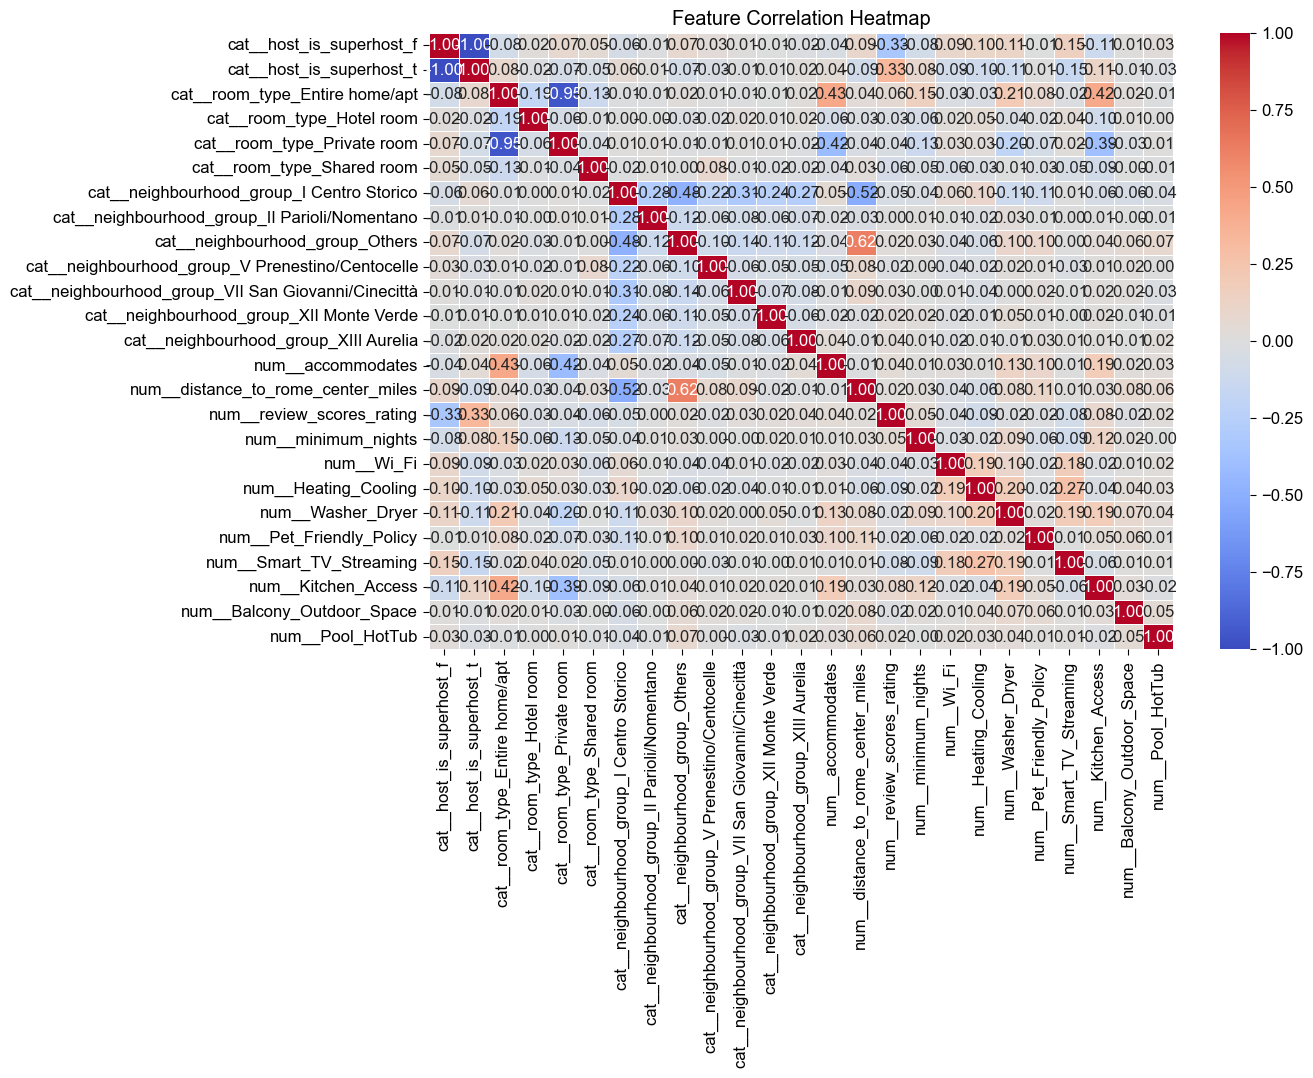

In [311]:
# Compute correlation matrix
corr_matrix = X.corr()

# Display correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [312]:
# Finding highly correlated feature pairs
threshold = 0.7  # Define correlation threshold
high_corr = corr_matrix.abs() > threshold

# Extracting feature names where correlation is high (excluding diagonal)
correlated_features = [
    (col1, col2)
    for col1 in high_corr.columns
    for col2 in high_corr.index
    if high_corr.loc[col1, col2] and col1 != col2
]

print("Highly correlated feature pairs:", correlated_features)

Highly correlated feature pairs: [('cat__host_is_superhost_f', 'cat__host_is_superhost_t'), ('cat__host_is_superhost_t', 'cat__host_is_superhost_f'), ('cat__room_type_Entire home/apt', 'cat__room_type_Private room'), ('cat__room_type_Private room', 'cat__room_type_Entire home/apt')]


<span style="font-size: 18px;">**There are no highly correlated features. We see correlation in categorical features but this is between categories of the same feature. When these categorical features are one hot encoded, these can occur as at one instance only one feature value would be present. Otherwise there is no intercorrelation between different features. We can use Permutation Importance for our purpose**

In [314]:
len(holdout_set)

5598

### Permutation Importance

In [316]:
X_holdout_transformed = preprocessor.transform(holdout_set[predictors])  
X_holdout_transformed = pd.DataFrame(X_holdout_transformed, columns=preprocessor.get_feature_names_out()).astype(float)

y_holdout = holdout_set["price"].astype(float)  # Target variable


**Random forest**

In [318]:
from sklearn.inspection import permutation_importance
import pandas as pd


X_df = pd.DataFrame(X_holdout_transformed, columns=preprocessor.get_feature_names_out())

# Computing permutation importance
perm_importance_rf = permutation_importance(rf_model_2, X_df, y, n_repeats=10, random_state=42)

# Converting to DataFrame for better readability
importances_df_rf = pd.DataFrame({
    'Feature': X_df.columns,  # Use transformed X_df instead of X_test
    'Importance': perm_importance_rf.importances_mean
}).sort_values(by="Importance", ascending=False)

print(importances_df_rf)


                                                Feature  Importance
13                                    num__accommodates   40.735946
14                   num__distance_to_rome_center_miles   25.606989
15                            num__review_scores_rating    7.063975
6             cat__neighbourhood_group_I Centro Storico    6.079506
16                                  num__minimum_nights    2.157264
19                                    num__Washer_Dryer    2.092717
21                              num__Smart_TV_Streaming    1.478162
18                                 num__Heating_Cooling    1.356187
2                        cat__room_type_Entire home/apt    1.336884
4                           cat__room_type_Private room    1.075379
0                              cat__host_is_superhost_f    0.555477
1                              cat__host_is_superhost_t    0.478225
20                             num__Pet_Friendly_Policy    0.469248
8                       cat__neighbourhood_group

**XGBoost**

In [320]:
perm_importance_xgb = permutation_importance(xgb_model, X_df, y, n_repeats=10, random_state=42)

# Converting to DataFrame for better readability
importances_df_xgb = pd.DataFrame({
    'Feature': X_df.columns,  # Use transformed X_df instead of X_test
    'Importance': perm_importance_xgb.importances_mean
}).sort_values(by="Importance", ascending=False)

print(importances_df_xgb)


                                                Feature  Importance
13                                    num__accommodates   42.771303
14                   num__distance_to_rome_center_miles   27.680895
15                            num__review_scores_rating    6.790539
6             cat__neighbourhood_group_I Centro Storico    2.640554
16                                  num__minimum_nights    1.164733
0                              cat__host_is_superhost_f    0.828513
4                           cat__room_type_Private room    0.580044
19                                    num__Washer_Dryer    0.539364
24                                     num__Pool_HotTub    0.386637
2                        cat__room_type_Entire home/apt    0.385150
7         cat__neighbourhood_group_II Parioli/Nomentano    0.228737
22                                  num__Kitchen_Access    0.201981
18                                 num__Heating_Cooling    0.187062
5                            cat__room_type_Shar

<span style="font-size: 18px;">**We will convert the importances into % feature importance before plotting top 10**

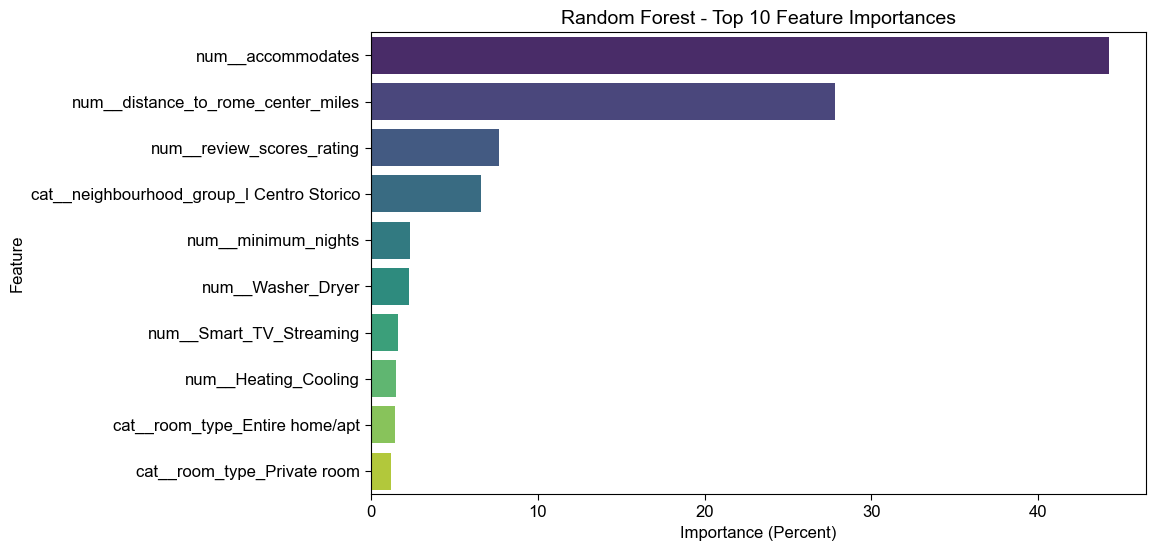

In [322]:
importances_df_rf['Importance_perc'] = (importances_df_rf['Importance']/sum(importances_df_rf['Importance']))*100
top_features = importances_df_rf.nlargest(10, "Importance_perc")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance_perc", 
    y="Feature", 
    data=top_features, 
    palette="viridis"
)

# Add labels and title
plt.xlabel("Importance (Percent)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Random Forest - Top 10 Feature Importances", fontsize=14)


plt.show()

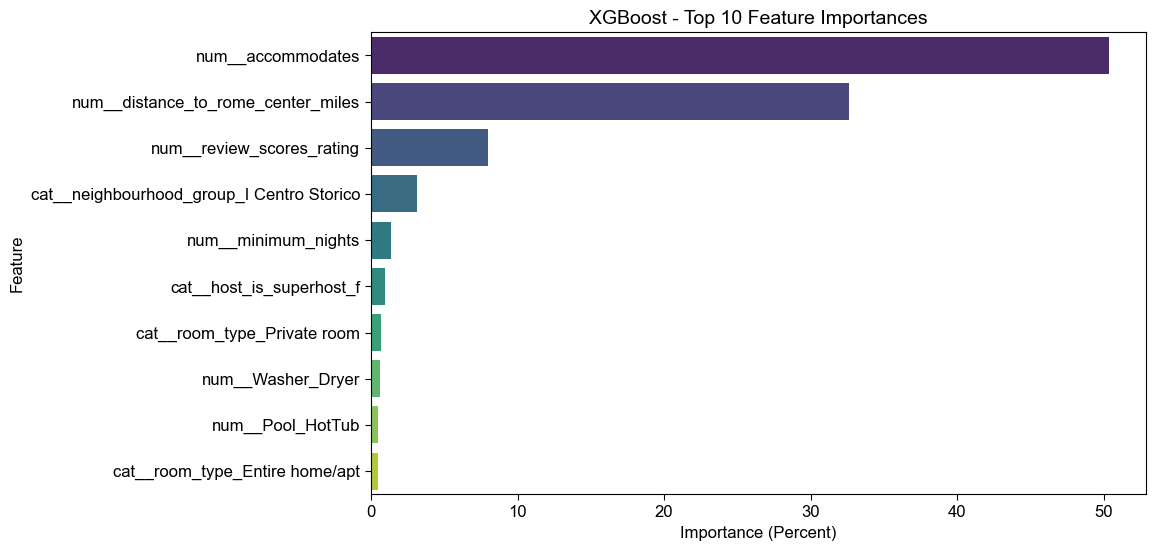

In [323]:
importances_df_xgb['Importance_perc'] = (importances_df_xgb['Importance']/sum(importances_df_xgb['Importance']))*100
top_features = importances_df_xgb.nlargest(10, "Importance_perc")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance_perc", 
    y="Feature", 
    data=top_features, 
    palette="viridis"
)

# Adding labels and title
plt.xlabel("Importance (Percent)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("XGBoost - Top 10 Feature Importances", fontsize=14)


plt.show()

<span style="font-size: 18px;">**We will check these with Shaply as well**

### SHAPLY

<span style="font-size: 18px;">**Random Forest**

In [327]:
rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessor),
        ("regressor", rf_model_2.best_estimator_),  # put best model to pipeline
    ]
)

In [328]:
rf_best_pipeline.fit(work_set[predictors], work_set.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['host_is_superhost',
                                                   'room_type',
                                                   'neighbourhood_group']),
                                                 ('num', 'passthrough',
                                                  ['accommodates',
                                                   'distance_to_rome_center_miles',
                                                   'review_scores_rating',
                                                   'minimum_nights', 'Wi_Fi',
                                                   'Heating_Cooling',
                                                   'Washer_Dryer',
                                                   'Pet_Friendly_Policy',
                                                   'Smart_TV_Streaming',
                                                   'Kitchen_Access',
                                                   'Balcony_Outdoor_Space',
                                                   'Pool_HotTub'])])),
                ('regressor',
                 RandomForestRegressor(max_features=8, min_samples_split=6,
                                       n_estimators=50, n_jobs=7,
                                       oob_score=True, random_state=42))])

In [329]:
X_holdout = preprocessor.fit_transform(holdout_set[predictors])
X_holdout = pd.DataFrame(X_holdout, columns=preprocessor.get_feature_names_out()).astype(float)


y_holdout = holdout_set["price"].astype(float)  # Target variable


PermutationExplainer explainer: 5599it [20:32,  4.52it/s]                                                              


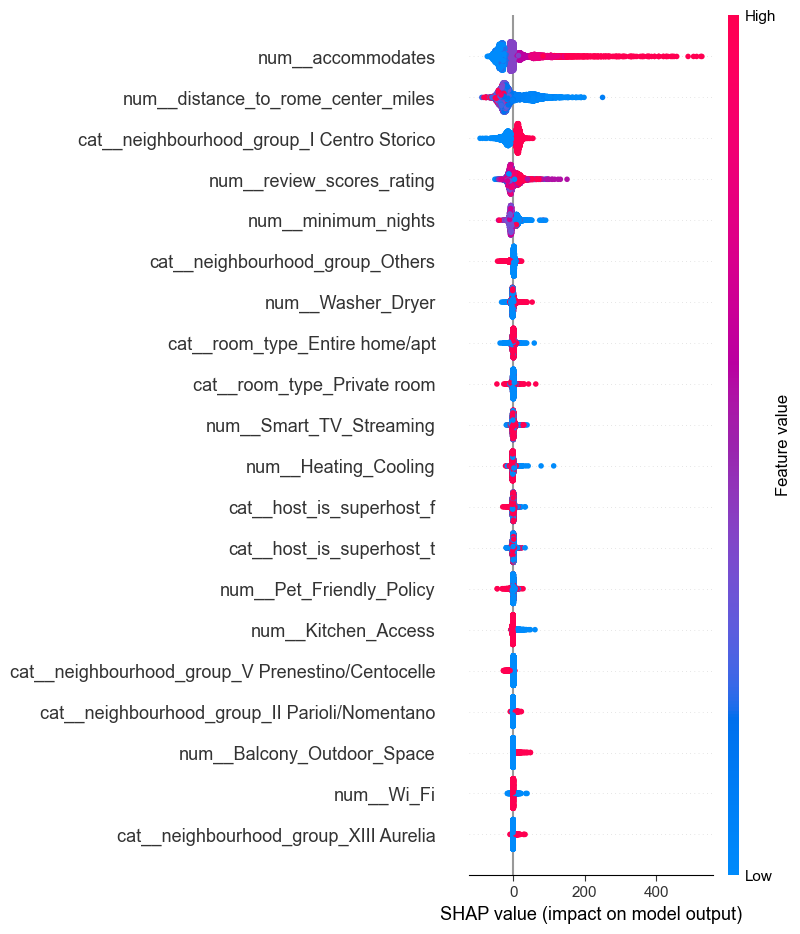

In [330]:
#best_rf_model = rf_model_2.best_estimator_

# Initialize SHAP explainer for the model
explainer = shap.Explainer(rf_best_pipeline["regressor"].predict, X_holdout)

# Compute SHAP values
shap_values = explainer(X_holdout)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_holdout)


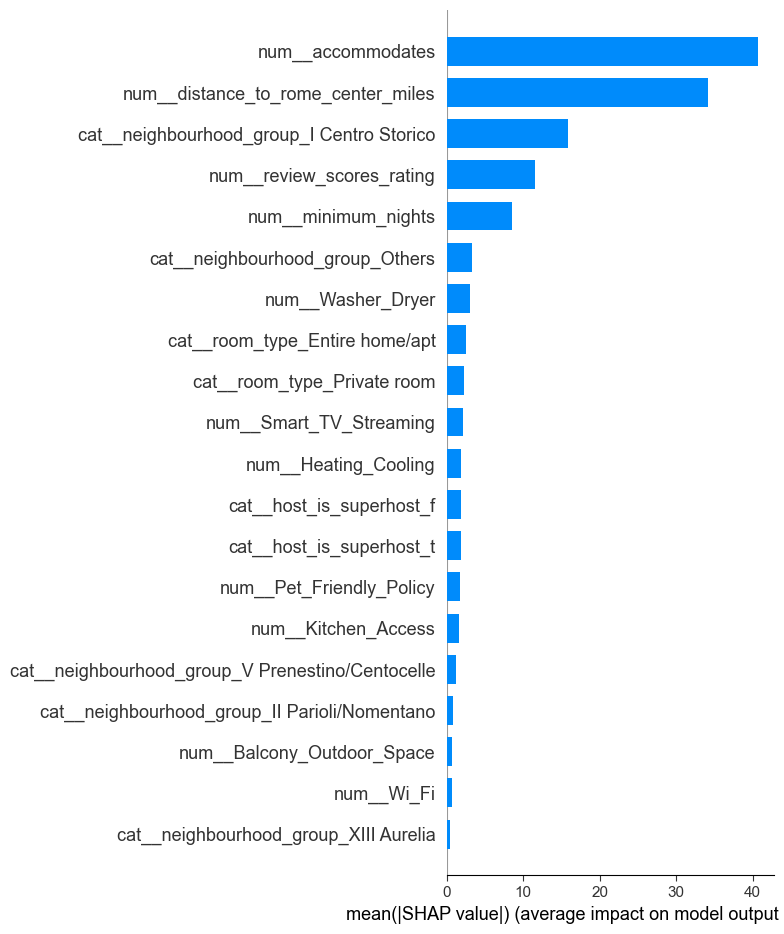

In [331]:
shap.summary_plot(shap_values, X_holdout, plot_type="bar")

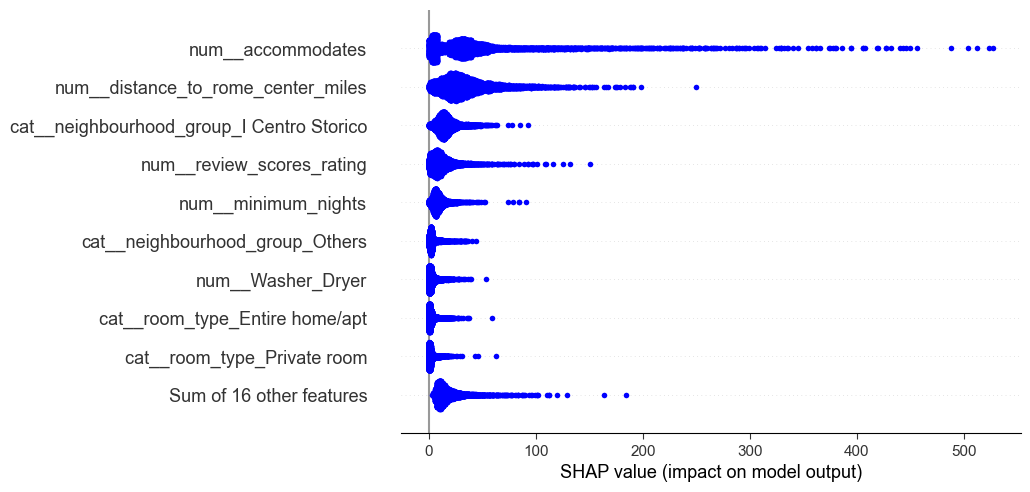

In [332]:
shap.plots.beeswarm(shap_values.abs, color=color[0])

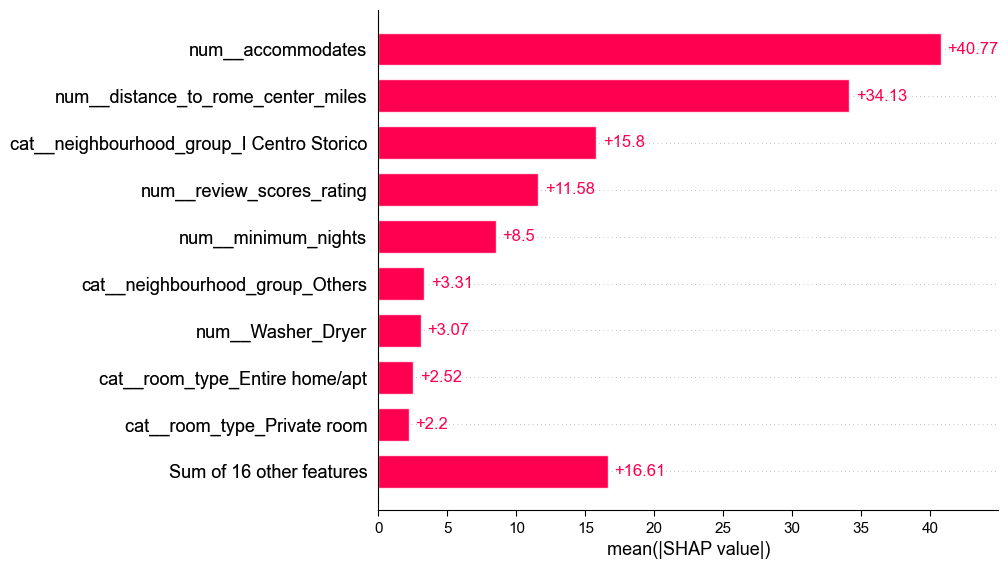

In [333]:
shap.plots.bar(shap_values)

<span style="font-size: 18px;">**XGBoost**

In [335]:
xgb_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessor),
        ("regressor", xgb_model.best_estimator_),  # put best model to pipeline
    ]
)

PermutationExplainer explainer: 5599it [26:18,  3.52it/s]                                                              


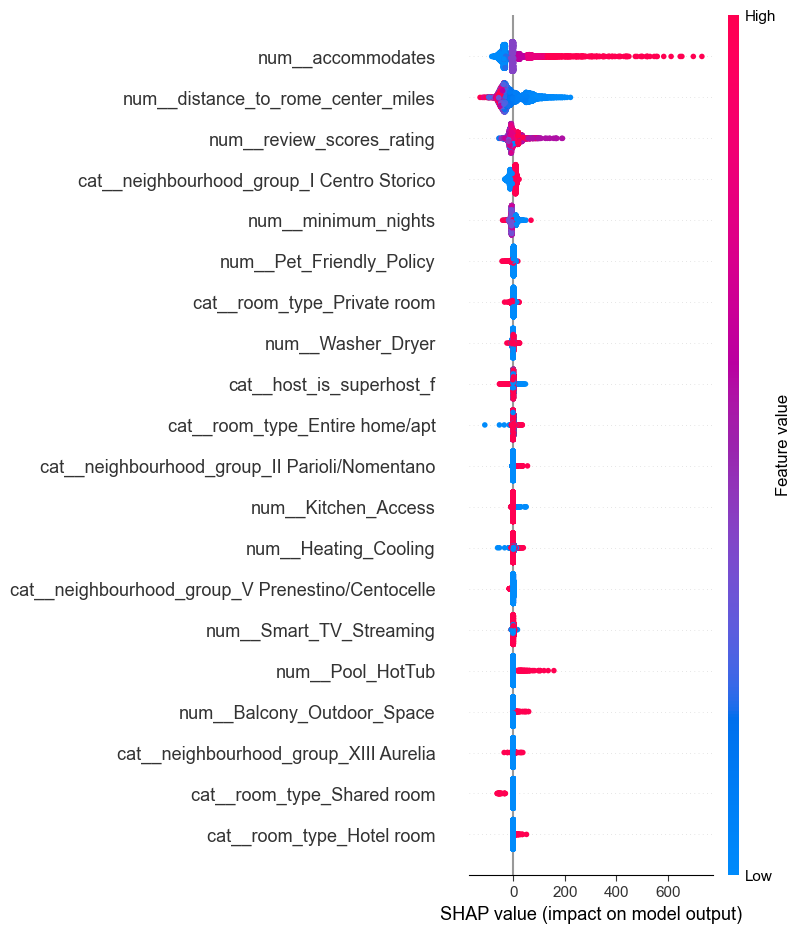

In [336]:
# Initialize SHAP explainer for the model
explainer = shap.Explainer(xgb_best_pipeline["regressor"].predict, X_holdout)

# Compute SHAP values
shap_values = explainer(X_holdout)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_holdout)


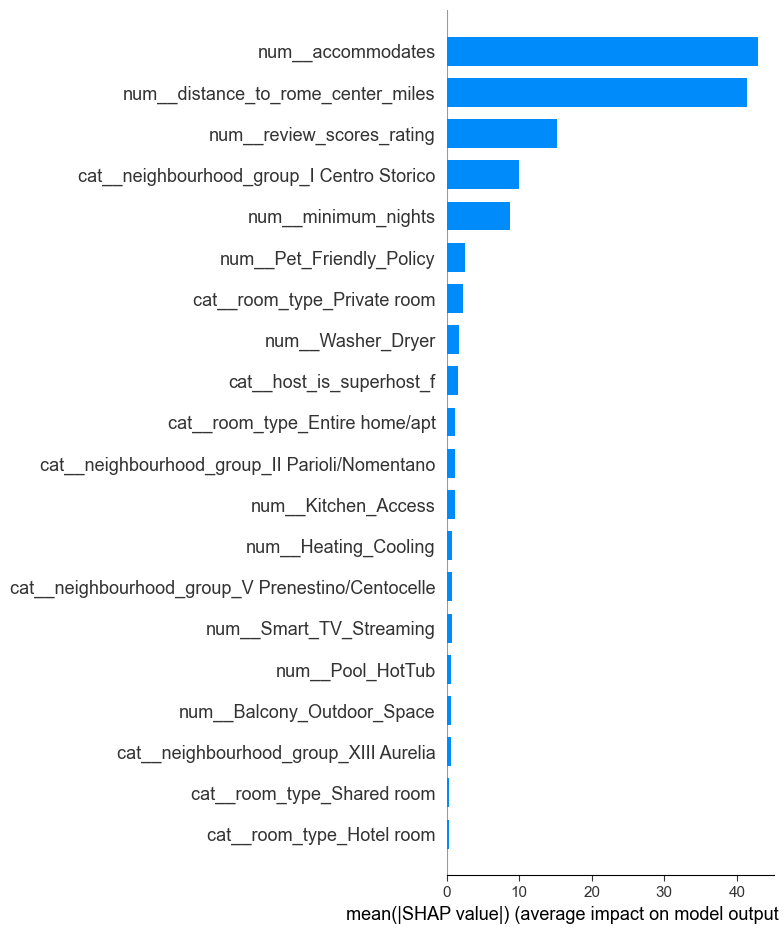

In [337]:
shap.summary_plot(shap_values, X_holdout, plot_type="bar")

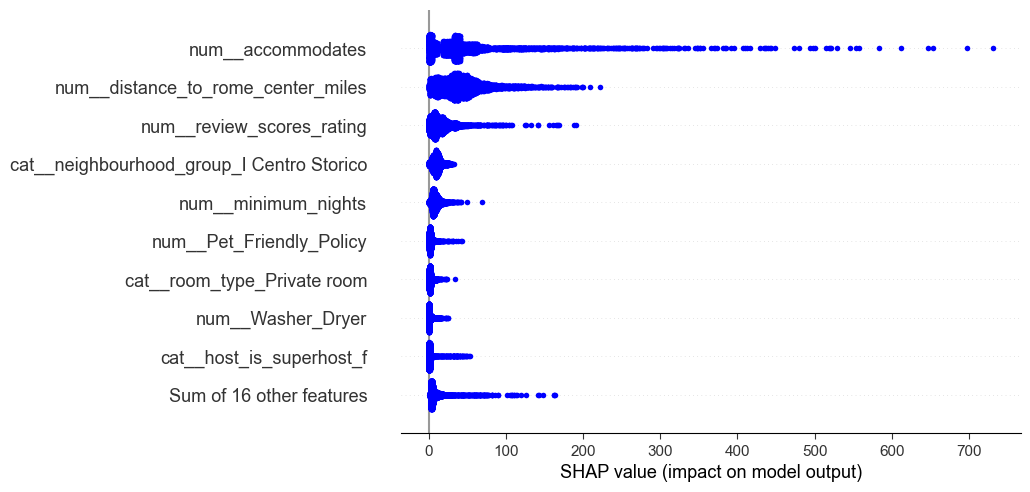

In [338]:
shap.plots.beeswarm(shap_values.abs, color=color[0])

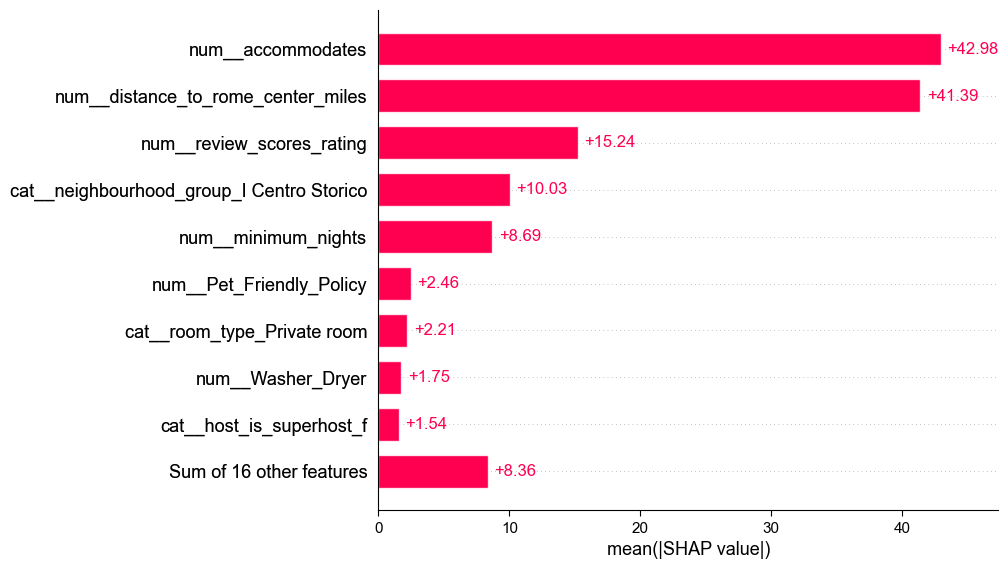

In [339]:
shap.plots.bar(shap_values)

<span style="font-size: 18px;">**Feature Importance Random forest vs XGBoost**
Looking at the Permutation Importance plots for both Random Forest and XGBoost, we observe that both of them assign the highest importance to accommodates, followed by distance_to_rome_center_miles, review_scores_rating, and neighbourhood_group_I Centro Storico.
However, we observe that apart from the top 5 most important features, Random Forest gives more importance to amenities like washer_dryer, TV_Streaming, which were encoded as numerical features. On the other hand XGBoost gives more importance to categorical features such as Room_Type and Is_SuperHost.

<span style="font-size: 18px;">The SHAP importance also gives similar results to the permutation importance for the top features by importance. 
It also ranks accommodates and distance_to_rome_center_miles as the top two most important features.
However, SHAP assigns a much higher value to categorical variables, like neighbourhood_group_I Centro Storico and neighbourhood_group_Others, which are ranked lower in permutation importance.

<span style="font-size: 18px;">Permutation importance and SHAP both show that XGBoost prioritizes categorical features more than Random Forest does. Also, Random Forest tends to distribute importance across more features, whereas XGBoost has sharper distinctions, with the top features taking an even larger share of importance as can be seen by the shaply contribution plots. For e.g. the sum of 16 lowest importance features sums up to 16.6 in XGBoost as compared to 8.37 in Random Forest.


<span style="font-size: 18px;">**Conclusion: Both models agree on the most important numerical features, but XGBoost gives more weight to certain categorical variables and has a sharper distribution of feature importance as compared to Random Forest**

## Validity

### Validity - Feature Engineering

<span style="font-size: 18px;">**We will do feature engineering and model fitting simultaneously for both the time and space datasets so we can compare results**

In [344]:
hotels_time = pd.read_csv("RomeListingsQ32024.csv")
hotels_space = pd.read_csv("FlorenceQ22024.csv")

In [345]:
pd.set_option('display.max_rows', None)
pd.DataFrame(hotels_time.isna().sum()).head(100)
pd.DataFrame(hotels_space.isna().sum()).head(100)

0
id                                                0
listing_url                                       0
scrape_id                                         0
last_scraped                                      0
source                                            0
name                                              0
description                                     383
neighborhood_overview                          4888
picture_url                                       0
host_id                                           0
host_url                                          0
host_name                                         0
host_since                                        0
host_location                                  2300
host_about                                     5009
host_response_time                              871
host_response_rate                              871
host_acceptance_rate                            529
host_is_superhost                               648
host_thumbnail_url                                0
host_picture_url                                  0
host_neighbourhood                             5723
host_listings_count                               0
host_total_listings_count                         0
host_verifications                                0
host_has_profile_pic                              0
host_identity_verified                            0
neighbourhood                                  4888
neighbourhood_cleansed                            0
neighbourhood_group_cleansed                  12246
latitude                                          0
longitude                                         0
property_type                                     0
room_type                                         0
accommodates                                      0
bathrooms                                       400
bathrooms_text                                    6
bedrooms                                         47
beds                                            430
amenities                                         0
price                                           399
minimum_nights                                    0
maximum_nights                                    0
minimum_minimum_nights                            0
maximum_minimum_nights                            0
minimum_maximum_nights                            0
maximum_maximum_nights                            0
minimum_nights_avg_ntm                            0
maximum_nights_avg_ntm                            0
calendar_updated                              12246
has_availability                                 36
availability_30                                   0
availability_60                                   0
availability_90                                   0
availability_365                                  0
calendar_last_scraped                             0
number_of_reviews                                 0
number_of_reviews_ltm                             0
number_of_reviews_l30d                            0
first_review                                   1428
last_review                                    1428
review_scores_rating                           1428
review_scores_accuracy                         1435
review_scores_cleanliness                      1435
review_scores_checkin                          1435
review_scores_communication                    1435
review_scores_location                         1435
review_scores_value                            1435
license                                        8049
instant_bookable                                  0
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                              1428

<span style="font-size: 18px;">**We filter for variables that make sense in the context of predicting price. We do not consider the rest. Some identifier variables like id also kept if we need to spot individual listings for some reason like anomalies etc.**

In [347]:
hotels_cleansed_time = hotels_time[['id', 'listing_url', 'name','host_id','host_is_superhost',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
        'bedrooms', 'beds', 'amenities', 'price','minimum_nights','calendar_last_scraped', 'number_of_reviews',
       'first_review','review_scores_rating','reviews_per_month','license']]

hotels_cleansed_space = hotels_space[['id', 'listing_url', 'name','host_id','host_is_superhost',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
        'bedrooms', 'beds', 'amenities', 'price','minimum_nights','calendar_last_scraped', 'number_of_reviews',
       'first_review','review_scores_rating','reviews_per_month','license']]

In [348]:
hotels_cleansed_time = hotels_cleansed_time.loc[hotels_cleansed_time['price'].notnull()]
hotels_cleansed_space = hotels_cleansed_space.loc[hotels_cleansed_space['price'].notnull()]

In [349]:
hotels_cleansed_space['room_type'].value_counts().sort_values()

room_type
Shared room          29
Hotel room           80
Private room       1812
Entire home/apt    9926
Name: count, dtype: int64

In [350]:
room_type_space = pd.DataFrame(hotels_cleansed_space.groupby('room_type').agg(bathrooms = ('bathrooms','mean'),bedrooms = ('bedrooms','mean'),beds = ('beds','mean')))
room_type_space.reset_index(inplace = True)
room_type_space.head()

room_type  bathrooms  bedrooms      beds
0  Entire home/apt   1.391447  1.601351  2.222020
1       Hotel room   1.050000  1.262500  1.462500
2     Private room   1.128934  1.129139  1.375417
3      Shared room   1.241379  1.000000  2.551724

In [351]:
room_type_time = pd.DataFrame(hotels_cleansed_time.groupby('room_type').agg(bathrooms = ('bathrooms','mean'),bedrooms = ('bedrooms','mean'),beds = ('beds','mean')))
room_type_time.reset_index(inplace = True)
room_type_time.head()

room_type  bathrooms  bedrooms      beds
0  Entire home/apt   1.364217  1.596958  2.404218
1       Hotel room   1.101754  1.315789  1.600000
2     Private room   1.099147  1.107059  1.425240
3      Shared room   1.028455  1.128440  2.796748

In [352]:
#filling na for bathrooms
hotels_cleansed_space['bathrooms'].fillna(1,inplace = True)

#filling na for bedrooms
hotels_cleansed_space.loc[hotels_cleansed_space['room_type'] == 'Entire home/apt']['bedrooms'].fillna(2, inplace = True)
hotels_cleansed_space['bedrooms'].fillna(1, inplace = True)


#filling na for beds
hotels_cleansed_space.loc[hotels_cleansed_space['room_type'] == 'Private room']['beds'].fillna(1, inplace = True)
hotels_cleansed_space['beds'].fillna(2, inplace = True)


In [353]:
#filling na for bathrooms
hotels_cleansed_time['bathrooms'].fillna(1,inplace = True)

#filling na for bedrooms
hotels_cleansed_time.loc[hotels_cleansed_time['room_type'] == 'Entire home/apt']['bedrooms'].fillna(2, inplace = True)
hotels_cleansed_time['bedrooms'].fillna(1, inplace = True)


#filling na for beds
hotels_cleansed_time.loc[hotels_cleansed_time['room_type'] == 'Private room']['beds'].fillna(1, inplace = True)
hotels_cleansed_time['beds'].fillna(2, inplace = True)


In [354]:
hotels_cleansed_space['host_is_superhost'].value_counts()

host_is_superhost
f    6708
t    4502
Name: count, dtype: int64

In [355]:
hotels_cleansed_time['host_is_superhost'].value_counts()

host_is_superhost
f    17788
t    11150
Name: count, dtype: int64

In [356]:
hotels_cleansed_space.groupby('host_is_superhost')['review_scores_rating'].mean()

host_is_superhost
f    4.633021
t    4.866549
Name: review_scores_rating, dtype: float64

In [357]:
hotels_cleansed_time.groupby('host_is_superhost')['review_scores_rating'].mean()

host_is_superhost
f    4.671422
t    4.863524
Name: review_scores_rating, dtype: float64

In [358]:
hotels_cleansed_space.groupby('host_is_superhost')['number_of_reviews'].mean()

host_is_superhost
f     43.787716
t    104.796535
Name: number_of_reviews, dtype: float64

In [359]:
hotels_cleansed_time.groupby('host_is_superhost')['number_of_reviews'].mean()

host_is_superhost
f    36.993479
t    92.442422
Name: number_of_reviews, dtype: float64

**Hosts with > 4.76 rating and > 73 reviews would be classified as super host to fill na for Florence and for Rome the rating is the same but number of reviews would be 65** 

In [361]:
hotels_cleansed_space.loc[(hotels_cleansed_space['review_scores_rating'] >= 4.76) & hotels_cleansed_space['number_of_reviews'] >= 73]['host_is_superhost'].fillna('t', inplace = True)
hotels_cleansed_space['host_is_superhost'].fillna('f', inplace = True)

In [362]:
hotels_cleansed_time.loc[(hotels_cleansed_time['review_scores_rating'] >= 4.76) & hotels_cleansed_time['number_of_reviews'] >= 65]['host_is_superhost'].fillna('t', inplace = True)
hotels_cleansed_time['host_is_superhost'].fillna('f', inplace = True)

<span style="font-size: 18px;">**Filling nulls in review_scores_rating and reviews_per_month using average values for host_id**

In [364]:
host_reviews_space = pd.DataFrame(hotels_cleansed_space.groupby('host_id').agg(host_reviews_rating = ('review_scores_rating', 'mean'), host_reviews_count = ('reviews_per_month','mean')))
host_reviews_space.reset_index(inplace = True)
host_reviews_space.head()

host_id  host_reviews_rating  host_reviews_count
0    15651             5.000000            0.040000
1    33210             4.850000            2.440000
2    34127             4.590000            2.330000
3    39776             4.497647            0.259412
4    45250             4.950000            2.170000

In [365]:
host_reviews_time = pd.DataFrame(hotels_cleansed_time.groupby('host_id').agg(host_reviews_rating = ('review_scores_rating', 'mean'), host_reviews_count = ('reviews_per_month','mean')))
host_reviews_time.reset_index(inplace = True)
host_reviews_time.head()

host_id  host_reviews_rating  host_reviews_count
0     1944                4.660            0.146667
1     2353                4.580            1.250000
2     3047                4.736            0.126000
3     3504                4.785            0.141667
4    11756                4.910            0.430000

In [366]:
hotels_cleansed_space = hotels_cleansed_space.merge(host_reviews_space, left_on = 'host_id',right_on = 'host_id', how = 'left')
hotels_cleansed_time = hotels_cleansed_time.merge(host_reviews_time, left_on = 'host_id',right_on = 'host_id', how = 'left')

In [367]:
hotels_cleansed_space['review_scores_rating'].fillna(hotels_cleansed_space['host_reviews_rating'], inplace = True)
hotels_cleansed_space['reviews_per_month'].fillna(hotels_cleansed_space['host_reviews_count'], inplace = True)

hotels_cleansed_time['review_scores_rating'].fillna(hotels_cleansed_time['host_reviews_rating'], inplace = True)
hotels_cleansed_time['reviews_per_month'].fillna(hotels_cleansed_time['host_reviews_count'], inplace = True)

<span style="font-size: 18px;">**We still see some nulls in these columns, we can fill them using average values depending on whether host is superhost or not**

In [369]:
hotels_cleansed_time.groupby('host_is_superhost')['review_scores_rating'].mean()

host_is_superhost
f    4.672449
t    4.862891
Name: review_scores_rating, dtype: float64

In [370]:
hotels_cleansed_time.groupby('host_is_superhost')['reviews_per_month'].mean()

host_is_superhost
f    1.445364
t    2.451460
Name: reviews_per_month, dtype: float64

In [371]:
hotels_cleansed_space.loc[hotels_cleansed_space['host_is_superhost'] == 't']['review_scores_rating'].fillna(4.86, inplace = True)
hotels_cleansed_space['review_scores_rating'].fillna(4.63, inplace = True)

hotels_cleansed_space.loc[hotels_cleansed_space['host_is_superhost'] == 't']['reviews_per_month'].fillna(2.44, inplace = True)
hotels_cleansed_space['reviews_per_month'].fillna(1.66, inplace = True)

In [372]:
hotels_cleansed_time.loc[hotels_cleansed_time['host_is_superhost'] == 't']['review_scores_rating'].fillna(4.86, inplace = True)
hotels_cleansed_time['review_scores_rating'].fillna(4.67, inplace = True)

hotels_cleansed_time.loc[hotels_cleansed_time['host_is_superhost'] == 't']['reviews_per_month'].fillna(2.45, inplace = True)
hotels_cleansed_time['reviews_per_month'].fillna(1.44, inplace = True)

<span style="font-size: 18px;">**We will fill first_review date using reviews per month and number of reviews the listing got. Calendar_last_scraped would be used as baseline for filling the dates backward**

In [374]:
hotels_cleansed_space['months_since_first_review'] = np.floor(hotels_cleansed_space['number_of_reviews']/hotels_cleansed_space['reviews_per_month'])

hotels_cleansed_space['first_review'] = pd.to_datetime(hotels_cleansed_space['first_review'], errors='coerce')
hotels_cleansed_space['calendar_last_scraped'] = pd.to_datetime(hotels_cleansed_space['calendar_last_scraped'], errors='coerce')

hotels_cleansed_space['first_review'].fillna(hotels_cleansed_space['calendar_last_scraped'] - hotels_cleansed_space['months_since_first_review'].apply(lambda x: pd.DateOffset(months=x)), inplace = True)

In [375]:
hotels_cleansed_time['months_since_first_review'] = np.floor(hotels_cleansed_time['number_of_reviews']/hotels_cleansed_time['reviews_per_month'])

hotels_cleansed_time['first_review'] = pd.to_datetime(hotels_cleansed_time['first_review'], errors='coerce')
hotels_cleansed_time['calendar_last_scraped'] = pd.to_datetime(hotels_cleansed_time['calendar_last_scraped'], errors='coerce')

hotels_cleansed_time['first_review'].fillna(hotels_cleansed_time['calendar_last_scraped'] - hotels_cleansed_time['months_since_first_review'].apply(lambda x: pd.DateOffset(months=x)), inplace = True)

In [376]:
hotels_florence = hotels_cleansed_space[['id','host_is_superhost',
       'neighbourhood_cleansed', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'amenities', 'price','minimum_nights','calendar_last_scraped', 'number_of_reviews',
       'first_review','review_scores_rating', 'reviews_per_month']]

In [377]:
hotels_rome = hotels_cleansed_time[['id','host_is_superhost',
       'neighbourhood_cleansed', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'amenities', 'price','minimum_nights','calendar_last_scraped', 'number_of_reviews',
       'first_review','review_scores_rating', 'reviews_per_month']]

In [378]:
hotels_rome.isna().sum()

id                        0
host_is_superhost         0
neighbourhood_cleansed    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
amenities                 0
price                     0
minimum_nights            0
calendar_last_scraped     0
number_of_reviews         0
first_review              0
review_scores_rating      0
reviews_per_month         0
dtype: int64

<span style="font-size: 18px;">**All null values have been taken care off. We will keep one listing identifier for now and remove the unnecessary columns. Columns removal criteria for now:** 
1. Categorical features with too many unique values
2. Features that will not be used in feature engineering
3. Features that do not intuitively make sense to be used in predictive modelling

<span style="font-size: 18px;">**Converting price to numeric format and checking distribution**

In [381]:
hotels_rome['price'] = hotels_rome['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
hotels_rome['price'] = pd.to_numeric(hotels_rome['price'])

hotels_florence['price'] = hotels_florence['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
hotels_florence['price'] = pd.to_numeric(hotels_florence['price'])

<span style="font-size: 18px;">99% of price values would be with in 3 Std deviations of the mean

In [383]:
n99th_percentile_rome = np.percentile(hotels_rome['price'], 99.5)
print(n99th_percentile_rome)

1807.3500000000204


In [384]:
n99th_percentile_florence = np.percentile(hotels_florence['price'], 99.5)
print(n99th_percentile_florence)

1796.0


In [385]:
hotels_rome = hotels_rome.loc[hotels_rome['price'] < n99th_percentile_rome]

hotels_florence = hotels_florence.loc[hotels_florence['price'] < n99th_percentile_florence]

<span style="font-size: 18px;">**Creating a Distance to City Center Feature using respective Latitude and Longitude values of both Cities. We keep the feature name the same as training but the data is respective to each city**

In [387]:
# Coordinates of Rome city center
rome_center_lat = 41.8966
rome_center_lon = 12.4825

# Define function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius_of_earth_miles = 3958.8  # Radius of Earth in miles
    return radius_of_earth_miles * c

# Apply the function to each row in the DataFrame
hotels_rome['distance_to_rome_center_miles'] = hotels_rome.apply(
    lambda row: haversine(row['latitude'], row['longitude'], rome_center_lat, rome_center_lon),
    axis=1
)



In [388]:
# Coordinates of Rome city center
florence_center_lat = 43.7696
florence_center_lon = 11.2558

# Define function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius_of_earth_miles = 3958.8  # Radius of Earth in miles
    return radius_of_earth_miles * c

# Apply the function to each row in the DataFrame
hotels_florence['distance_to_rome_center_miles'] = hotels_florence.apply(
    lambda row: haversine(row['latitude'], row['longitude'], florence_center_lat, florence_center_lon),
    axis=1
)

In [389]:
hotels_rome['distance_to_rome_center_miles'] = round(hotels_rome['distance_to_rome_center_miles'],2)
hotels_florence['distance_to_rome_center_miles'] = round(hotels_florence['distance_to_rome_center_miles'],2)

<span style="font-size: 18px;">**Dropping Latitude and Longitude as we have the distance from center now**

In [391]:
hotels_rome.drop(['latitude','longitude'], axis = 1, inplace = True)
hotels_florence.drop(['latitude','longitude'], axis = 1, inplace = True)

<span style="font-size: 18px;">**Creating months since first review column and dropping first_review and last_calendar_scarped date columns**

In [393]:
hotels_rome['months_since_first_review'] = (hotels_rome['calendar_last_scraped'].dt.year - hotels_rome['first_review'].dt.year) * 12 + \
                          (hotels_rome['calendar_last_scraped'].dt.month - hotels_rome['first_review'].dt.month)

hotels_florence['months_since_first_review'] = (hotels_florence['calendar_last_scraped'].dt.year - hotels_florence['first_review'].dt.year) * 12 + \
                          (hotels_florence['calendar_last_scraped'].dt.month - hotels_florence['first_review'].dt.month)

In [394]:
hotels_rome.drop(['calendar_last_scraped','first_review'], axis = 1, inplace = True)
hotels_florence.drop(['calendar_last_scraped','first_review'], axis = 1, inplace = True)


In [395]:
hotels_rome['id'] = hotels_rome['id'].astype(str)
hotels_florence['id'] = hotels_florence['id'].astype(str)

In [396]:
skim(hotels_florence.filter(["price","distance_to_rome_center_miles","accomodates","bedrooms","bathrooms","beds","number_of_reviews", "review_scores_rating","reviews_per_month","months_since_first_review","minimum_nights"]))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 11786  │ │ float64     │ 7     │                                                          │
│ │ Number of columns │ 10     │ │ int32       │ 3     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ price                   │   0 │     0 │   203.5 │   177.4 │    10 │   106 │   150 │   230 │  1770 │   ▇▁   │  │
│ │ distance_to_rome_center │   0 │     0 │  0.8404 │  0.7217 │     0 │  0.35 │  0.59 │   1.1 │  5.25 │  ▇▃▁   │  │
│ │ _miles                  │     │       │         │         │       │       │       │       │       │        │  │
│ │ bedrooms                │   0 │     0 │   1.518 │  0.8589 │     0 │     1 │     1 │     2 │    12 │   ▇▅   │  │
│ │ bathrooms               │   0 │     0 │   1.342 │  0.6545 │     0 │     1 │     1 │   1.5 │     9 │   ▇▃   │  │
│ │ beds                    │   0 │     0 │   2.081 │   1.518 │     0 │     1 │     2 │     3 │    16 │   ▇▃   │  │
│ │ number_of_reviews       │   0 │     0 │   69.21 │   106.9 │     0 │     5 │    25 │ 85.75 │  1082 │   ▇▁   │  │
│ │ review_scores_rating    │   0 │     0 │   4.721 │  0.3495 │     1 │  4.63 │  4.81 │  4.94 │     5 │     ▁▇ │  │
│ │ reviews_per_month       │   0 │     0 │   1.962 │   1.776 │  0.01 │  0.58 │  1.56 │  2.84 │ 13.71 │  ▇▃▁   │  │
│ │ months_since_first_revi │   0 │     0 │   39.13 │   39.99 │     0 │     6 │    23 │    70 │   168 │ ▇▁▂▂▁  │  │
│ │ ew                      │     │       │         │         │       │       │       │       │       │        │  │
│ │ minimum_nights          │   0 │     0 │   3.132 │   16.75 │     1 │     1 │     2 │     3 │   999 │   ▇    │  │
│ └─────────────────────────┴─────┴───────┴─────────┴─────────┴───────┴───────┴───────┴───────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [397]:
skim(hotels_rome.filter(["price","distance_to_rome_center_miles","accomodates","bedrooms","bathrooms","beds","number_of_reviews", "review_scores_rating","reviews_per_month","months_since_first_review","minimum_nights"]))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 30144  │ │ float64     │ 7     │                                                          │
│ │ Number of columns │ 10     │ │ int32       │ 3     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %  ┃ mean   ┃ sd      ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ price                    │   0 │     0 │  181.8 │   151.4 │     8 │   100 │   141 │   207 │  1800 │   ▇▁   │  │
│ │ distance_to_rome_center_ │   0 │     0 │  2.378 │   2.727 │  0.02 │   0.9 │  1.62 │  2.57 │ 18.17 │   ▇▁   │  │
│ │ miles                    │     │       │        │         │       │       │       │       │       │        │  │
│ │ bedrooms                 │   0 │     0 │  1.476 │  0.8398 │     0 │     1 │     1 │     2 │    20 │   ▇    │  │
│ │ bathrooms                │   0 │     0 │  1.294 │  0.6384 │     0 │     1 │     1 │     1 │    12 │   ▇▂   │  │
│ │ beds                     │   0 │     0 │  2.171 │   1.465 │     0 │     1 │     2 │     3 │    38 │   ▇    │  │
│ │ number_of_reviews        │   0 │     0 │  59.63 │    95.8 │     0 │     3 │    20 │    73 │  2317 │   ▇    │  │
│ │ review_scores_rating     │   0 │     0 │  4.743 │  0.3162 │     1 │  4.67 │  4.81 │  4.95 │     5 │     ▁▇ │  │
│ │ reviews_per_month        │   0 │     0 │  1.818 │   1.632 │  0.01 │  0.56 │  1.44 │  2.63 │ 40.11 │   ▇    │  │
│ │ months_since_first_revie │   0 │     0 │  36.03 │   39.21 │     0 │     5 │    18 │    64 │   172 │ ▇▂▂▁▁  │  │
│ │ w                        │     │       │        │         │       │       │       │       │       │        │  │
│ │ minimum_nights           │   0 │     0 │  2.796 │   13.99 │     1 │     1 │     2 │     3 │   999 │   ▇    │  │
│ └──────────────────────────┴─────┴───────┴────────┴─────────┴───────┴───────┴───────┴───────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<span style="font-size: 18px;">**Reviews per month cannot be greater than 30 even if the place is rented out for 30 days to different tenants, we remove these outliers**

In [399]:
hotels_rome = hotels_rome.loc[hotels_rome['reviews_per_month'] <= 30] 
hotels_florence = hotels_florence.loc[hotels_florence['reviews_per_month'] <= 30] 

In [400]:
len(hotels_cleansed.loc[hotels_cleansed['review_scores_rating'] > 3.5])

27949

<span style="font-size: 18px;">**Most of review ratings are above 3.5 (99%) so we take these for removing outliers**

In [402]:
hotels_rome = hotels_rome.loc[hotels_rome['review_scores_rating'] >= 3.5] 
hotels_florence = hotels_florence.loc[hotels_florence['review_scores_rating'] >= 3.5] 

<span style="font-size: 18px;">**Most of the minimum nights allowed would be below 15 days. Mean and std dev also show > 95% values would lie below this range**

In [404]:
hotels_rome = hotels_rome.loc[hotels_rome['minimum_nights'] <= 15] 
hotels_florence = hotels_florence.loc[hotels_florence['minimum_nights'] <= 15] 

<span style="font-size: 18px;">**Accomodates seems to be a good proxy for all variables describing number of bedrooms, bathrooms and beds. We will use it and drop the rest**

In [406]:
hotels_rome.drop(['bathrooms','bedrooms','beds'], axis = 1, inplace = True)
hotels_florence.drop(['bathrooms','bedrooms','beds'], axis = 1, inplace = True)

<span style="font-size: 18px;">**All numeric variables except review_scores_rating seem left skewed with long right tail. We need log transformation for these. However, some of these are not multiplicative in nature and it does not make sense to take log of those, such as accommodates or number of reviews. The multiplicative effect of number of reviews would be captured in reviews per month more accurately**

In [408]:

hotels_rome["ln_price"] = np.log(hotels_rome["price"])
hotels_rome["ln_minimum_nights"] = np.log(hotels_rome["minimum_nights"] + 1) # to adjust for log(0) 
hotels_rome["ln_reviews_per_month"] = np.log(hotels_rome["reviews_per_month"] + 1)
hotels_rome["ln_distance_to_rome_center_miles"] = np.log(hotels_rome["distance_to_rome_center_miles"] + 0.1)
hotels_rome["ln_months_since_first_review"] = np.log(hotels_rome["months_since_first_review"] + 0.1)  # to adjust for log(0) 

hotels_florence["ln_price"] = np.log(hotels_florence["price"])
hotels_florence["ln_minimum_nights"] = np.log(hotels_florence["minimum_nights"] + 1) # to adjust for log(0) 
hotels_florence["ln_reviews_per_month"] = np.log(hotels_florence["reviews_per_month"] + 1)
hotels_florence["ln_distance_to_rome_center_miles"] = np.log(hotels_florence["distance_to_rome_center_miles"] + 0.1)
hotels_florence["ln_months_since_first_review"] = np.log(hotels_florence["months_since_first_review"] + 0.1)  # to adjust for log(0) 



<span style="font-size: 18px;">**Distribution of log distributed variables**

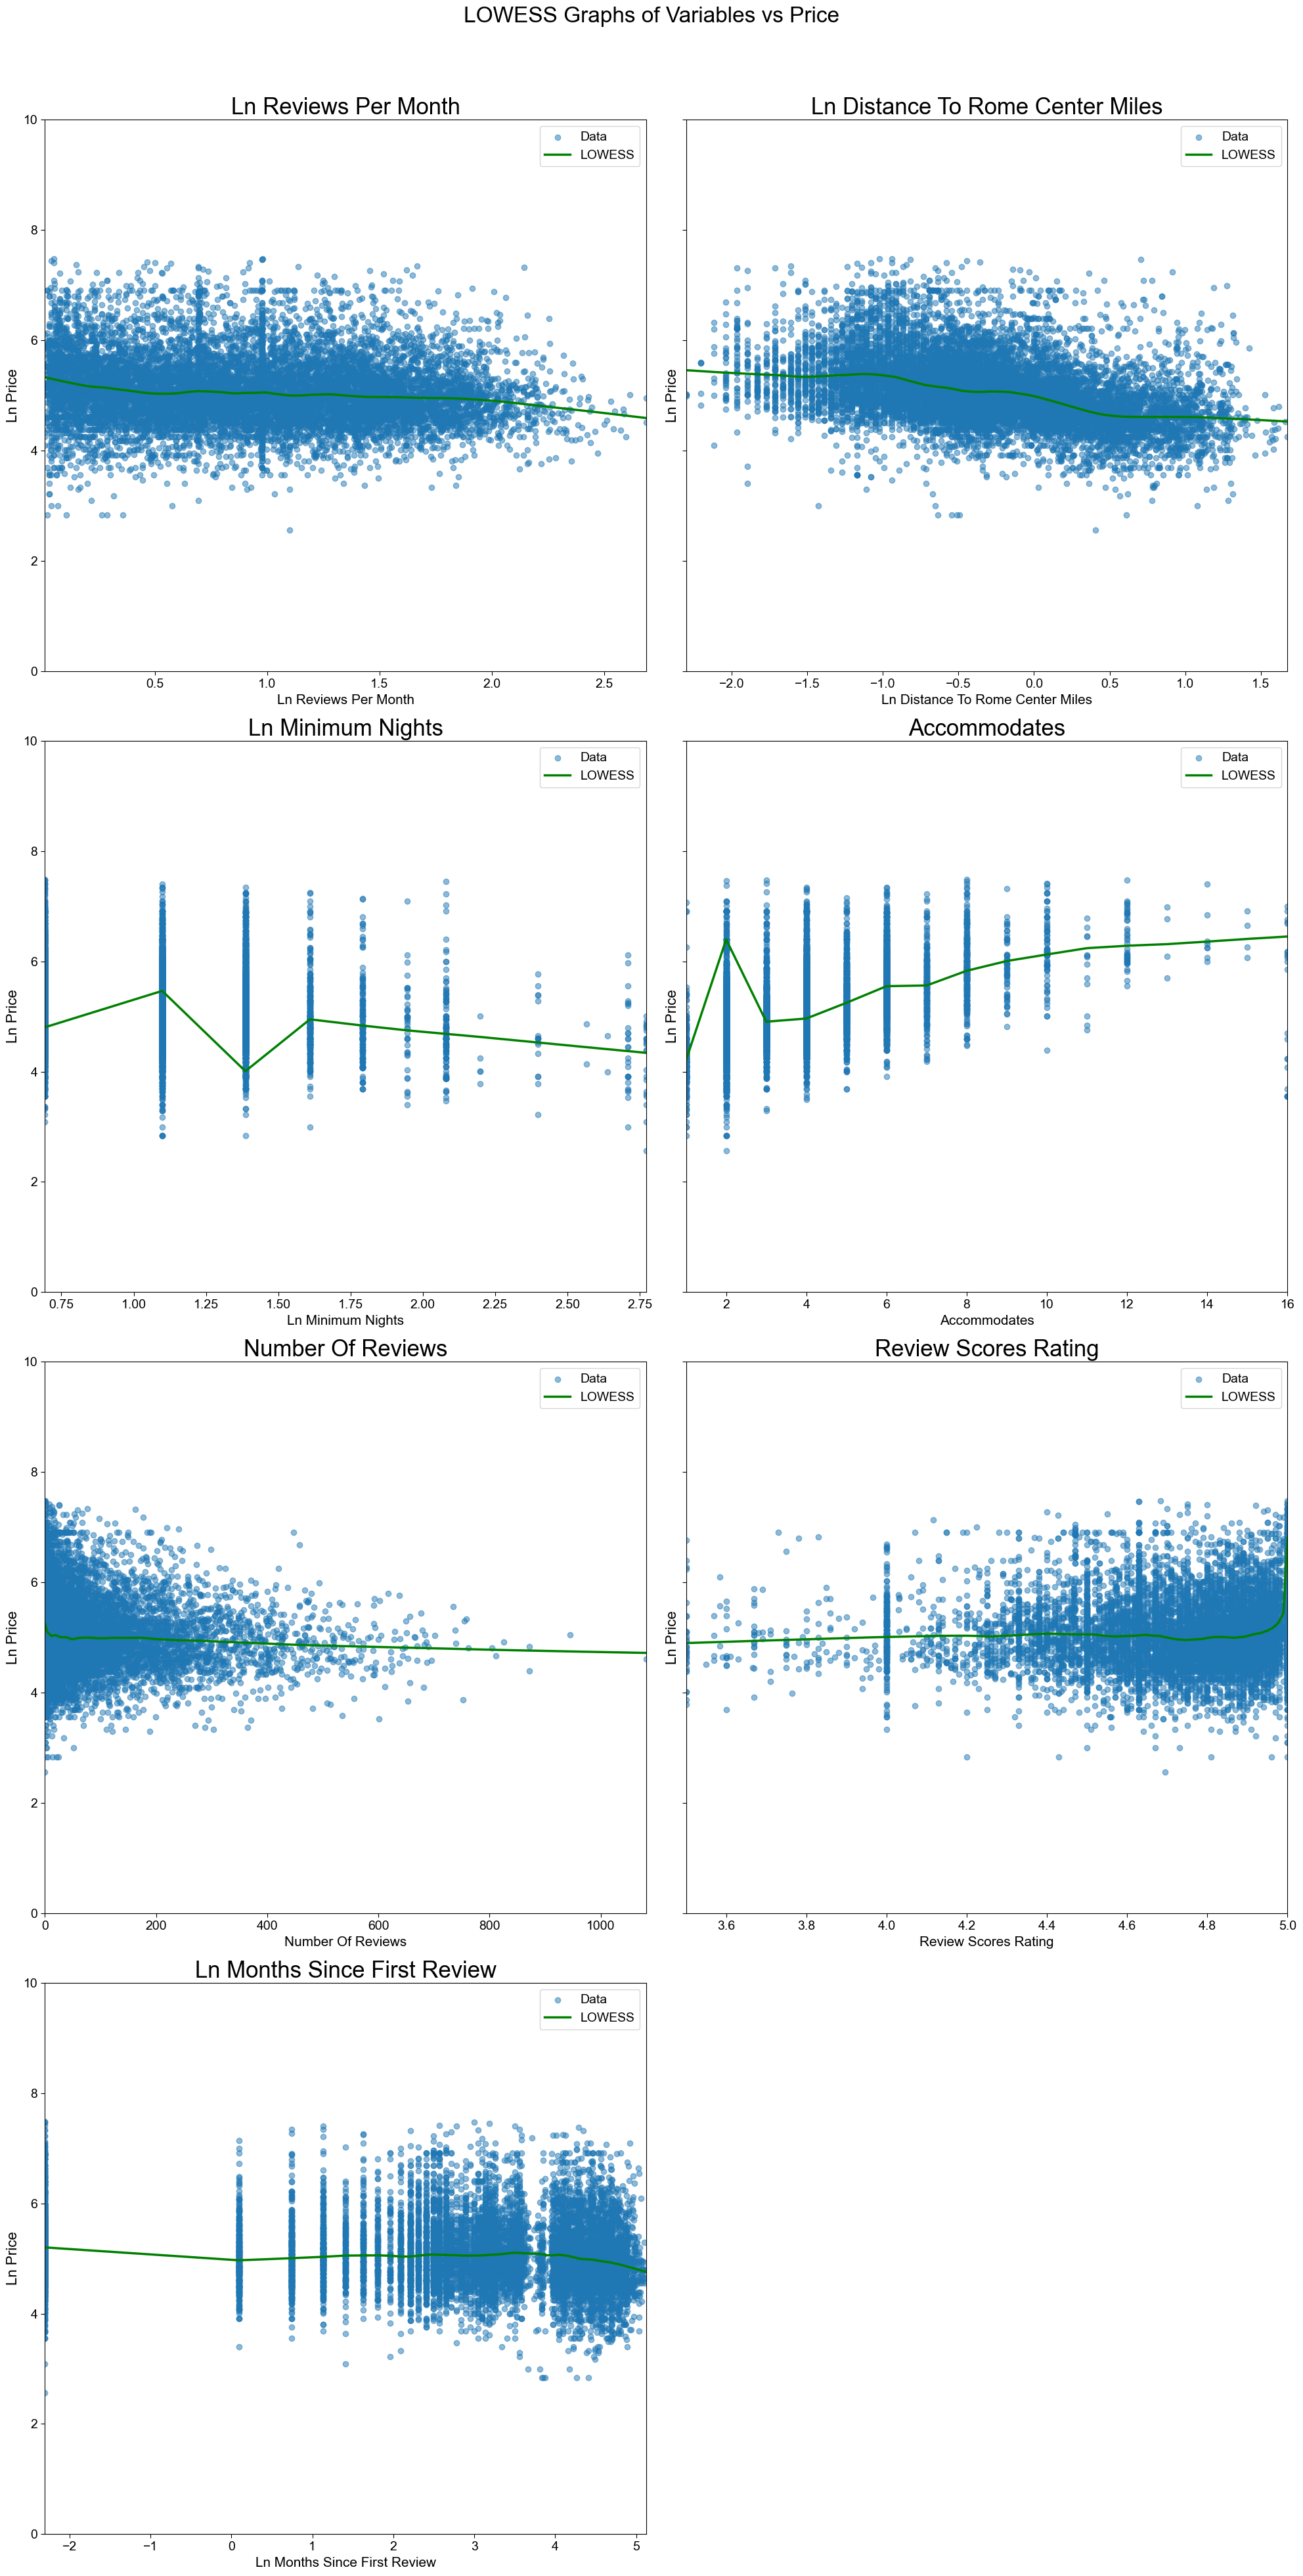

In [410]:
variables = [
    'ln_reviews_per_month',
    'ln_distance_to_rome_center_miles',
    'ln_minimum_nights',
    'accommodates',	
    'number_of_reviews',
    'review_scores_rating',
    'ln_months_since_first_review'
]

# Setting up subplots: 2 columns and as many rows as needed
n_cols = 2
n_rows = -(-len(variables) // n_cols)  # Ceiling division to determine rows
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 10), sharey=True)
axes = axes.flatten()


for i, var in enumerate(variables):
    ax = axes[i]
    
    # Apply LOWESS smoothing
    lowess = sm.nonparametric.lowess(
        hotels_florence['ln_price'],
        hotels_florence[var],
        frac=0.15  # Adjust the smoothing parameter as needed
    )
    
    # Scatterplot of original data
    ax.scatter(hotels_florence[var], hotels_florence['ln_price'], alpha=0.5, label='Data')
    
    # Plot LOWESS smoothed line
    ax.plot(lowess[:, 0], lowess[:, 1], color='green', label='LOWESS', linewidth=2.5)
    
    # Dynamically set x-axis range
    x_min, x_max = hotels_florence[var].min(), hotels_florence[var].max()
    ax.set_xlim(x_min, x_max)
    
    ax.set_title(var.replace('_', ' ').title(), fontsize=25)
    ax.set_xlabel(var.replace('_', ' ').title(), fontsize=15)
    ax.set_ylabel('Ln Price', fontsize=16)
    ax.set_ylim(0, 10)  # Adjusted to match the actual range of happiness_score
    ax.legend(fontsize=14)
    ax.tick_params(axis='x', labelsize=14)  # Increase font size for x-axis values
    ax.tick_params(axis='y', labelsize=14)  # Increase font size for y-axis value

# Hide any unused axes
for i in range(len(variables), len(axes)):
    axes[i].axis('off')

# Adjust layout and add title
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('LOWESS Graphs of Variables vs Price', fontsize=24, y=0.98)
plt.show()


<span style="font-size: 18px;">**Distance to City Center, Accommodation space, minimum nights and somewhat review scores rating tend to have an impact on price. Number of reviews or reviews per month, months since last review do not show a significant relationship. We would continue with out them in the model. It seems linear fits or in case of minimum nights spline transformations would be enough for using these features**

<span style="font-size: 18px;">**Creating spline variables for ln_minimum_nights with knot at 1.38 and 1.10 respectively**

In [413]:
knot_rome = 1.38
knot_florence = 1.10

hotels_rome['log_minimum_nights_spline1'] = np.minimum(knot_rome, hotels_rome["ln_minimum_nights"])  # First part
hotels_rome['log_minimum_nights_spline2'] = np.maximum(0, hotels_rome["ln_minimum_nights"] - knot_rome)  # Second part

hotels_florence['log_minimum_nights_spline1'] = np.minimum(knot_florence, hotels_florence["ln_minimum_nights"])  # First part
hotels_florence['log_minimum_nights_spline2'] = np.maximum(0, hotels_florence["ln_minimum_nights"] - knot_florence)  # Second part

<span style="font-size: 18px;">**NUMERIC FEATURES SELECTED FOR FURTHER MODELLING PRICE:\
\
ACCOMMODATES
\
LN_MINIMUM_NIGHTS (also as spline)
\
LN_DISTANCE_TO_ROME_CENTER_MILES
\
REVIEW SCORE RATINGS**

In [415]:
hotels_florence.drop(['number_of_reviews','months_since_first_review','reviews_per_month','ln_reviews_per_month','ln_months_since_first_review'], axis = 1, inplace = True)
hotels_rome.drop(['number_of_reviews','months_since_first_review','reviews_per_month','ln_reviews_per_month','ln_months_since_first_review'], axis = 1, inplace = True)

<span style="font-size: 18px;">**Identifying different amenities and using domain knowledge to pick price difference creating amenities. Creating boolean columns for their presence/absence in the listing**

In [417]:
import ast  
hotels_rome['amenities'] = hotels_rome['amenities'].apply(ast.literal_eval)

amenities_with_counts = hotels_rome.explode('amenities')['amenities'].value_counts()

hotels_florence['amenities'] = hotels_florence['amenities'].apply(ast.literal_eval)

amenities_with_counts = hotels_florence.explode('amenities')['amenities'].value_counts()



In [418]:

# Defining keyword lists for each amenity category
amenities_map = {
    'Wi_Fi': ['Wifi'],
    'Heating_Cooling': ['Air conditioning', 'Heating', 'AC unit'],
    'Kitchen_Access': ['Kitchen',  'Kitchen', 'Refrigerator', 'Microwave', 'Cooking basics', 'Oven', 'Stove', 'Dishwasher', 'Freezer', 'Coffee maker', 'Hot water kettle', 'Toaster', 'Blender', 'Rice maker', 'Fridge','stove'],
    'Washer_Dryer': ['Washer','washing machine'],
    'Parking': ['Parking'],
    'Pool_HotTub': ['Pool', 'Hot tub'],
    'Balcony_Outdoor_Space': ['Balcony', 'Outdoor','Patio','Backyard','Terrace'],
    'Pet_Friendly_Policy': ['Pet-Friendly', 'Pets allowed'],
    'Smart_TV_Streaming': ['TV', 'Smart lock']
}

# Function to map the amenities based on the list of keywords for each category

def add_amenity_columns(df, amenities_map):
    for new_column, keywords in amenities_map.items():
        # Converting both the amenities list and keywords to lowercase for case-insensitive matching
        df[new_column] = df['amenities'].apply(
            lambda x: any(keyword.lower() in [item.lower() for item in x] for keyword in keywords)
        )
    return df

# Add columns for the amenities
hotels_rome = add_amenity_columns(hotels_rome, amenities_map)
hotels_florence = add_amenity_columns(hotels_florence, amenities_map)

<span style="font-size: 18px;">**Dropping Amenities column as we have extracted the top ones already**

In [420]:
hotels_rome.drop('amenities', axis = 1, inplace = True)
hotels_florence.drop('amenities', axis = 1, inplace = True)

In [421]:
# Select categorical columns (excluding price)
categorical_cols = hotels_rome.select_dtypes(include=["object", "category","bool"]).columns
categorical_cols

# Print number of unique values per categorical column
for col in categorical_cols:
    print(f"{col}: {hotels_rome[col].nunique()} unique values")


id: 29531 unique values
host_is_superhost: 2 unique values
neighbourhood_cleansed: 15 unique values
room_type: 4 unique values
Wi_Fi: 2 unique values
Heating_Cooling: 2 unique values
Kitchen_Access: 2 unique values
Washer_Dryer: 2 unique values
Parking: 1 unique values
Pool_HotTub: 2 unique values
Balcony_Outdoor_Space: 2 unique values
Pet_Friendly_Policy: 2 unique values
Smart_TV_Streaming: 2 unique values


<span style="font-size: 18px;">**Dropping Parking as it has all same values**

In [423]:
hotels_rome.drop('Parking', axis = 1, inplace = True)
hotels_florence.drop('Parking', axis = 1, inplace = True)

<span style="font-size: 18px;">**All smaller neighbourhoods with less than 1000 rows are grouped into others as they have similar average prices**

In [425]:
grouped_neighborhood_rome = pd.DataFrame(hotels_rome.groupby('neighbourhood_cleansed').agg(count = ('id','count'), price = ('price','mean'))).sort_values(by = 'count',ascending = False)
grouped_neighborhood_rome.reset_index(inplace = True)
grouped_neighborhood_rome.head(15)

neighbourhood_cleansed  count       price
0             I Centro Storico  15080  229.412666
1   VII San Giovanni/Cinecittà   2397  133.058824
2         II Parioli/Nomentano   1999  155.989495
3                 XIII Aurelia   1980  163.309091
4              XII Monte Verde   1579  140.979734
5      V Prenestino/Centocelle   1423   94.557273
6               X Ostia/Acilia    867  115.057670
7            VIII Appia Antica    783  135.268199
8              XIV Monte Mario    660  122.587879
9         XI Arvalia/Portuense    604  119.731788
10                IV Tiburtina    523  121.617591
11          XV Cassia/Flaminia    518  138.870656
12             III Monte Sacro    506  116.011858
13                      IX Eur    344  128.168605
14         VI Roma delle Torri    268  100.242537

In [426]:
grouped_neighborhood_florence = pd.DataFrame(hotels_florence.groupby('neighbourhood_cleansed').agg(count = ('id','count'), price = ('price','mean'))).sort_values(by = 'count',ascending = False)
grouped_neighborhood_florence.reset_index(inplace = True)
grouped_neighborhood_florence.head(15)

neighbourhood_cleansed  count       price
0         Centro Storico   8444  228.382046
1         Campo di Marte   1203  143.331671
2                Rifredi    897  123.946488
3       Isolotto Legnaia    489  135.548057
4      Gavinana Galluzzo    426  168.220657

In [427]:
grouped_neighborhood_rome.loc[grouped_neighborhood_rome['count'] < 1000, 'neighbourhood_group'] = 'Others'
grouped_neighborhood_rome['neighbourhood_group'].fillna(grouped_neighborhood_rome['neighbourhood_cleansed'], inplace = True)
grouped_neighborhood_rome.head(10)

neighbourhood_cleansed  count       price         neighbourhood_group
0            I Centro Storico  15080  229.412666            I Centro Storico
1  VII San Giovanni/Cinecittà   2397  133.058824  VII San Giovanni/Cinecittà
2        II Parioli/Nomentano   1999  155.989495        II Parioli/Nomentano
3                XIII Aurelia   1980  163.309091                XIII Aurelia
4             XII Monte Verde   1579  140.979734             XII Monte Verde
5     V Prenestino/Centocelle   1423   94.557273     V Prenestino/Centocelle
6              X Ostia/Acilia    867  115.057670                      Others
7           VIII Appia Antica    783  135.268199                      Others
8             XIV Monte Mario    660  122.587879                      Others
9        XI Arvalia/Portuense    604  119.731788                      Others

In [428]:
grouped_neighborhood_florence.loc[grouped_neighborhood_florence['count'] < 1000, 'neighbourhood_group'] = 'Others'
grouped_neighborhood_florence['neighbourhood_group'].fillna(grouped_neighborhood_florence['neighbourhood_cleansed'], inplace = True)
grouped_neighborhood_florence.head(10)

neighbourhood_cleansed  count       price neighbourhood_group
0         Centro Storico   8444  228.382046      Centro Storico
1         Campo di Marte   1203  143.331671      Campo di Marte
2                Rifredi    897  123.946488              Others
3       Isolotto Legnaia    489  135.548057              Others
4      Gavinana Galluzzo    426  168.220657              Others

In [429]:
hotels_rome = hotels_rome.merge(grouped_neighborhood_rome[['neighbourhood_cleansed','neighbourhood_group']], how = 'left', left_on = 'neighbourhood_cleansed', right_on = 'neighbourhood_cleansed')

In [430]:
hotels_florence = hotels_florence.merge(grouped_neighborhood_florence[['neighbourhood_cleansed','neighbourhood_group']], how = 'left', left_on = 'neighbourhood_cleansed', right_on = 'neighbourhood_cleansed')

In [431]:
hotels_rome.groupby('neighbourhood_group').agg(count = ('id','count'), price = ('price','mean')).sort_values(by = 'count',ascending = False)

count       price
neighbourhood_group                          
I Centro Storico            15080  229.412666
Others                       5073  123.022669
VII San Giovanni/Cinecittà   2397  133.058824
II Parioli/Nomentano         1999  155.989495
XIII Aurelia                 1980  163.309091
XII Monte Verde              1579  140.979734
V Prenestino/Centocelle      1423   94.557273

In [432]:
hotels_florence.groupby('neighbourhood_group').agg(count = ('id','count'), price = ('price','mean')).sort_values(by = 'count',ascending = False)

count       price
neighbourhood_group                   
Centro Storico        8444  228.382046
Others                1812  137.486203
Campo di Marte        1203  143.331671

In [433]:
hotels_rome.drop('neighbourhood_cleansed', axis = 1, inplace = True)

In [434]:
hotels_florence.drop('neighbourhood_cleansed', axis = 1, inplace = True)

In [435]:
hotels_rome['neighbourhood_group'].value_counts()

neighbourhood_group
I Centro Storico              15080
Others                         5073
VII San Giovanni/Cinecittà     2397
II Parioli/Nomentano           1999
XIII Aurelia                   1980
XII Monte Verde                1579
V Prenestino/Centocelle        1423
Name: count, dtype: int64

### Validity - Model Fitting and Results

<span style="font-size: 18px;">**We have 5 models:**

<span style="font-size: 18px;">**1. ols_model**

<span style="font-size: 18px;">**2. lasso_fit**

<span style="font-size: 18px;">**3. rf_model_2**

<span style="font-size: 18px;">**4. gb_model**

<span style="font-size: 18px;">**5. xgb_model**


<span style="font-size: 18px;">**We will adjust for Actual Price using Smearing Coefficient for OLS and Lasso. Also, we would standardize columns to for all 5 models**

<span style="font-size: 18px;">**RMSE Comparison, Graphs, Conclusion and Experience are present at the end**


In [ ]:
hotels_rome.drop('id', axis = 1, inplace = True)
hotels_florence.drop('id',axis = 1, inplace = True)

In [439]:

categorical_columns = hotels_rome.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_columns:
    print(f"Column: {col}")
    print(f"Unique values: {hotels_rome[col].unique()}")
    print('-' * 50)

Column: host_is_superhost
Unique values: ['f' 't']
--------------------------------------------------
Column: room_type
Unique values: ['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']
--------------------------------------------------
Column: neighbourhood_group
Unique values: ['Others' 'I Centro Storico' 'II Parioli/Nomentano' 'XII Monte Verde'
 'XIII Aurelia' 'V Prenestino/Centocelle' 'VII San Giovanni/Cinecittà']
--------------------------------------------------


In [440]:

categorical_columns = hotels_florence.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_columns:
    print(f"Column: {col}")
    print(f"Unique values: {hotels_florence[col].unique()}")
    print('-' * 50)

Column: host_is_superhost
Unique values: ['f' 't']
--------------------------------------------------
Column: room_type
Unique values: ['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']
--------------------------------------------------
Column: neighbourhood_group
Unique values: ['Centro Storico' 'Others' 'Campo di Marte']
--------------------------------------------------


<span style="font-size: 18px;">**WE DO NOT HAVE THE SAME NEIGHBOURHOOD GROUPS IN FLORENCE AS WE HAD IN ROME. HENCE, THIS WAS NOT IN THE TRAINING SET AND THE MODEL WOULD NOT RECOGNIZE THESE FEATURE VALUES WHEN WE TRY TO PREDICT. WE CAN PUT ALL THESE IN OTHERS OR REPLACE IT WITH THE MOST PROMINENT CATEGORY VALUE IN TRAINING SET, SO THIS FEATURE DOES NOT INFLUENCE PREDICTIONS. LUCKILY WE HAVE A NEIGHBORHOOD GROUP WHICH IS INFLUENTIAL IN ROME AND HAS THE SAME NAME IN FLORENCE AS WELL, WE WILL USE THIS AS THE PROXY**

In [442]:
hotels_rome['neighbourhood_group'].value_counts()

neighbourhood_group
I Centro Storico              15080
Others                         5073
VII San Giovanni/Cinecittà     2397
II Parioli/Nomentano           1999
XIII Aurelia                   1980
XII Monte Verde                1579
V Prenestino/Centocelle        1423
Name: count, dtype: int64

In [443]:
hotels_florence['neighbourhood_group'].value_counts()

neighbourhood_group
Centro Storico    8444
Others            1812
Campo di Marte    1203
Name: count, dtype: int64

In [444]:
hotels_florence['neighbourhood_group'] = hotels_florence['neighbourhood_group'].apply(
    lambda x: 'I Centro Storico' if x == 'Centro Storico' else 'Others'
)

In [445]:
hotels_florence['neighbourhood_group'].value_counts()

neighbourhood_group
I Centro Storico    8444
Others              3015
Name: count, dtype: int64

#### OLS

<span style="font-size: 18px;">**As we predicted Log Price previously we had to go through the process of converting log predictions to actuals using smearing estimates. We create a function here which can do all of this conversion and calculate rmse and plot graphs for both different time (Rome Quarter 3 2024) and different Space (Florence Quarter 2 2024)**

**It is important to note that in OLS due to the interaction terms, there would be extra features in the model, specially as we interacted neighborhood group with room type as well. For e.g. in Florence we have just 2 neighbourhoods so the number of features due to interactions would be lower than what the model expects. Hence, first we need to create extra features in the Florence dataset and fill them with zero to predict using our old model**

In [449]:
# Function to predict and evaluate
def predict_and_evaluate(dataset, model, dataset_name, model_columns):
    # Create predictor and response matrices for the current dataset
    y_holdout, X_holdout = patsy.dmatrices("ln_price" + model6, dataset)

    # Convert to DataFrame to retain column names
    X_holdout_df = pd.DataFrame(X_holdout, columns=X_holdout.design_info.column_names)

    # Align dataset with the model's expected columns
    missing_columns = set(model_columns) - set(X_holdout_df.columns)
    extra_columns = set(X_holdout_df.columns) - set(model_columns)

    # Add missing columns with zeros
    for col in missing_columns:
        X_holdout_df[col] = 0

    # Drop extra columns that are not in the model
    X_holdout_df = X_holdout_df.loc[:, model_columns]  

    # Ensure there is no duplicate intercept
    if "Intercept" not in X_holdout_df.columns:
        X_holdout_df.insert(0, "Intercept", 1.0)  

    # Convert DataFrame to NumPy array for Statsmodels
    X_holdout_np = X_holdout_df.to_numpy()  

    # Predict log price
    y_pred_log = model.predict(X_holdout_np)

    # Converting log predictions to price using smearing estimate
    residuals = (y_holdout.flatten() - y_pred_log).ravel()
    sigma_sq = np.var(residuals)
    smearing_factor = np.exp(sigma_sq / 2)
    y_pred_price = np.exp(y_pred_log) * smearing_factor

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(dataset["price"], y_pred_price))
    
    #print(f"RMSE for {dataset_name}: {rmse:.2f}")
    
    return dataset["price"], y_pred_price, rmse


In [703]:
# Get the columns from the model used for predictions (baseline columns)
model_columns = ols_model.model.exog_names

# Run for both datasets independently
actual_rome_ols, predicted_rome_ols, rmse_rome_ols = predict_and_evaluate(hotels_rome, ols_model, "Rome (Later Time)", model_columns)
actual_florence_ols, predicted_florence_ols, rmse_florence_ols = predict_and_evaluate(hotels_florence, ols_model, "Florence (Same Time)", model_columns)


#### Lasso

<span style="font-size: 14px;">**Similar to what we did in OLS, we need to impute and standardize all columns that were present during training the model, otherwise it would not be able to predict. We had predicted log price so we further transform the values using smearing factor to bring it back to Price for comparison with other models**

In [453]:
def predict_lasso(dataset, dataset_name):
    _, X_holdout = patsy.dmatrices("ln_price" + broad_model, dataset)
    X_holdout_df = pd.DataFrame(X_holdout, columns=X_holdout.design_info.column_names)
    
    # Ensuring X_holdout matches training features
    missing_columns = set(model_columns) - set(X_holdout_df.columns)
    for col in missing_columns:
        X_holdout_df[col] = 0  # Fill missing features with 0
    
    # Reordering columns to match model
    X_holdout_df = X_holdout_df.loc[:, model_columns]
    
    # Standardizing using the same scaler as training
    X_holdout_scaled = StandardScaler().fit_transform(X_holdout_df)  
    
    # Predicting on the test set using Lasso model
    y_pred_lasso_log = lasso_fit.predict(X_holdout_scaled)  # Log-scale predictions
    
    # Compute residuals for Lasso
    residuals_lasso = dataset["ln_price"] - y_pred_lasso_log
    sigma_sq_lasso = np.var(residuals_lasso)  # Residual variance
    
    # Compute smearing factor for Lasso
    smearing_factor_lasso = np.exp(sigma_sq_lasso / 2)
    
    # Convert Lasso predictions back to original scale
    y_pred_lasso_price = np.exp(y_pred_lasso_log) * smearing_factor_lasso
    
    # Compute RMSE for Lasso
    rmse_lasso = np.sqrt(mean_squared_error(dataset["price"], y_pred_lasso_price))
    return dataset["price"], y_pred_lasso_price, rmse_lasso

In [454]:

# Running for both datasets independently
actual_rome_lasso, predicted_rome_lasso, rmse_rome_lasso = predict_lasso(hotels_rome, "Rome (Later Time)")
actual_florence_lasso, predicted_florence_lasso, rmse_florence_lasso = predict_lasso(hotels_florence,"Florence (Same Time)")


#### Random Forest, Gradient Boosting and XGBoost

In [456]:
numeric_features = ["accommodates","distance_to_rome_center_miles","review_scores_rating","minimum_nights"]
categorical_features = ["host_is_superhost", "room_type","neighbourhood_group"]
amenities= ["Wi_Fi","Heating_Cooling",
                        "Washer_Dryer","Pet_Friendly_Policy","Smart_TV_Streaming", "Kitchen_Access","Balcony_Outdoor_Space","Pool_HotTub"]

<span style="font-size: 14px;">**Creating copy of Rome and Florence Dataset to Transform and Predict**

In [458]:
hotels_rome_temp = hotels_rome.copy()
hotels_florence_temp = hotels_florence.copy()

In [459]:
hotels_florence_temp.head()

host_is_superhost        room_type  accommodates  price  minimum_nights  \
0                 f     Private room             2  122.0               1   
1                 f  Entire home/apt             2   95.0               1   
2                 t  Entire home/apt             4  109.0               6   
3                 f     Private room             2  104.0               2   
4                 f     Private room             2  121.0               2   

   review_scores_rating  distance_to_rome_center_miles  ln_price  \
0                  4.66                           0.55  4.804021   
1                  4.88                           1.21  4.553877   
2                  4.76                           0.62  4.691348   
3                  4.54                           0.42  4.644391   
4                  4.32                           0.42  4.795791   

   ln_minimum_nights  ln_distance_to_rome_center_miles  ...  \
0           0.693147                         -0.430783  ...   
1           0.693147                          0.270027  ...   
2           1.945910                         -0.328504  ...   
3           1.098612                         -0.653926  ...   
4           1.098612                         -0.653926  ...   

   log_minimum_nights_spline2  Wi_Fi  Heating_Cooling  Kitchen_Access  \
0                     0.00000   True             True            True   
1                     0.00000   True             True            True   
2                     0.84591   True             True            True   
3                     0.00000   True             True           False   
4                     0.00000   True             True            True   

   Washer_Dryer  Pool_HotTub  Balcony_Outdoor_Space  Pet_Friendly_Policy  \
0         False        False                  False                False   
1         False        False                  False                False   
2          True        False                  False                False   
3         False        False                  False                False   
4         False        False                  False                False   

   Smart_TV_Streaming  neighbourhood_group  
0               False     I Centro Storico  
1                True               Others  
2                True     I Centro Storico  
3                True     I Centro Storico  
4                True     I Centro Storico  

[5 rows x 21 columns]

In [460]:
hotels_rome_temp[amenities] = hotels_rome_temp[amenities].astype(int)
hotels_florence_temp[amenities] = hotels_florence_temp[amenities].astype(int)

In [461]:
predictors = numeric_features + categorical_features + amenities

In [462]:
predictors

['accommodates',
 'distance_to_rome_center_miles',
 'review_scores_rating',
 'minimum_nights',
 'host_is_superhost',
 'room_type',
 'neighbourhood_group',
 'Wi_Fi',
 'Heating_Cooling',
 'Washer_Dryer',
 'Pet_Friendly_Policy',
 'Smart_TV_Streaming',
 'Kitchen_Access',
 'Balcony_Outdoor_Space',
 'Pool_HotTub']

In [463]:
preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features + amenities),
    ]
)

In [464]:
X_rome = preprocessor.fit_transform(hotels_rome_temp[predictors])
X_rome = pd.DataFrame(X_rome, columns=preprocessor.get_feature_names_out()).astype(float)
y_rome = hotels_rome_temp["price"].astype(float)

X_florence = preprocessor.fit_transform(hotels_florence_temp[predictors])
X_florence = pd.DataFrame(X_florence, columns=preprocessor.get_feature_names_out()).astype(float)
y_florence = hotels_florence_temp["price"].astype(float)



<span style="font-size: 14px;">**Streamlining columns so they match the ones during fit**

In [466]:
X = preprocessor.fit_transform(work_set[predictors])
X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out()).astype(float)
train_columns = X.columns

# Get the feature columns from the new data (X_florence)
florence_columns = X_florence.columns

# Identify missing columns in X_florence that were in X_train
missing_columns = set(train_columns) - set(florence_columns)

# Add missing columns to X_florence with 0 values
for col in missing_columns:
    X_florence[col] = 0  # Add missing column with zeros

# Ensure X_florence columns are in the same order as X_train
X_florence = X_florence[train_columns]

**Predictions on Live Data using Random Forest, GB and XGB**

In [468]:
# Random Forest Predictions
y_pred_rf_rome = rf_model_2.predict(X_rome)
y_pred_rf_florence = rf_model_2.predict(X_florence)

# Gradient Boosting Predictions
y_pred_gb_rome = gb_model.predict(X_rome)
y_pred_gb_florence = gb_model.predict(X_florence)

# XGBoost Predictions
y_pred_xgb_rome = xgb_model.predict(X_rome)
y_pred_xgb_florence = xgb_model.predict(X_florence)

In [469]:
rmse_rf_rome = np.sqrt(mean_squared_error(hotels_rome["price"], y_pred_rf_rome))
rmse_rf_florence = np.sqrt(mean_squared_error(hotels_florence["price"], y_pred_rf_florence))

rmse_gb_rome = np.sqrt(mean_squared_error(hotels_rome["price"], y_pred_gb_rome))
rmse_gb_florence = np.sqrt(mean_squared_error(hotels_florence["price"], y_pred_gb_florence))

rmse_xgb_rome = np.sqrt(mean_squared_error(hotels_rome["price"], y_pred_xgb_rome))
rmse_xgb_florence = np.sqrt(mean_squared_error(hotels_florence["price"], y_pred_xgb_florence))

In [470]:
pd.DataFrame(
    {
        "Model": ["OLS (model6)", "Lasso", "Random Forest", "Gradient Boosting", "XGBoost"],
        "Rome RMSE (Later Time Same Place)": [rmse_rome_ols, rmse_rome_lasso, rmse_rf_rome, rmse_gb_rome, rmse_xgb_rome],
        "Florence RMSE (Same Time Different Place)": [rmse_florence_ols, rmse_florence_lasso, rmse_rf_florence, rmse_gb_florence, rmse_xgb_florence],
    }
).round(2)

Model  Rome RMSE (Later Time Same Place)  \
0       OLS (model6)                             119.16   
1              Lasso                             118.61   
2      Random Forest                             108.08   
3  Gradient Boosting                             114.21   
4            XGBoost                             114.00   

   Florence RMSE (Same Time Different Place)  
0                                     161.14  
1                                     156.96  
2                                     159.11  
3                                     159.04  
4                                     157.98

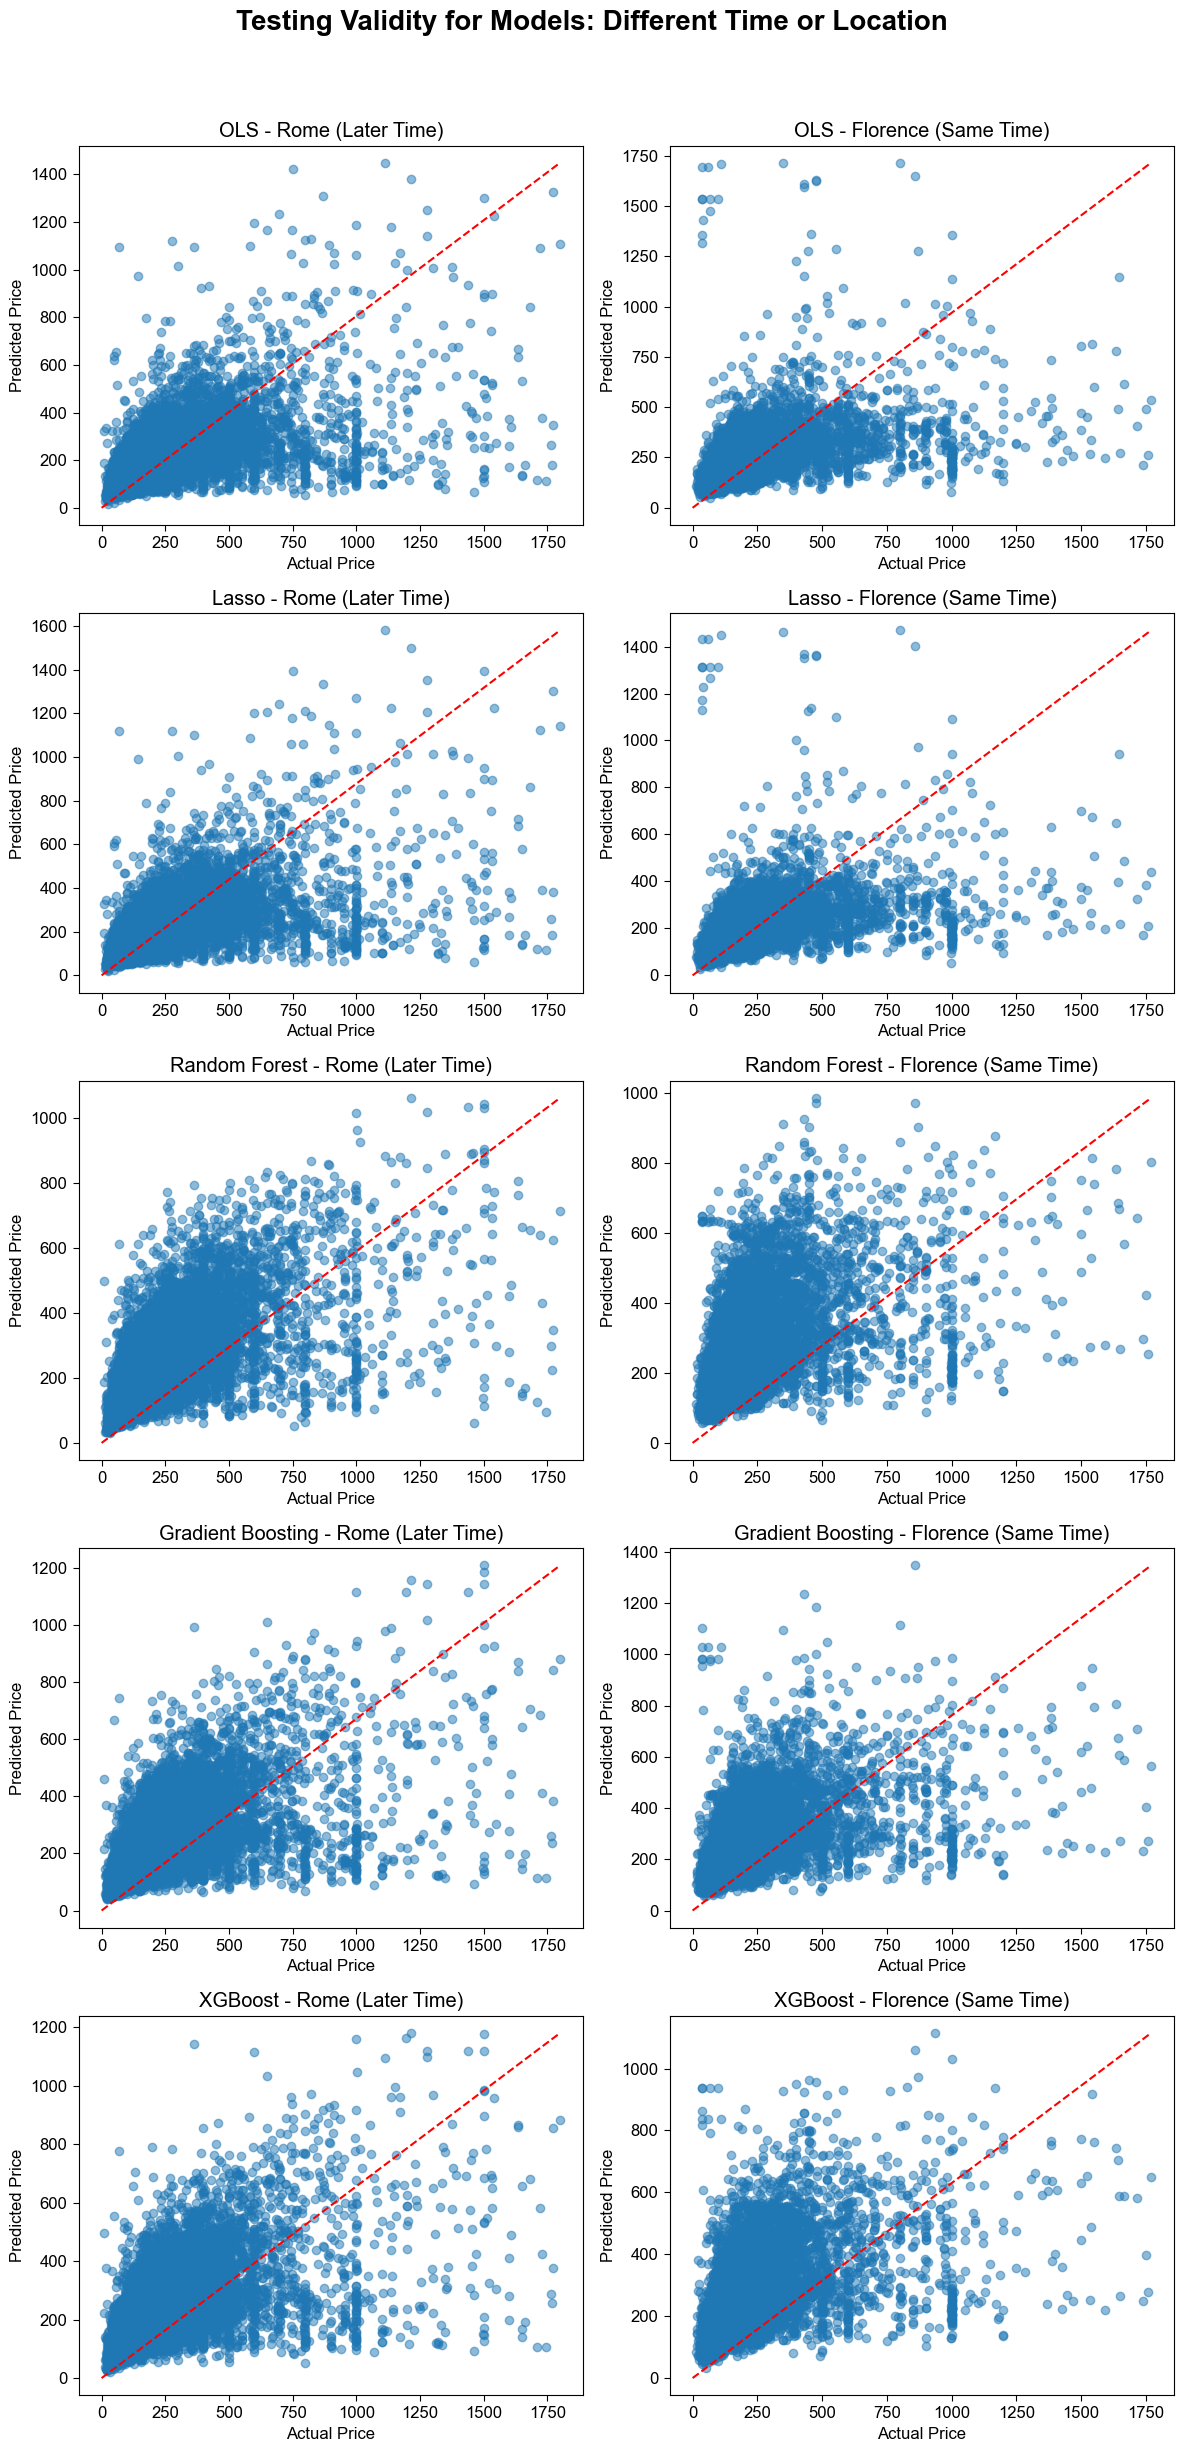

In [471]:
import matplotlib.pyplot as plt

# Creating a figure with 5 rows (models) and 2 columns (Rome & Florence)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 25))

# Main title for the entire figure
fig.suptitle("Testing Validity for Models: Different Time or Location", fontsize=20, fontweight='bold')

# Defining row titles (model names)
model_names = ["OLS", "Lasso", "Random Forest", "Gradient Boosting", "XGBoost"]
rome_actuals = [actual_rome_ols, actual_rome_lasso, hotels_rome["price"], hotels_rome["price"], hotels_rome["price"]]
rome_preds = [predicted_rome_ols, predicted_rome_lasso, y_pred_rf_rome, y_pred_gb_rome, y_pred_xgb_rome]
florence_actuals = [actual_florence_ols, actual_florence_lasso, hotels_florence["price"], hotels_florence["price"], hotels_florence["price"]]
florence_preds = [predicted_florence_ols, predicted_florence_lasso, y_pred_rf_florence, y_pred_gb_florence, y_pred_xgb_florence]

# Iterating over rows for each model
for i, model in enumerate(model_names):
    # Rome subplot (Left)
    axes[i, 0].scatter(rome_actuals[i], rome_preds[i], alpha=0.5)
    axes[i, 0].plot([0, max(rome_actuals[i])], [0, max(rome_preds[i])], color="red", linestyle="--")
    axes[i, 0].set_xlabel("Actual Price")
    axes[i, 0].set_ylabel("Predicted Price")
    axes[i, 0].set_title(f"{model} - Rome (Later Time)")
    
    # Florence subplot (Right)
    axes[i, 1].scatter(florence_actuals[i], florence_preds[i], alpha=0.5)
    axes[i, 1].plot([0, max(florence_actuals[i])], [0, max(florence_preds[i])], color="red", linestyle="--")
    axes[i, 1].set_xlabel("Actual Price")
    axes[i, 1].set_ylabel("Predicted Price")
    axes[i, 1].set_title(f"{model} - Florence (Same Time)")

# Adjust layout to fit titles properly
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<span style="font-size: 18px;">**Model Performance on Rome Q3 (Later Time, Same Place):**

<span style="font-size: 16px;">The RMSE for Rome Q3 is relatively low across all models, with Random Forest performing the best (108.08) as it did in the original hold out set as well. We also observe that we find the same patterns of accuracies across models as we saw in the original set. Moreover, all models still have low RMSE which are comparable to the RMSE found in the original model results. This indicates that the models, particularly the Tree based algorithms , are capturing temporal patterns within the same location (Rome) quite well, suggesting good generalization to future time periods at the same location.



<span style="font-size: 18px;">**Model Performance on Florence Q2 (Same Time, Different Place):**

<span style="font-size: 16px;">The RMSE for Florence Q2 is notably higher across all models, with Lasso surprisingly performing the best at 156.96 followed by XGBoost. We also observe that Random Forest performs worse than these models with a RMSE of 159.11, respectively. This suggests that Lasso and XGBoost have higher external validity in terms of space when compared to other models.
The increase in overall average RMSE for models suggests that all model struggle with location shifts. The drop in performance (compared to the Rome Q3 predictions) could be due to differences between Rome and Florence that the model hasn't fully captured. These differences could be geographical, demographic, or socioeconomic in nature, leading to a mismatch in model predictions when applied to a new location.

<span style="font-size: 18px;">**Experience:**

<span style="font-size: 16px;">It is challenging to predict on live data for the OLS and Lasso models, specially if you are using any functional form such as log transformation for the predictive variable. In order to get to the actual values methods such as use of smearing coefficients would be required. Moreover, In OLS or Lasso we need to define all the features, their transformations and their interactions when training the model. Hence, when making predictions this becomes a challenge as one needs to generate all features and all interactions in the live data as well that were present during model fit. This is simpler comparitively in Tree based algorithms as although we have to provide all features present during the model training but we do not need to provide the additional transformed features and their interactions as they were not required in training. These features can be easily imputed with 0s based on the initial training set.